In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('paper')

In [2]:
plt.rcParams['figure.dpi'] = 300

In [3]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [4]:
import sklearn 
sklearn.__version__


'0.24.1'

In [5]:
import scipy
scipy.__version__

'1.6.2'

In [6]:
pd.__version__

'1.2.3'

In [7]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [8]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [9]:
sns.set_context('poster')
sns.set_style('white')

In [10]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
psizes = [200,220,240,150,400]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [11]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'

In [12]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [13]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [14]:
df = pd.read_pickle('CCPA.pkl.gz')

In [15]:
df = cp.update_calculated_fields(df)

In [16]:
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [17]:
df.groupby('experiment_sample')['day'].count().sum()

34415

Text(0.5, 1.0, 'med4 (CCPA ex1)')

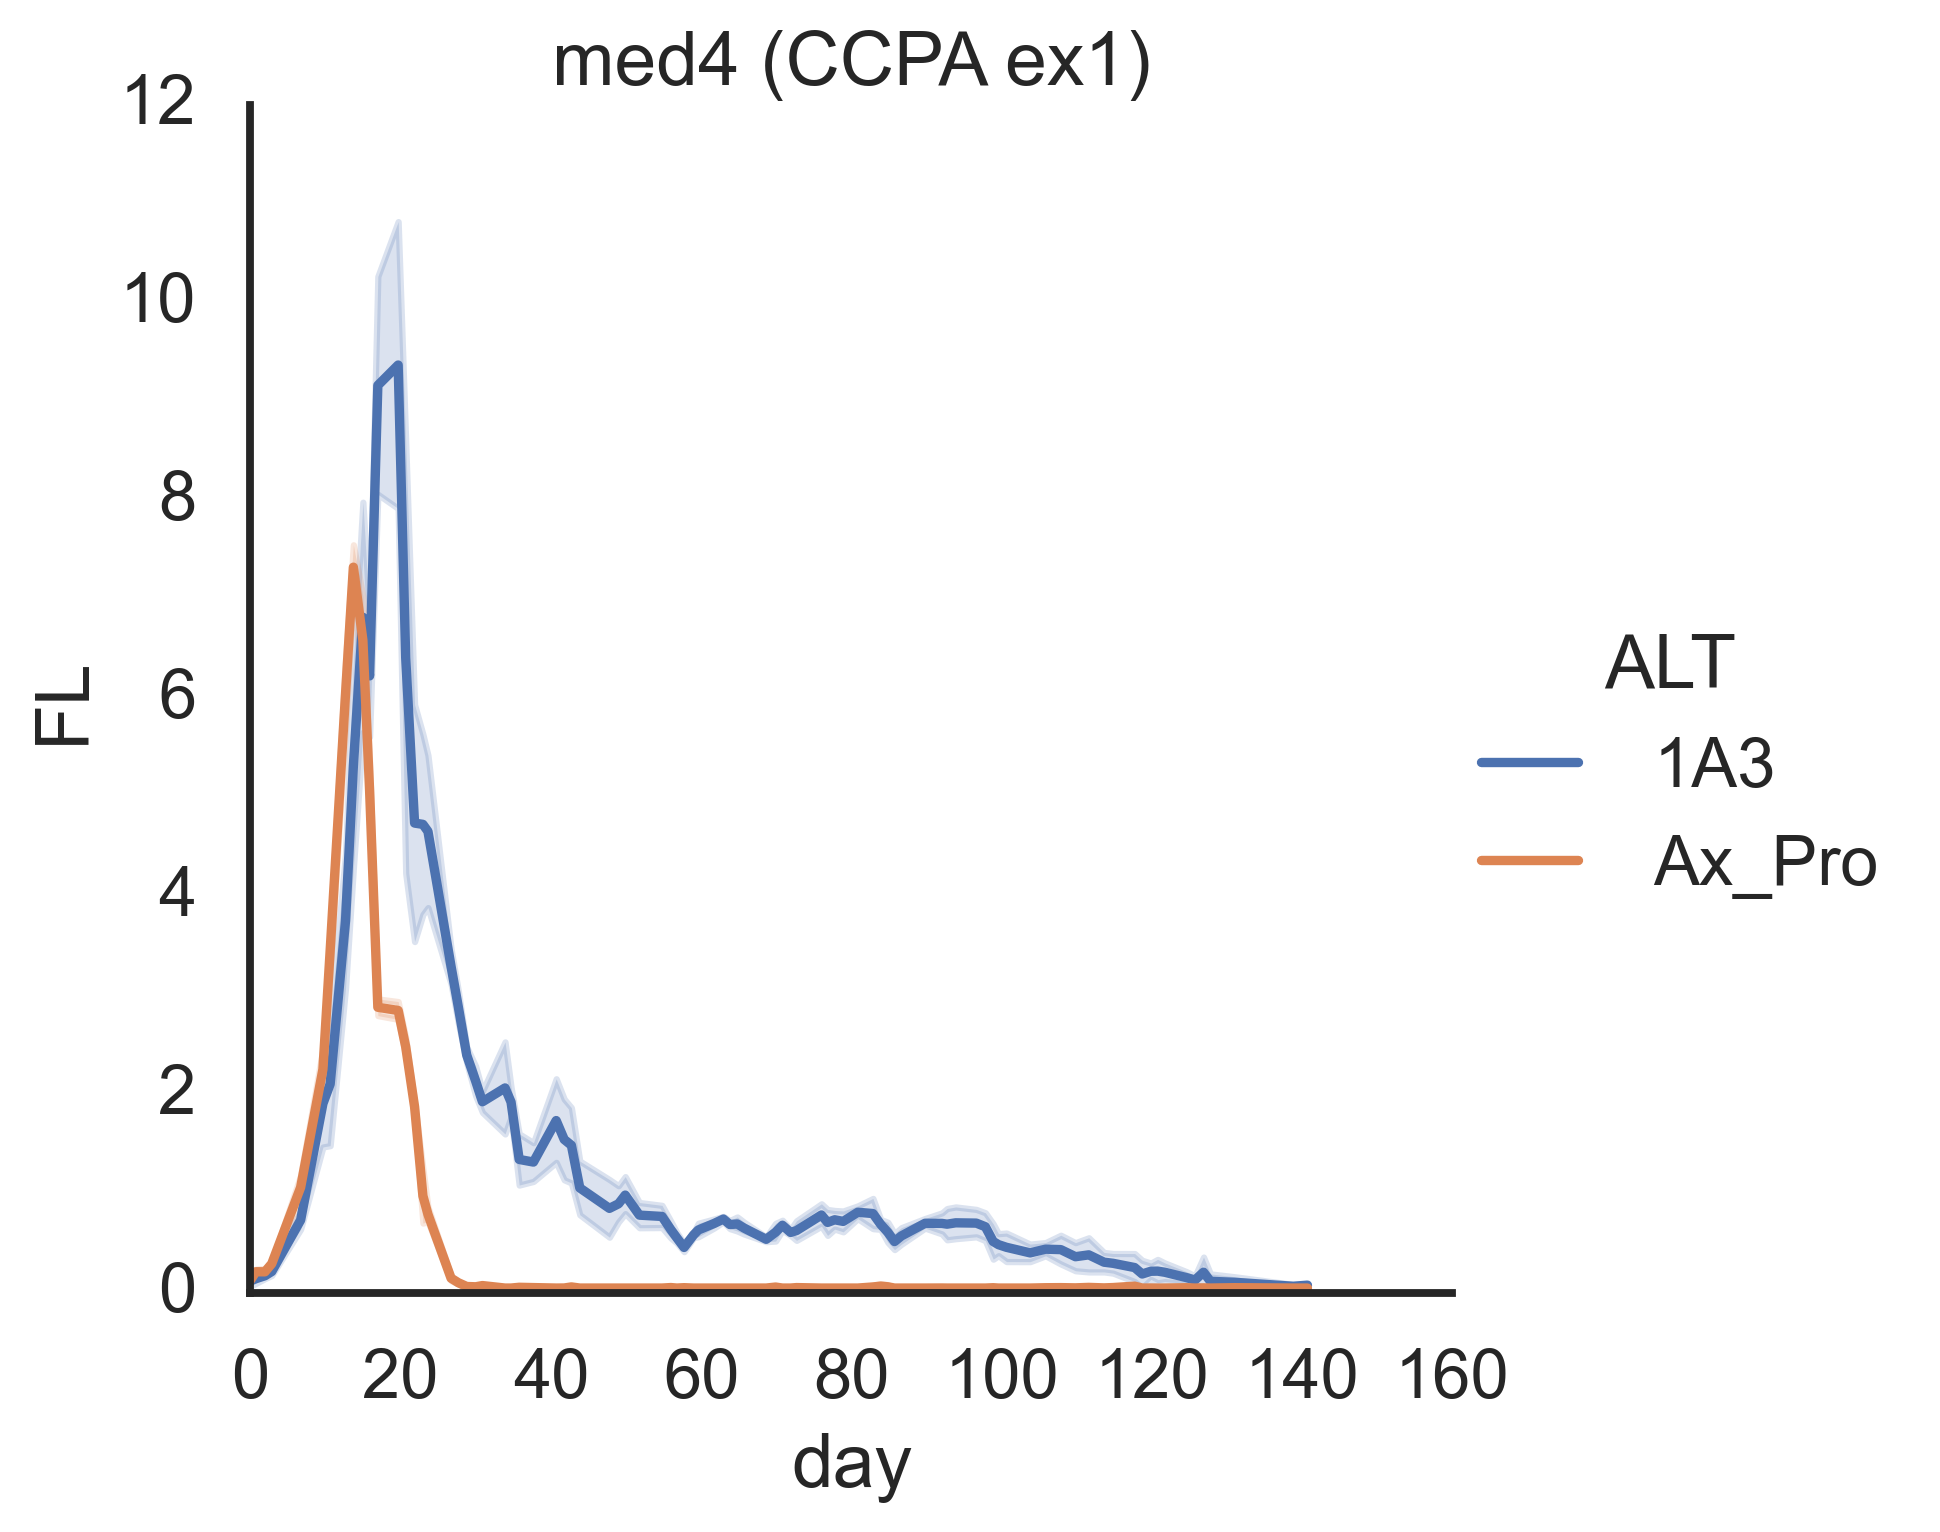

In [18]:
sns.set_context('talk')
#sns.set(font_scale=1.5, context='poster', style='white')
sns.relplot(data=df.loc[df.experiment.isin(['e1']) & df.ALT.isin(['Ax_Pro', '1A3']) & df.PRO.isin(['MED4']) #& (df.day < 30)
                       ], 
            hue='ALT', 
            x='day',y='FL', kind='line',
           #hue='PRO', palette=ppallete, 
            ci='sd', #legend=False,
            #hue_order=porder, col_order=porder,
            #lw=10,
           ).set_titles('{col_name}') #.set(xticks=[0,15,30], yticks=[0,4,8])
plt.title('med4 (CCPA ex1)')

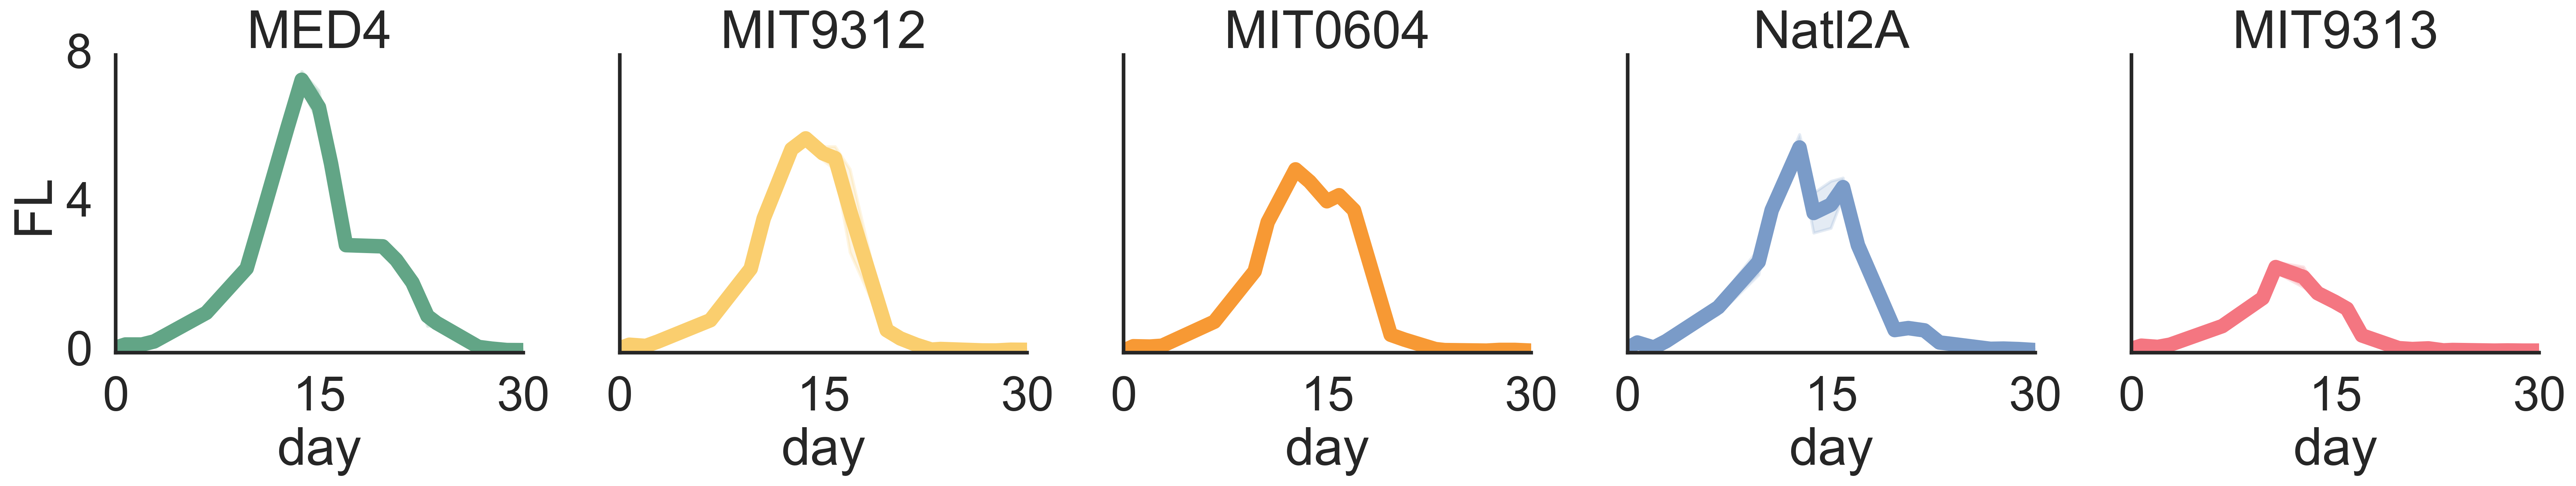

In [19]:
#sns.set_context('poster')
sns.set(font_scale=1.5, context='poster', style='white')
sns.relplot(data=df.loc[df.experiment.isin(['e1']) & df.ALT.isin(['Ax_Pro']) & (df.day < 30)], 
            col='PRO', x='day',y='FL', kind='line',
           hue='PRO', palette=ppallete, ci='sd', legend=False,
            hue_order=porder, col_order=porder,
            lw=10,
           ).set_titles('{col_name}').set(xticks=[0,15,30], yticks=[0,4,8])

In [20]:
df.loc[df.culture.isin(['Co_Culture', 'Axenic']) & 
       df.experiment.isin(['e1','e3', 'e4','e5', 'e6', 'e2'])].experiment_sample.nunique()

429

In [21]:
dfc = df.loc[(df.experiment.isin(['e1','e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [22]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='1d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    maxday = t.loc[t[value_col] == t[value_col].max(), x_col].values[0]
    t.loc[:, x_col] = t.loc[:, x_col] - maxday

    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [23]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = dfc.groupby(groupby_cols).apply(convert_func).reset_index() 

In [24]:
dfc_resample = ds.copy()

In [25]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds.loc[(ds.day < 81) & (ds.day > -11)]

In [26]:
ds.head()

experiment_sample experiment sample      PRO ALT     culture  day       FL
5           e1, 10A         e1    10A  MIT0604  DE  Co_Culture  -10  0.37325
6           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -9  0.44400
7           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -8  0.69700
8           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -7  0.95000
9           e1, 10A         e1    10A  MIT0604  DE  Co_Culture   -6  1.20300

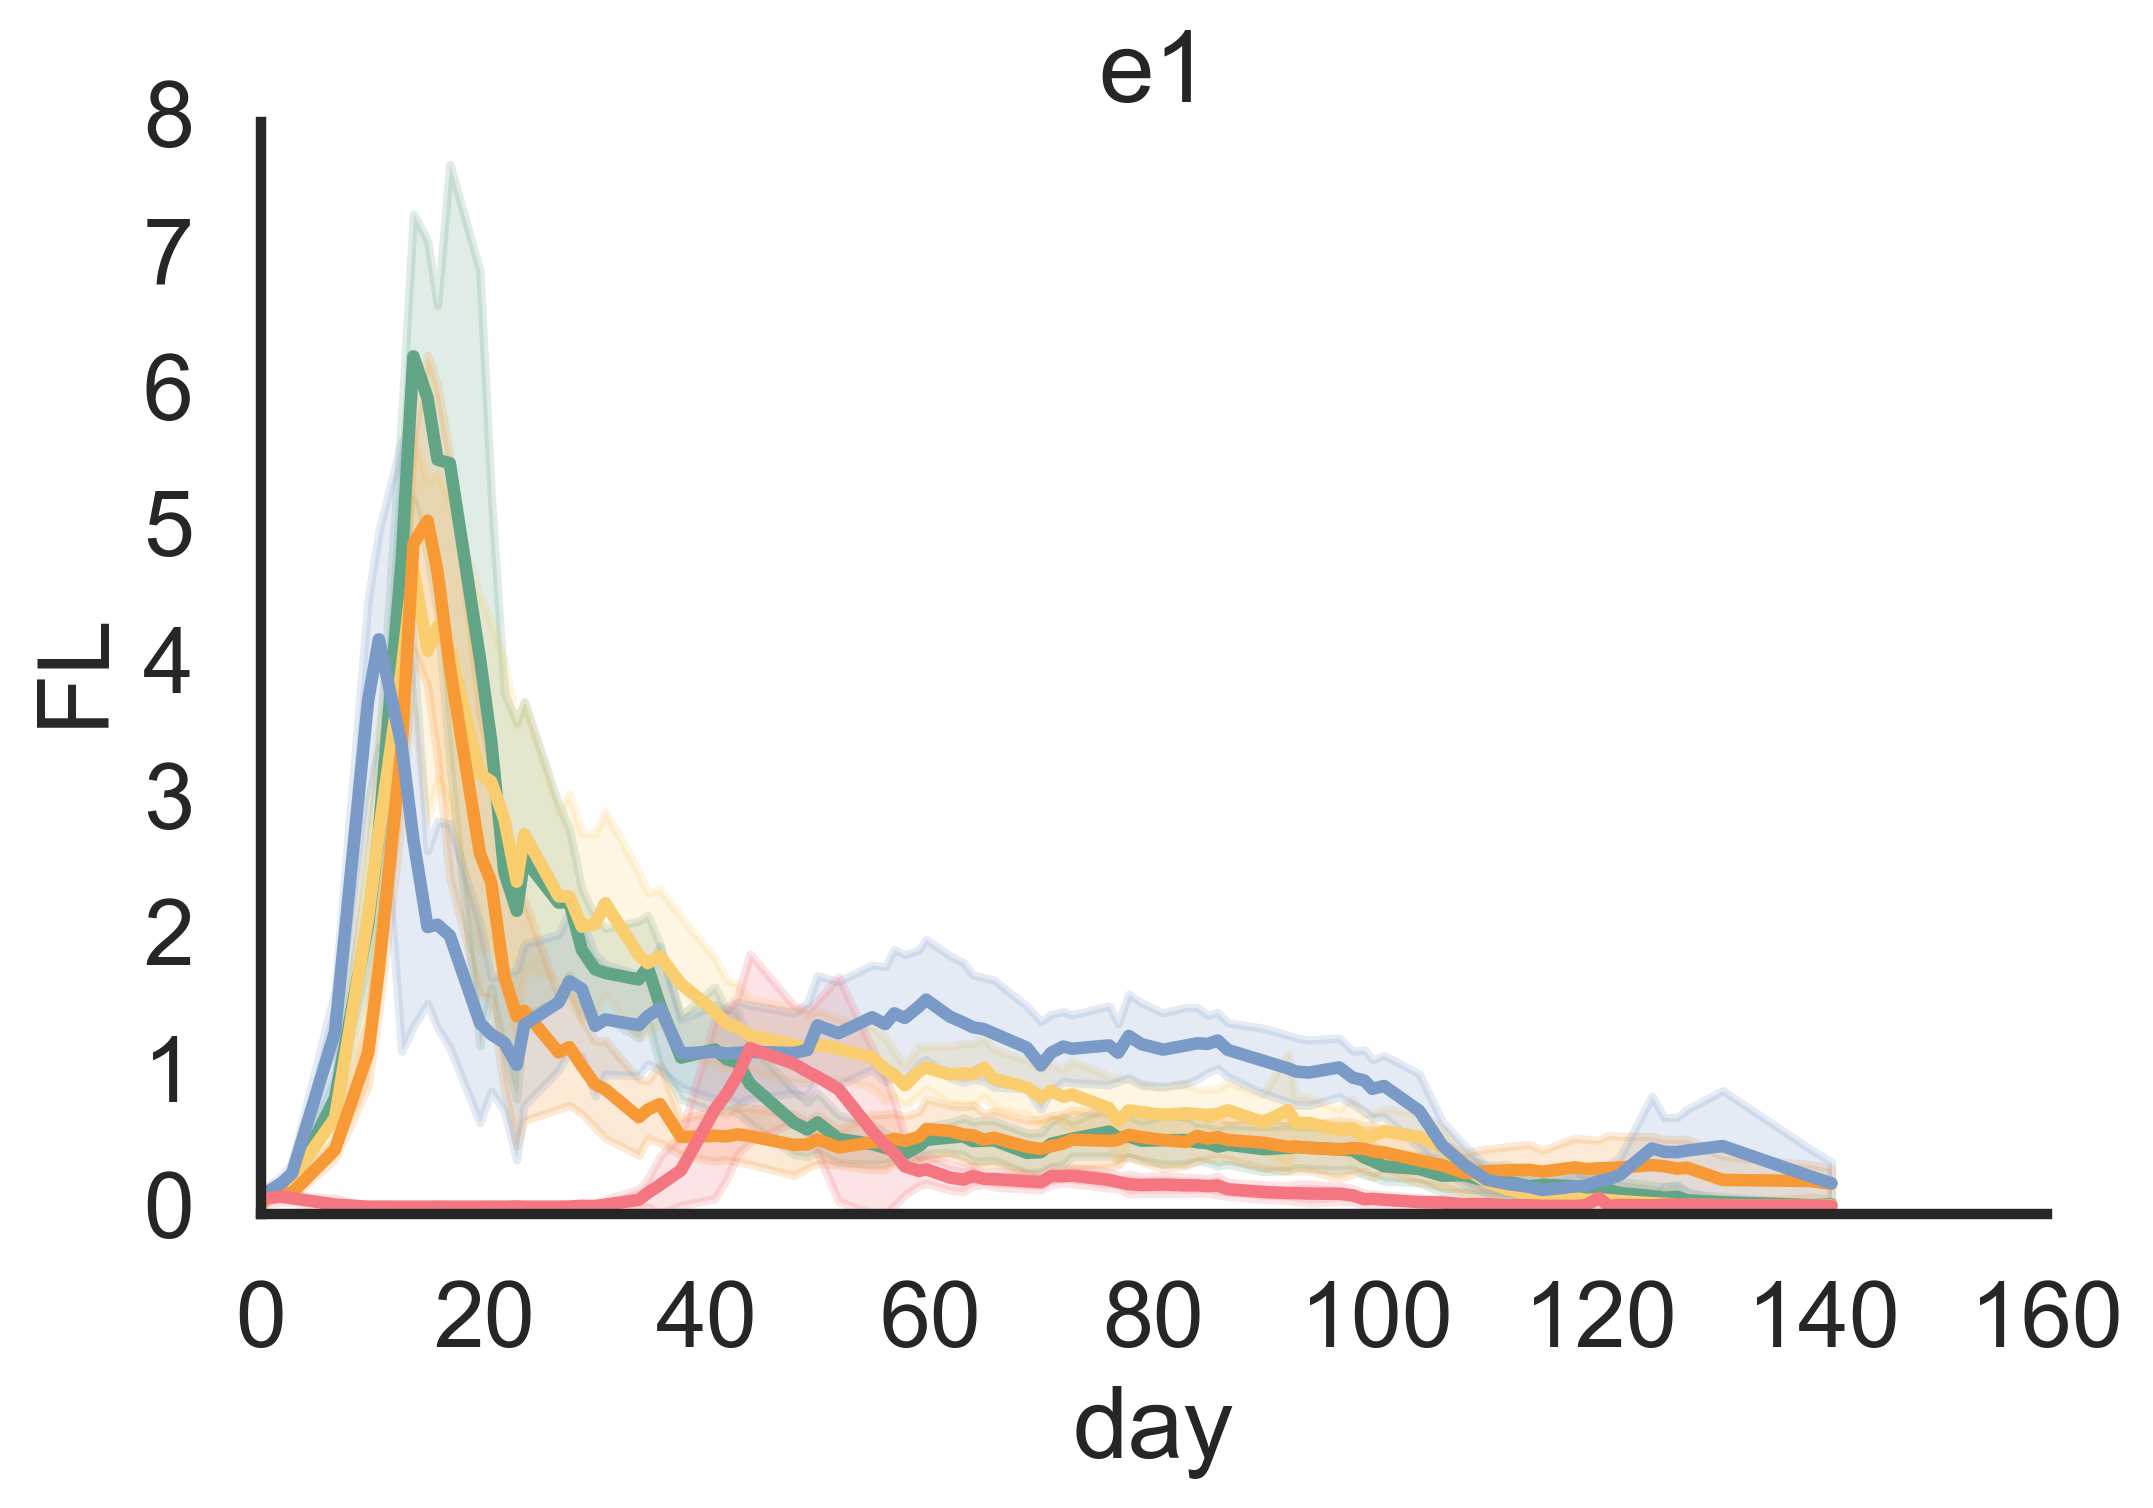

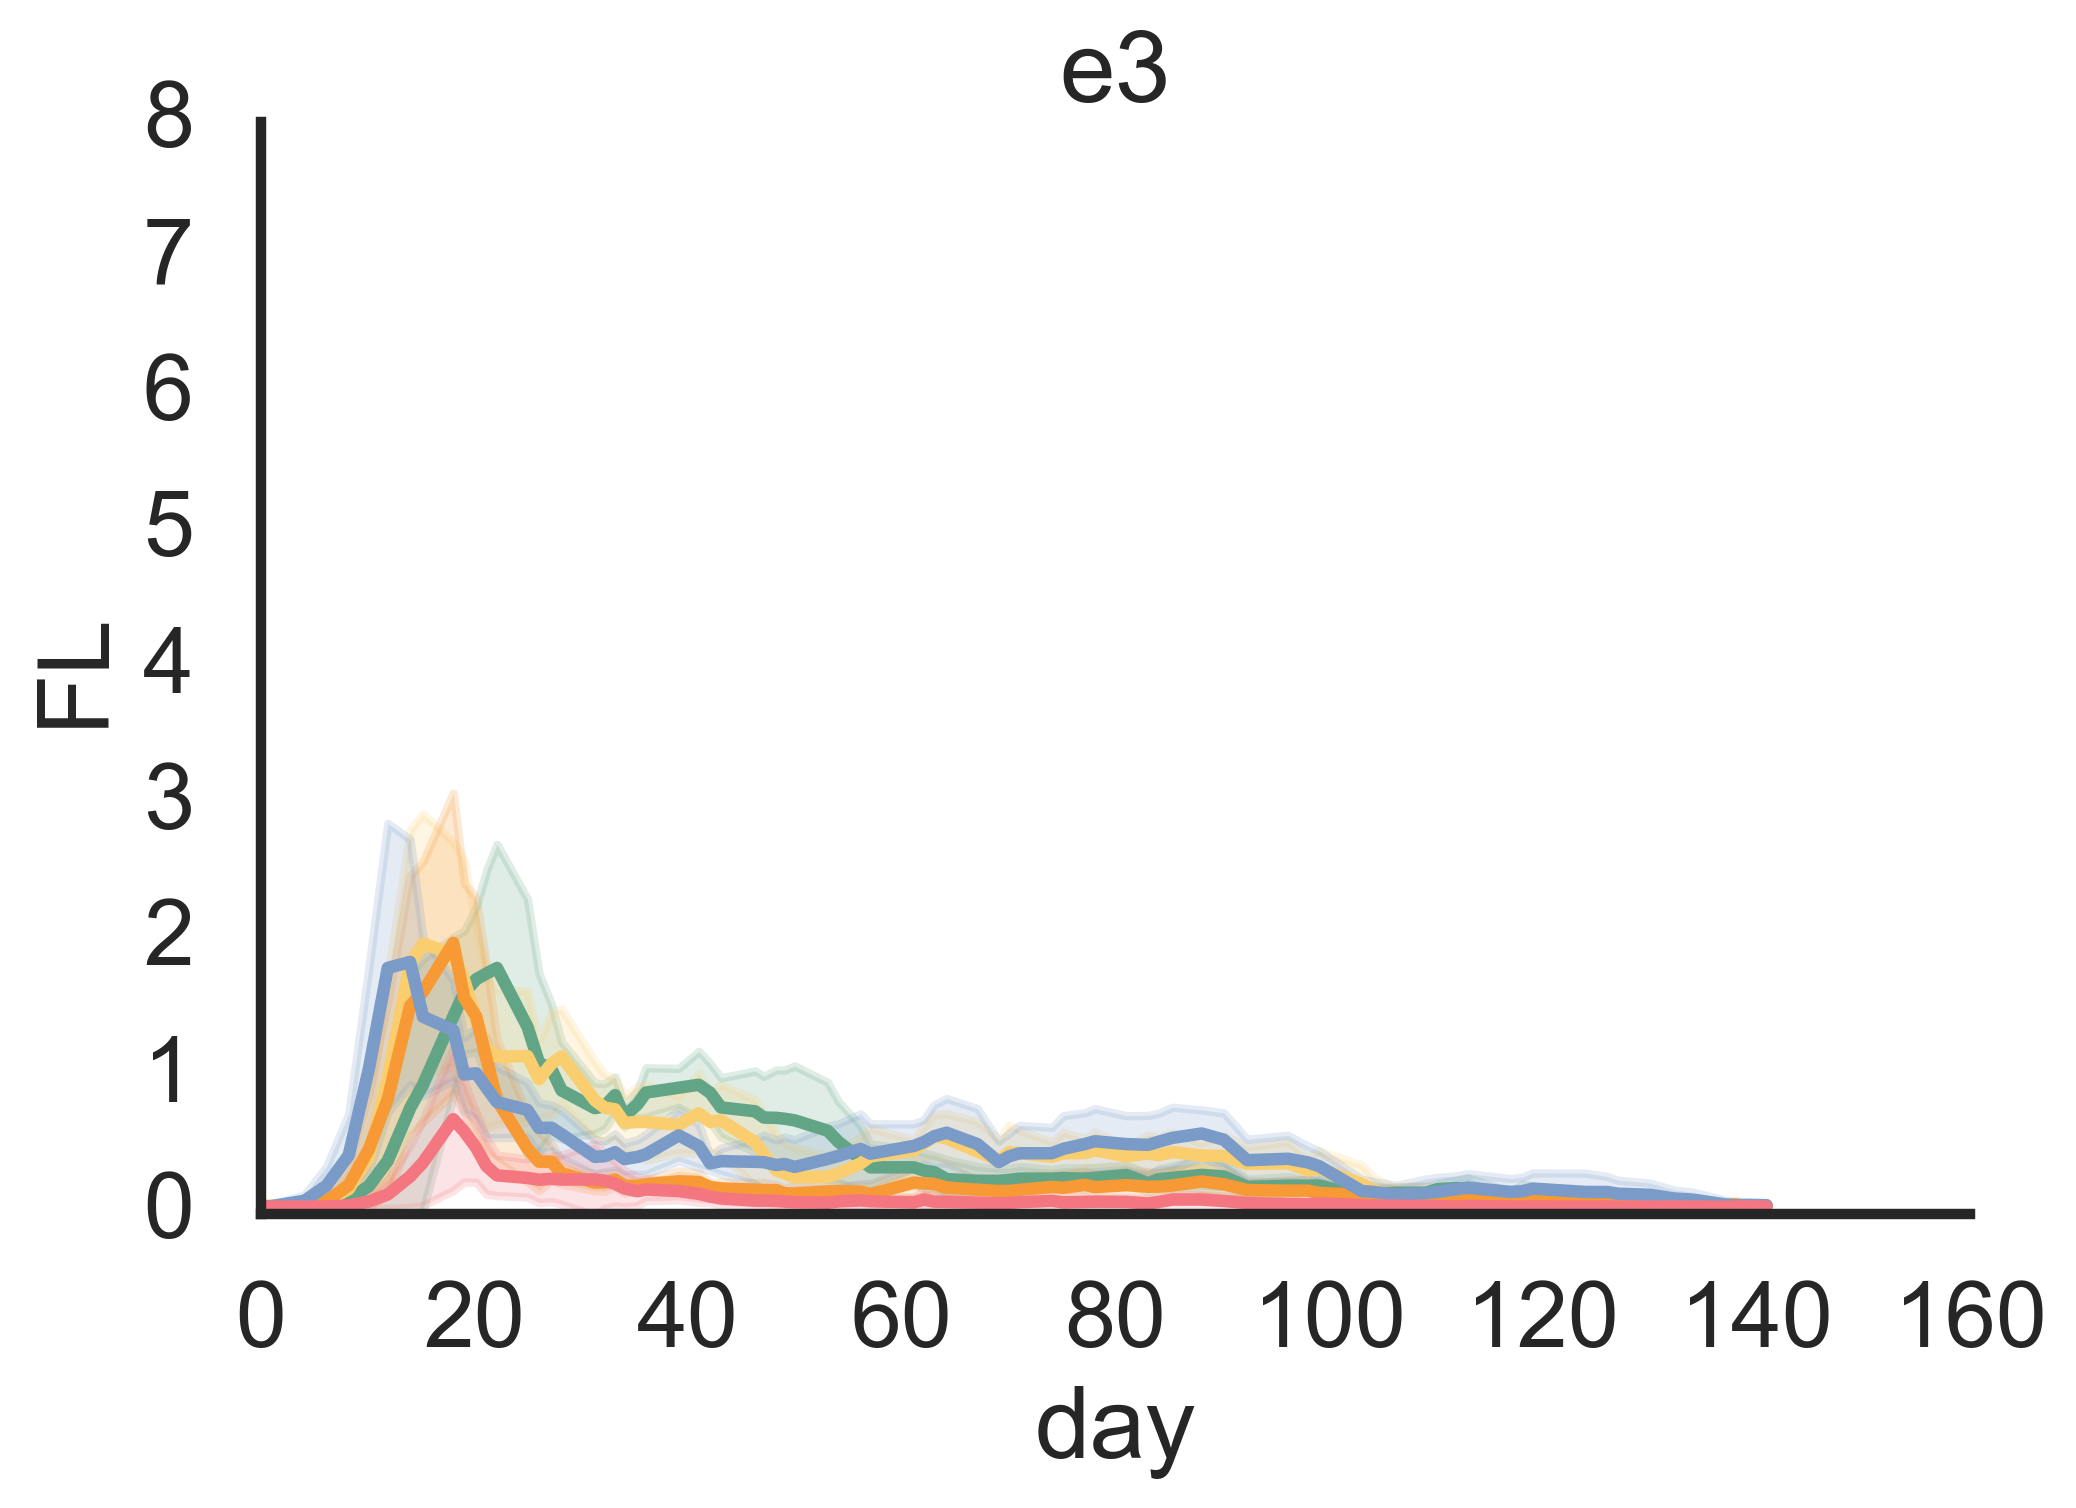

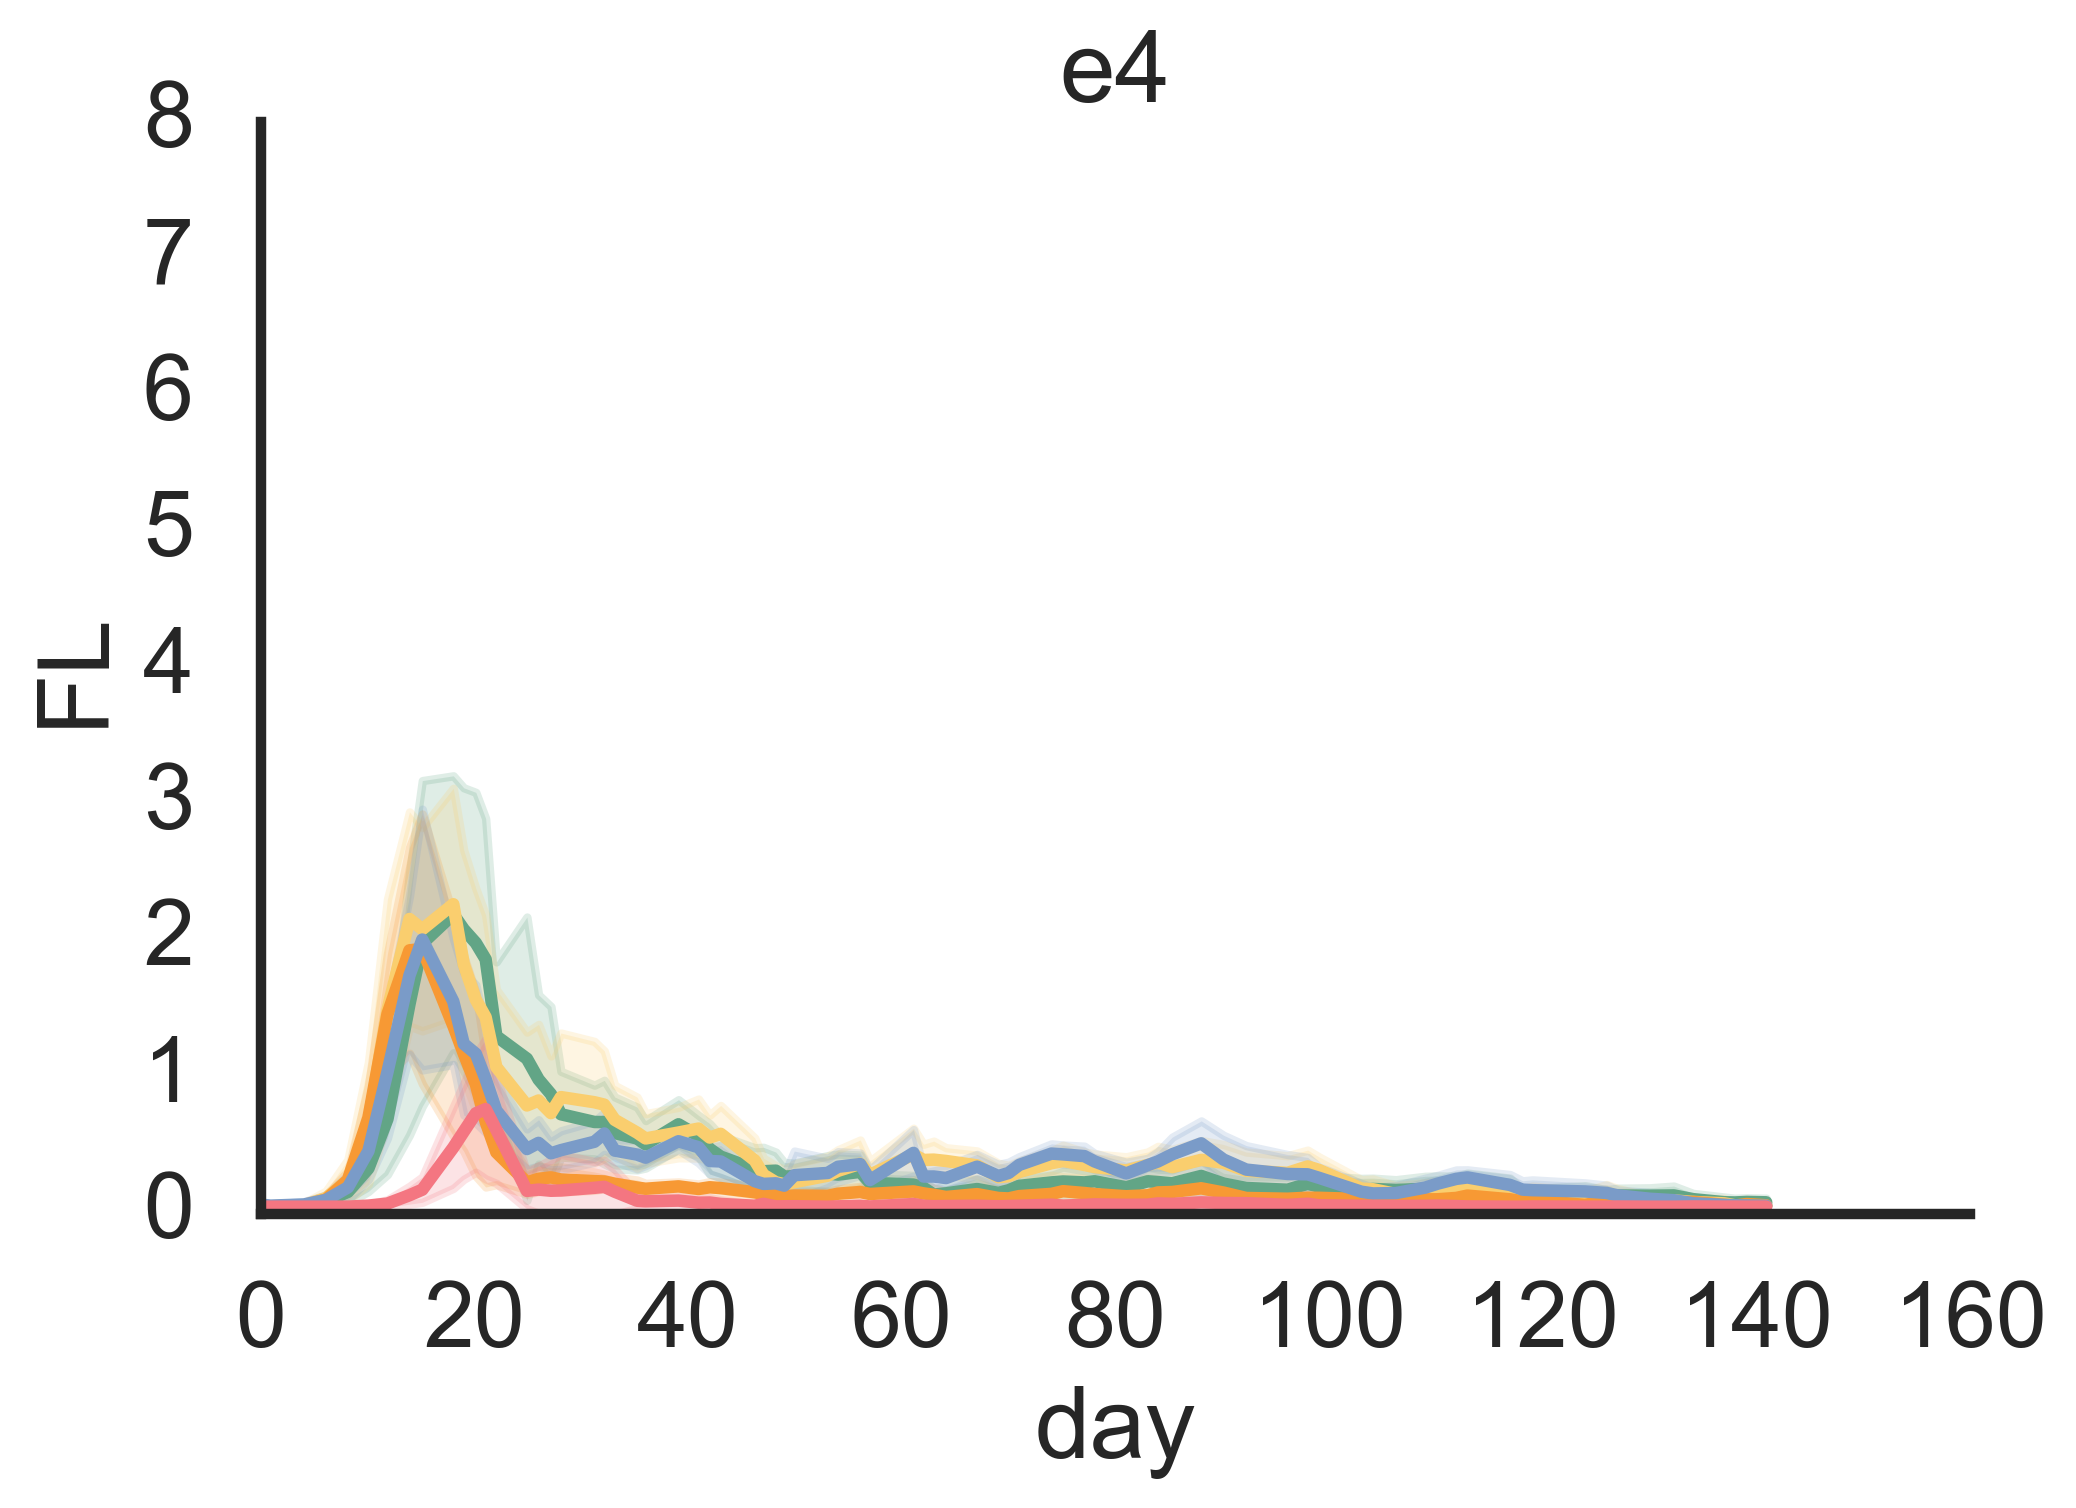

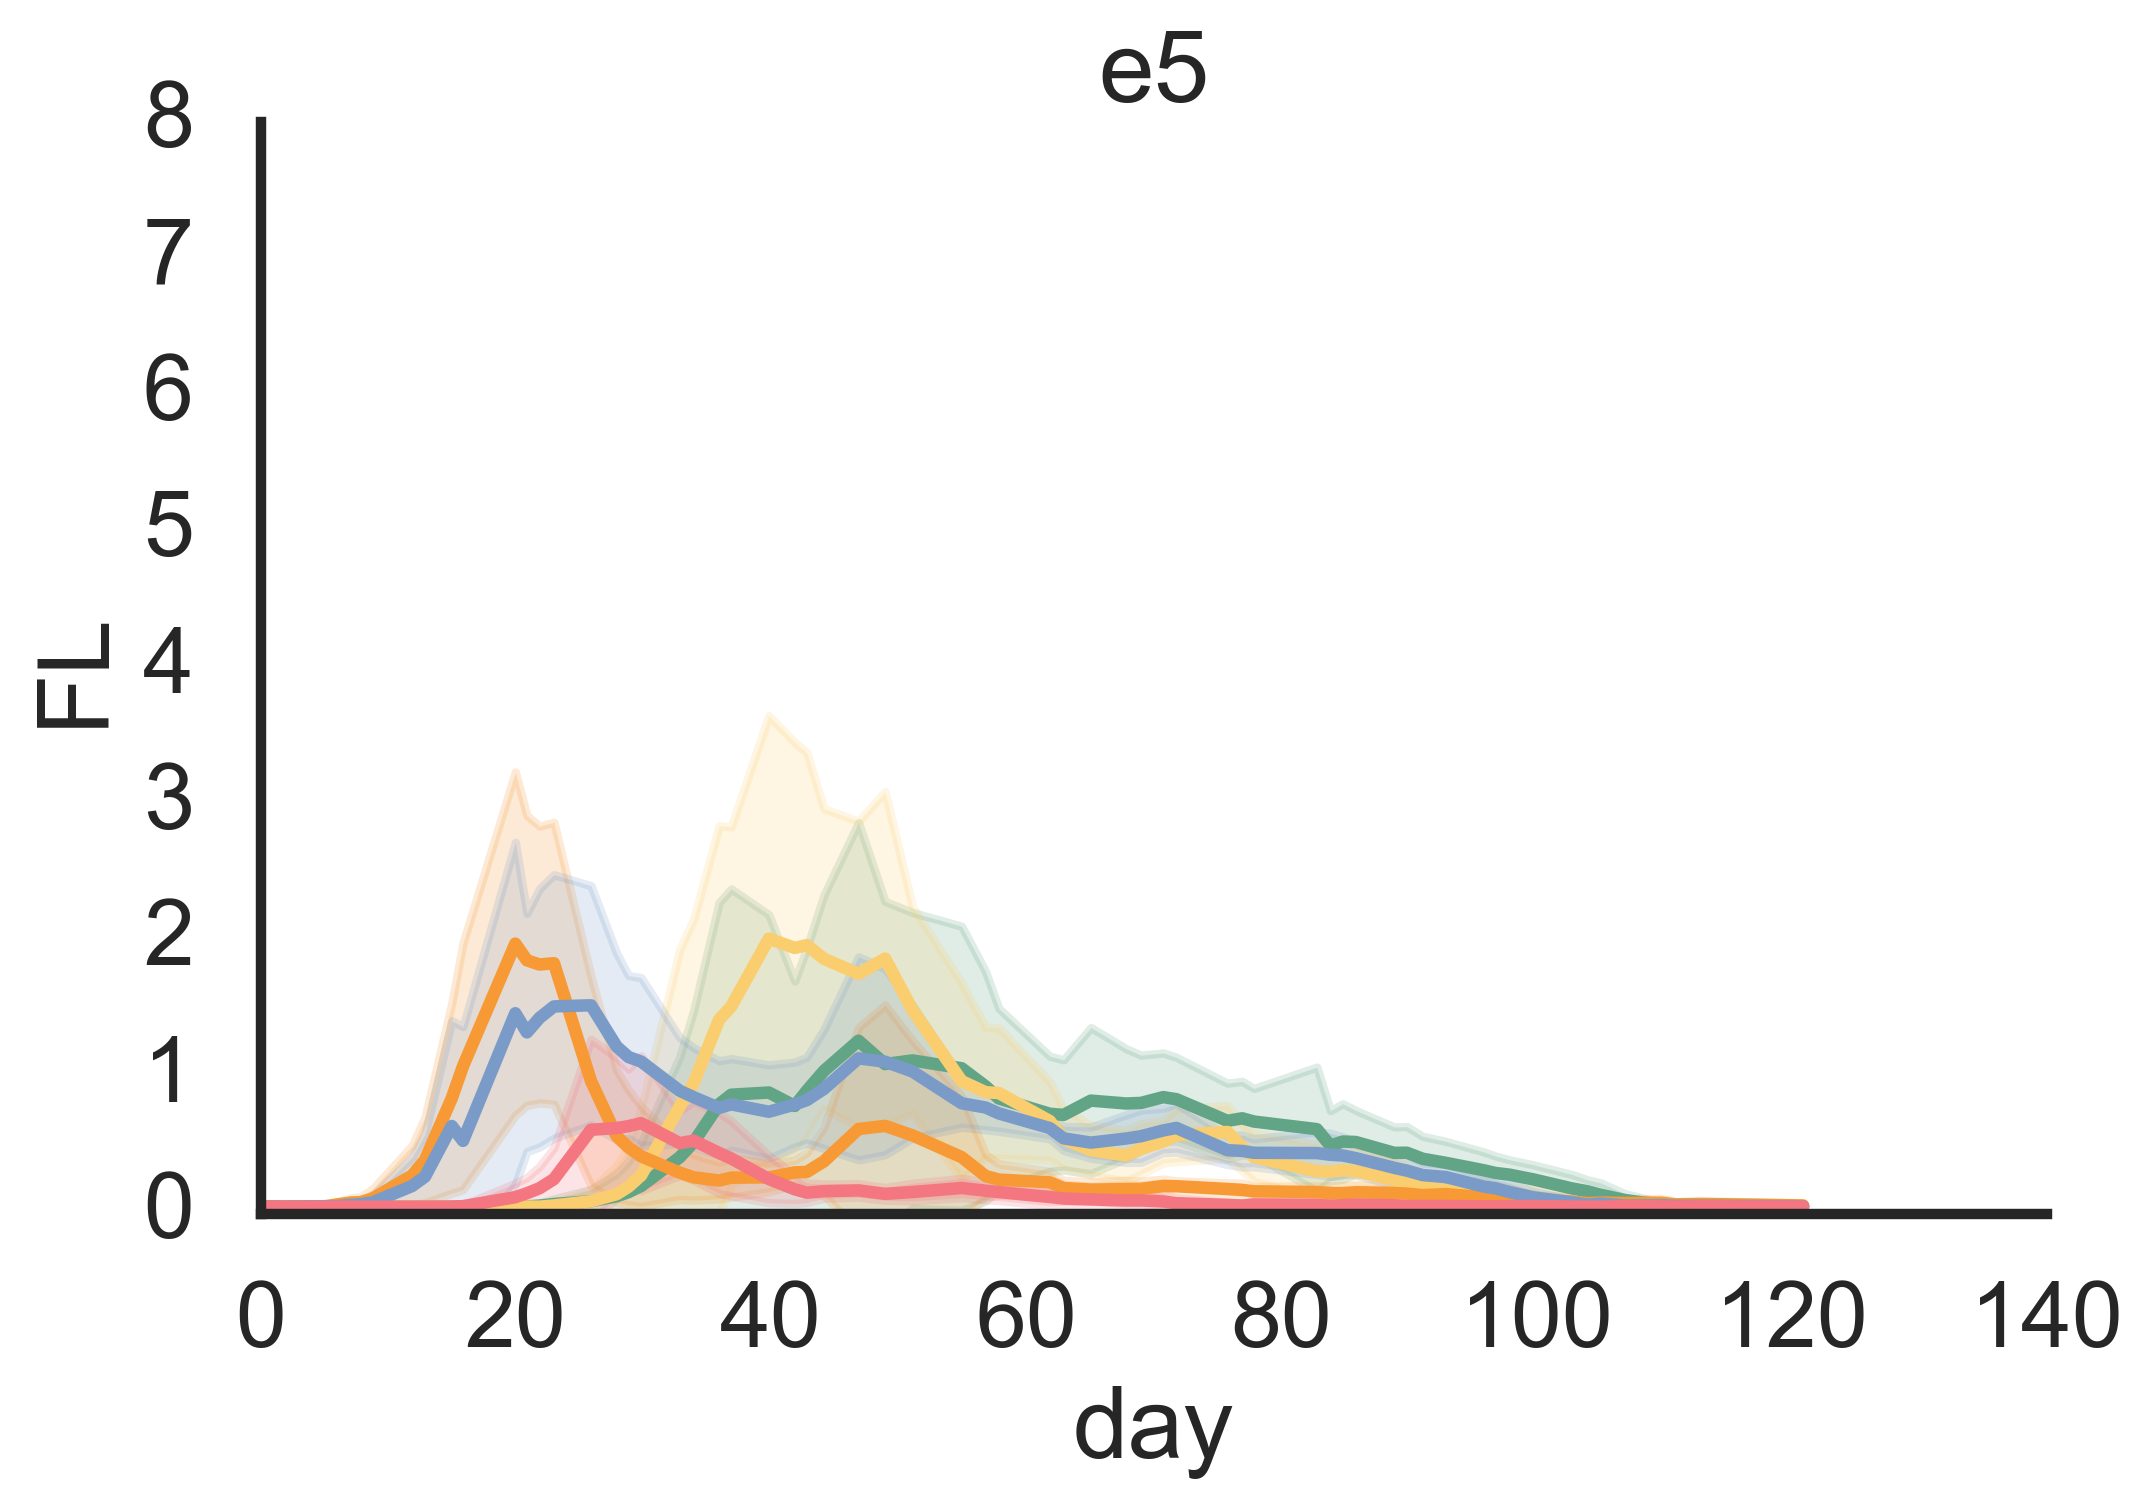

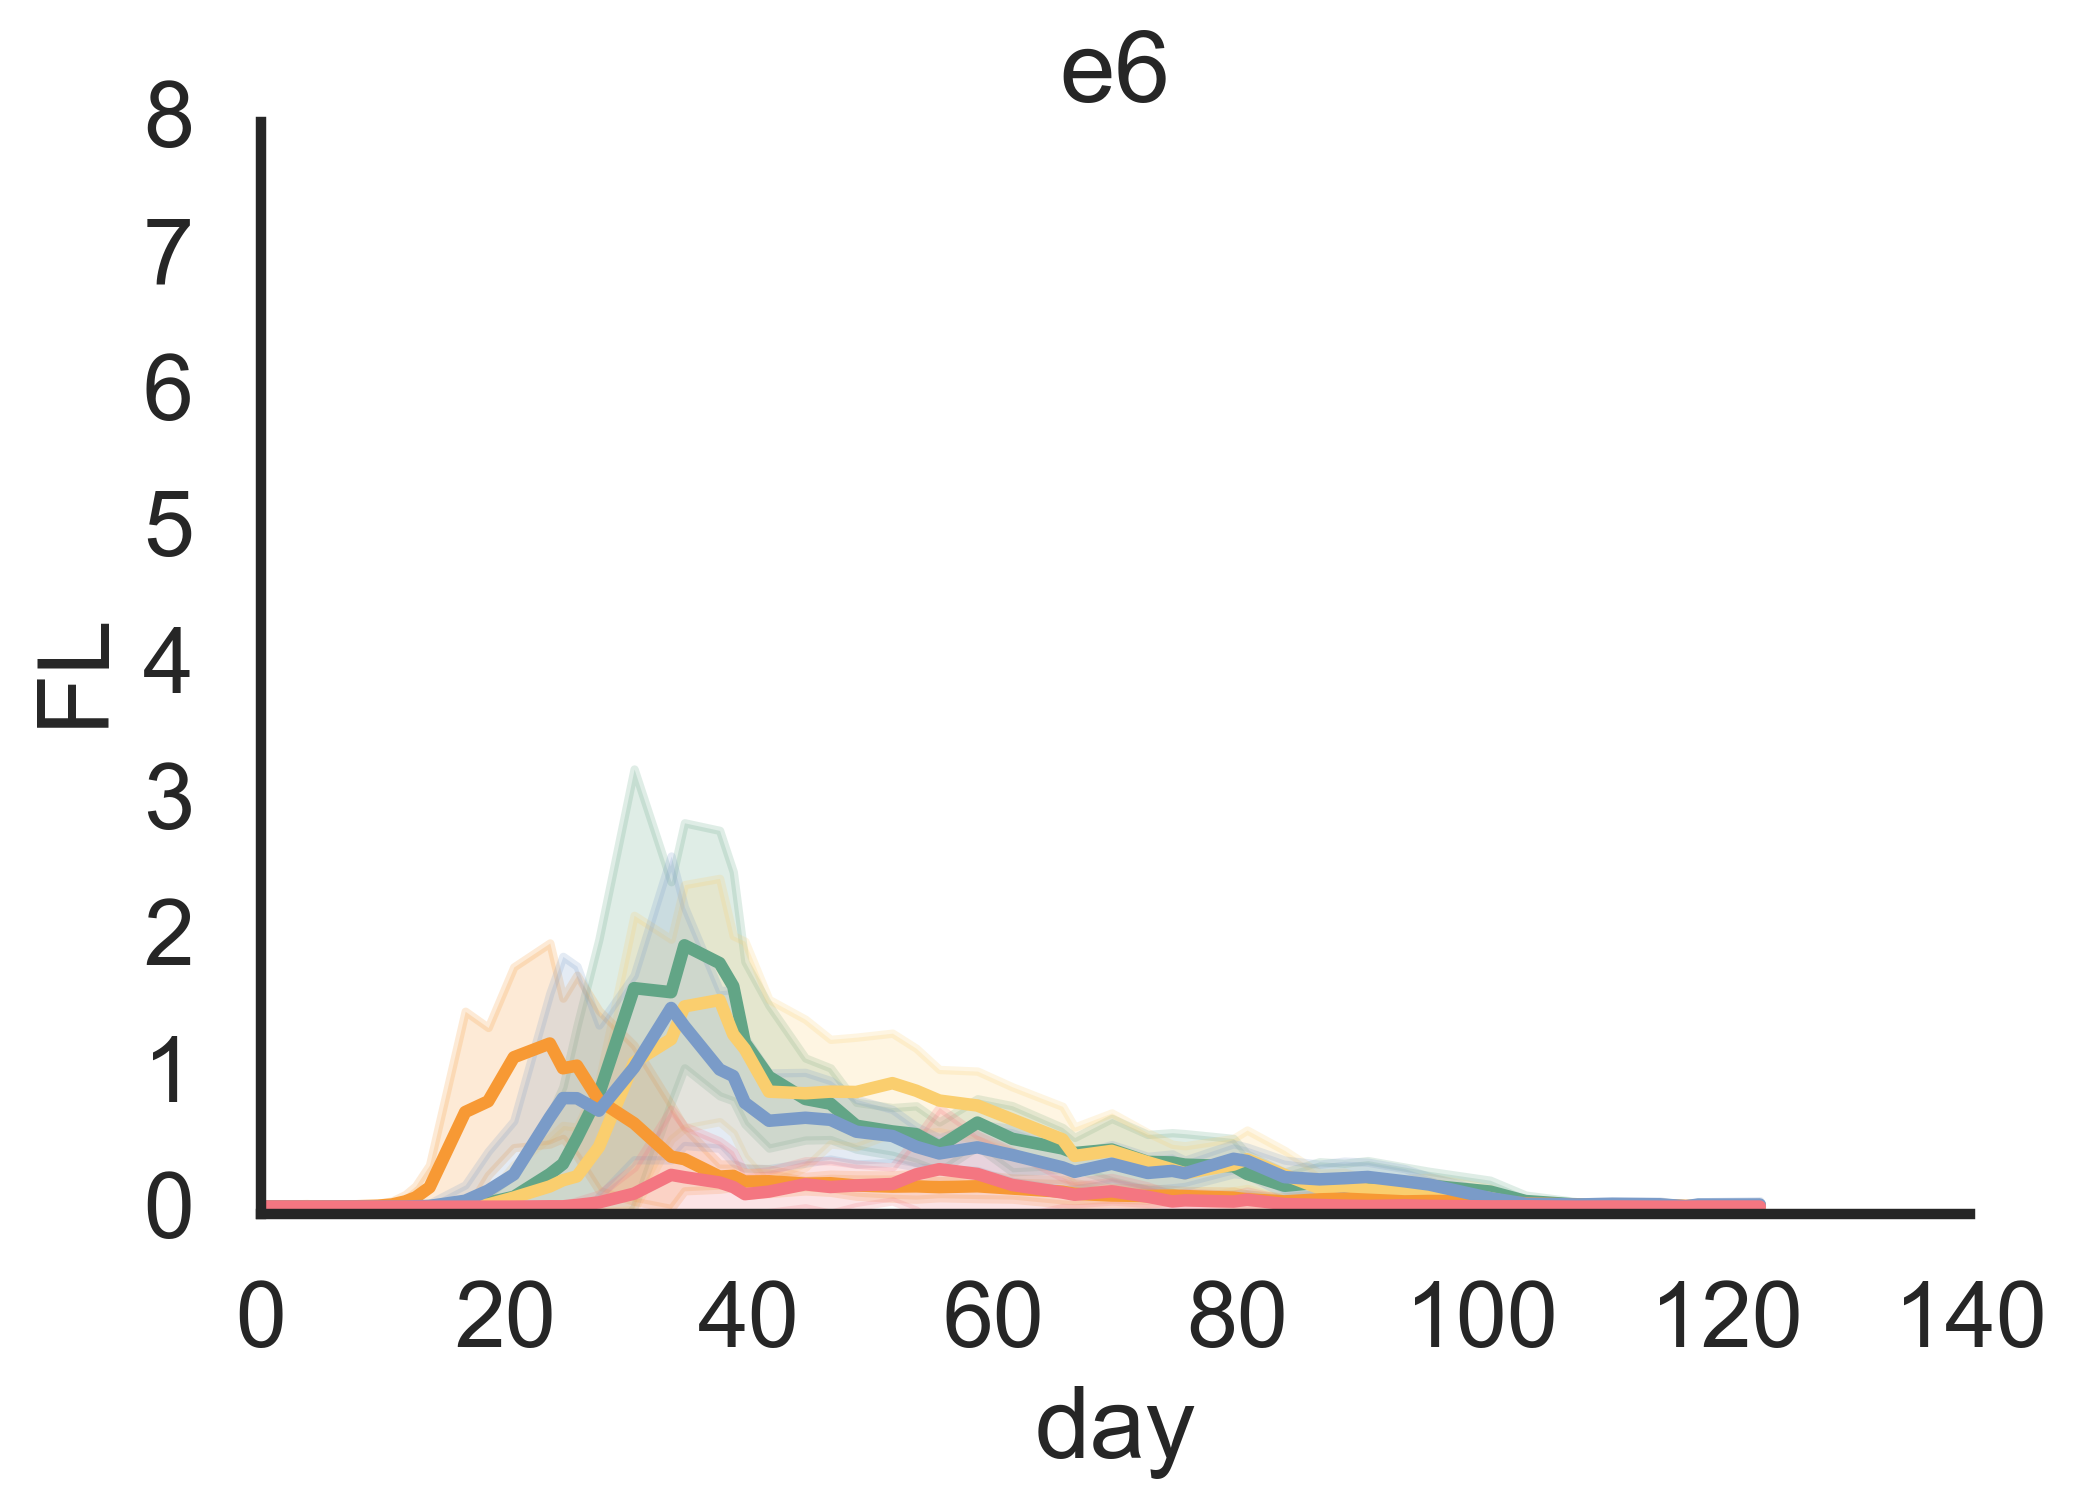

In [27]:
sns.set_context('poster')
for e in eorder:
    sns.relplot(data=dfc.loc[dfc.experiment.isin([e])], 
                x='day', y='FL', 
                hue='PRO', hue_order=porder, palette=ppallete,
                kind='line', ci='sd',
                legend=False,
                aspect=1.5,
               )
    plt.ylim(0,8)
    plt.title(e)

# experiment 1

# experiment 1 PCA

In [28]:
df1 = dfc.loc[dfc.experiment == 'e1']

In [29]:
df1['logFL'] = np.log(df1['FL'])

C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [30]:
df1.head()

day experiment sample     FL   PRO  ALT     culture  FL_orig  \
0  0.000000         e1     1A  0.133  MED4  1A3  Co_Culture    0.133   
1  0.715972         e1     1A  0.159  MED4  1A3  Co_Culture    0.159   
2  1.925694         e1     1A  0.155  MED4  1A3  Co_Culture    0.155   
3  2.831250         e1     1A  0.180  MED4  1A3  Co_Culture    0.180   
4  6.674306         e1     1A  0.632  MED4  1A3  Co_Culture    0.632   

      logFL  cumsumFL  cumsumlogFL  zscoreFL  diffFL  difflogFL   diffday  \
0 -2.017406     0.133    -2.017406 -0.588889     NaN        NaN       NaN   
1 -1.838851     0.292    -3.856257 -0.575917   0.026   0.178555  0.715972   
2 -1.864330     0.447    -5.720587 -0.577913  -0.004  -0.025479  1.209722   
3 -1.714798     0.627    -7.435386 -0.565440   0.025   0.149532  0.905556   
4 -0.458866     1.259    -7.894252 -0.339936   0.452   1.255933  3.843056   

     rateFL  ratelogFL experiment_sample  
0       NaN        NaN            e1, 1A  
1  0.036314   0.249388            e1, 1A  
2 -0.003307  -0.021062            e1, 1A  
3  0.027607   0.165127            e1, 1A  
4  0.117615   0.326806            e1, 1A

In [31]:
df1 = dfc.loc[dfc.experiment == 'e1']
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(df1, value_col='FL', cumsummode=True)
metadf = cp.get_meta(df1)
#metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col, n_components=6)

Variance percent explained
 [0.89101301 0.06160666 0.02534383 0.01306722 0.00353969 0.00179602]


In [32]:
dfpca.head()

PCA1      PCA2      PCA3      PCA4      PCA5      PCA6  \
0  2.568459 -2.215038  0.433851 -1.320479  0.433194 -0.063128   
1  1.639942 -2.488153 -0.064320 -1.349127  0.595700 -0.153142   
2  2.647706 -2.160370  0.601788 -1.178073  0.642354 -0.194281   
3 -3.319633 -0.740389  2.983771 -0.400349  0.340498  0.658317   
4 -1.574699 -0.004453  3.458784  0.471031  0.420842  0.424429   

  experiment_sample experiment sample      PRO  ALT     culture        FL  
0           e1, 10A         e1    10A  MIT0604   DE  Co_Culture  0.744932  
1           e1, 10B         e1    10B  MIT0604   DE  Co_Culture  0.801284  
2           e1, 10C         e1    10C  MIT0604   DE  Co_Culture  0.736932  
3           e1, 11A         e1    11A     MED4  DE1  Co_Culture  0.888864  
4           e1, 11B         e1    11B     MED4  DE1  Co_Culture  0.824534

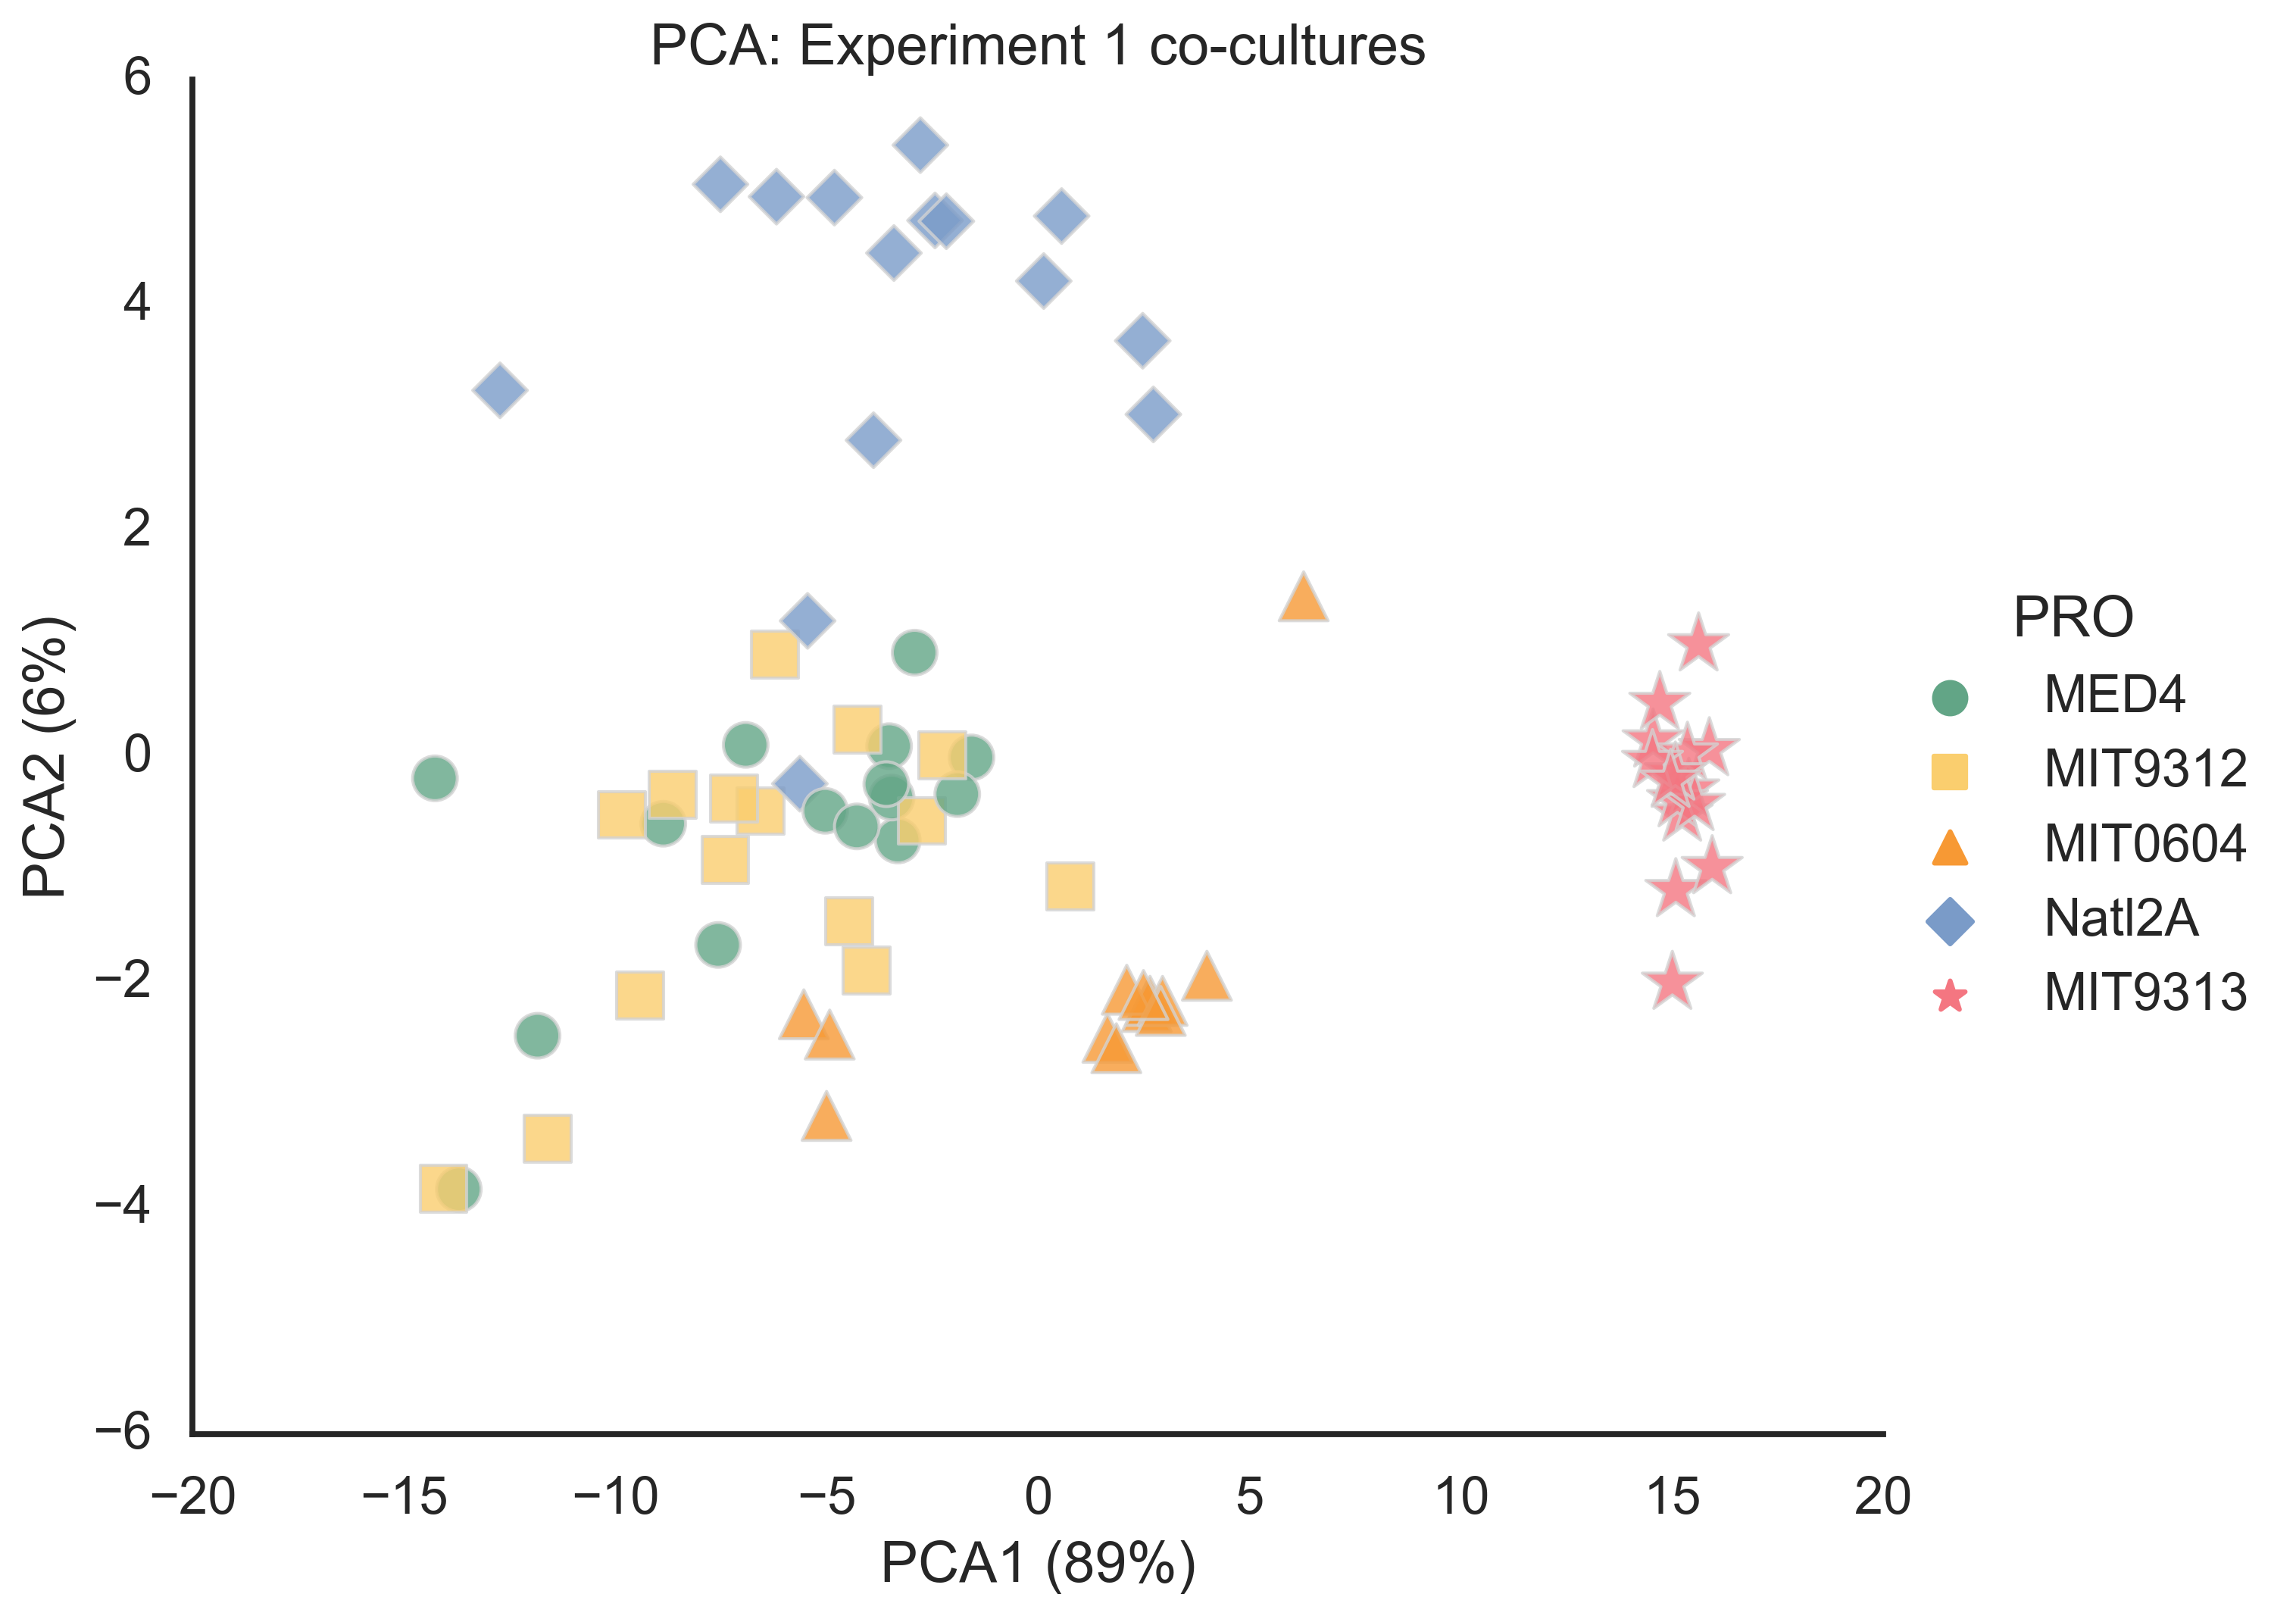

In [43]:

sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='culture', 
            style='PRO',
            style_order=porder, markers=pmarkers,
            size='PRO', size_order=porder,
                 sizes=psizes, 
                 alpha=0.8, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey', 
           )
plt.xlabel('PCA1 (89%)')
plt.ylabel('PCA2 (6%)')
plt.title('PCA: Experiment 1 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([100])

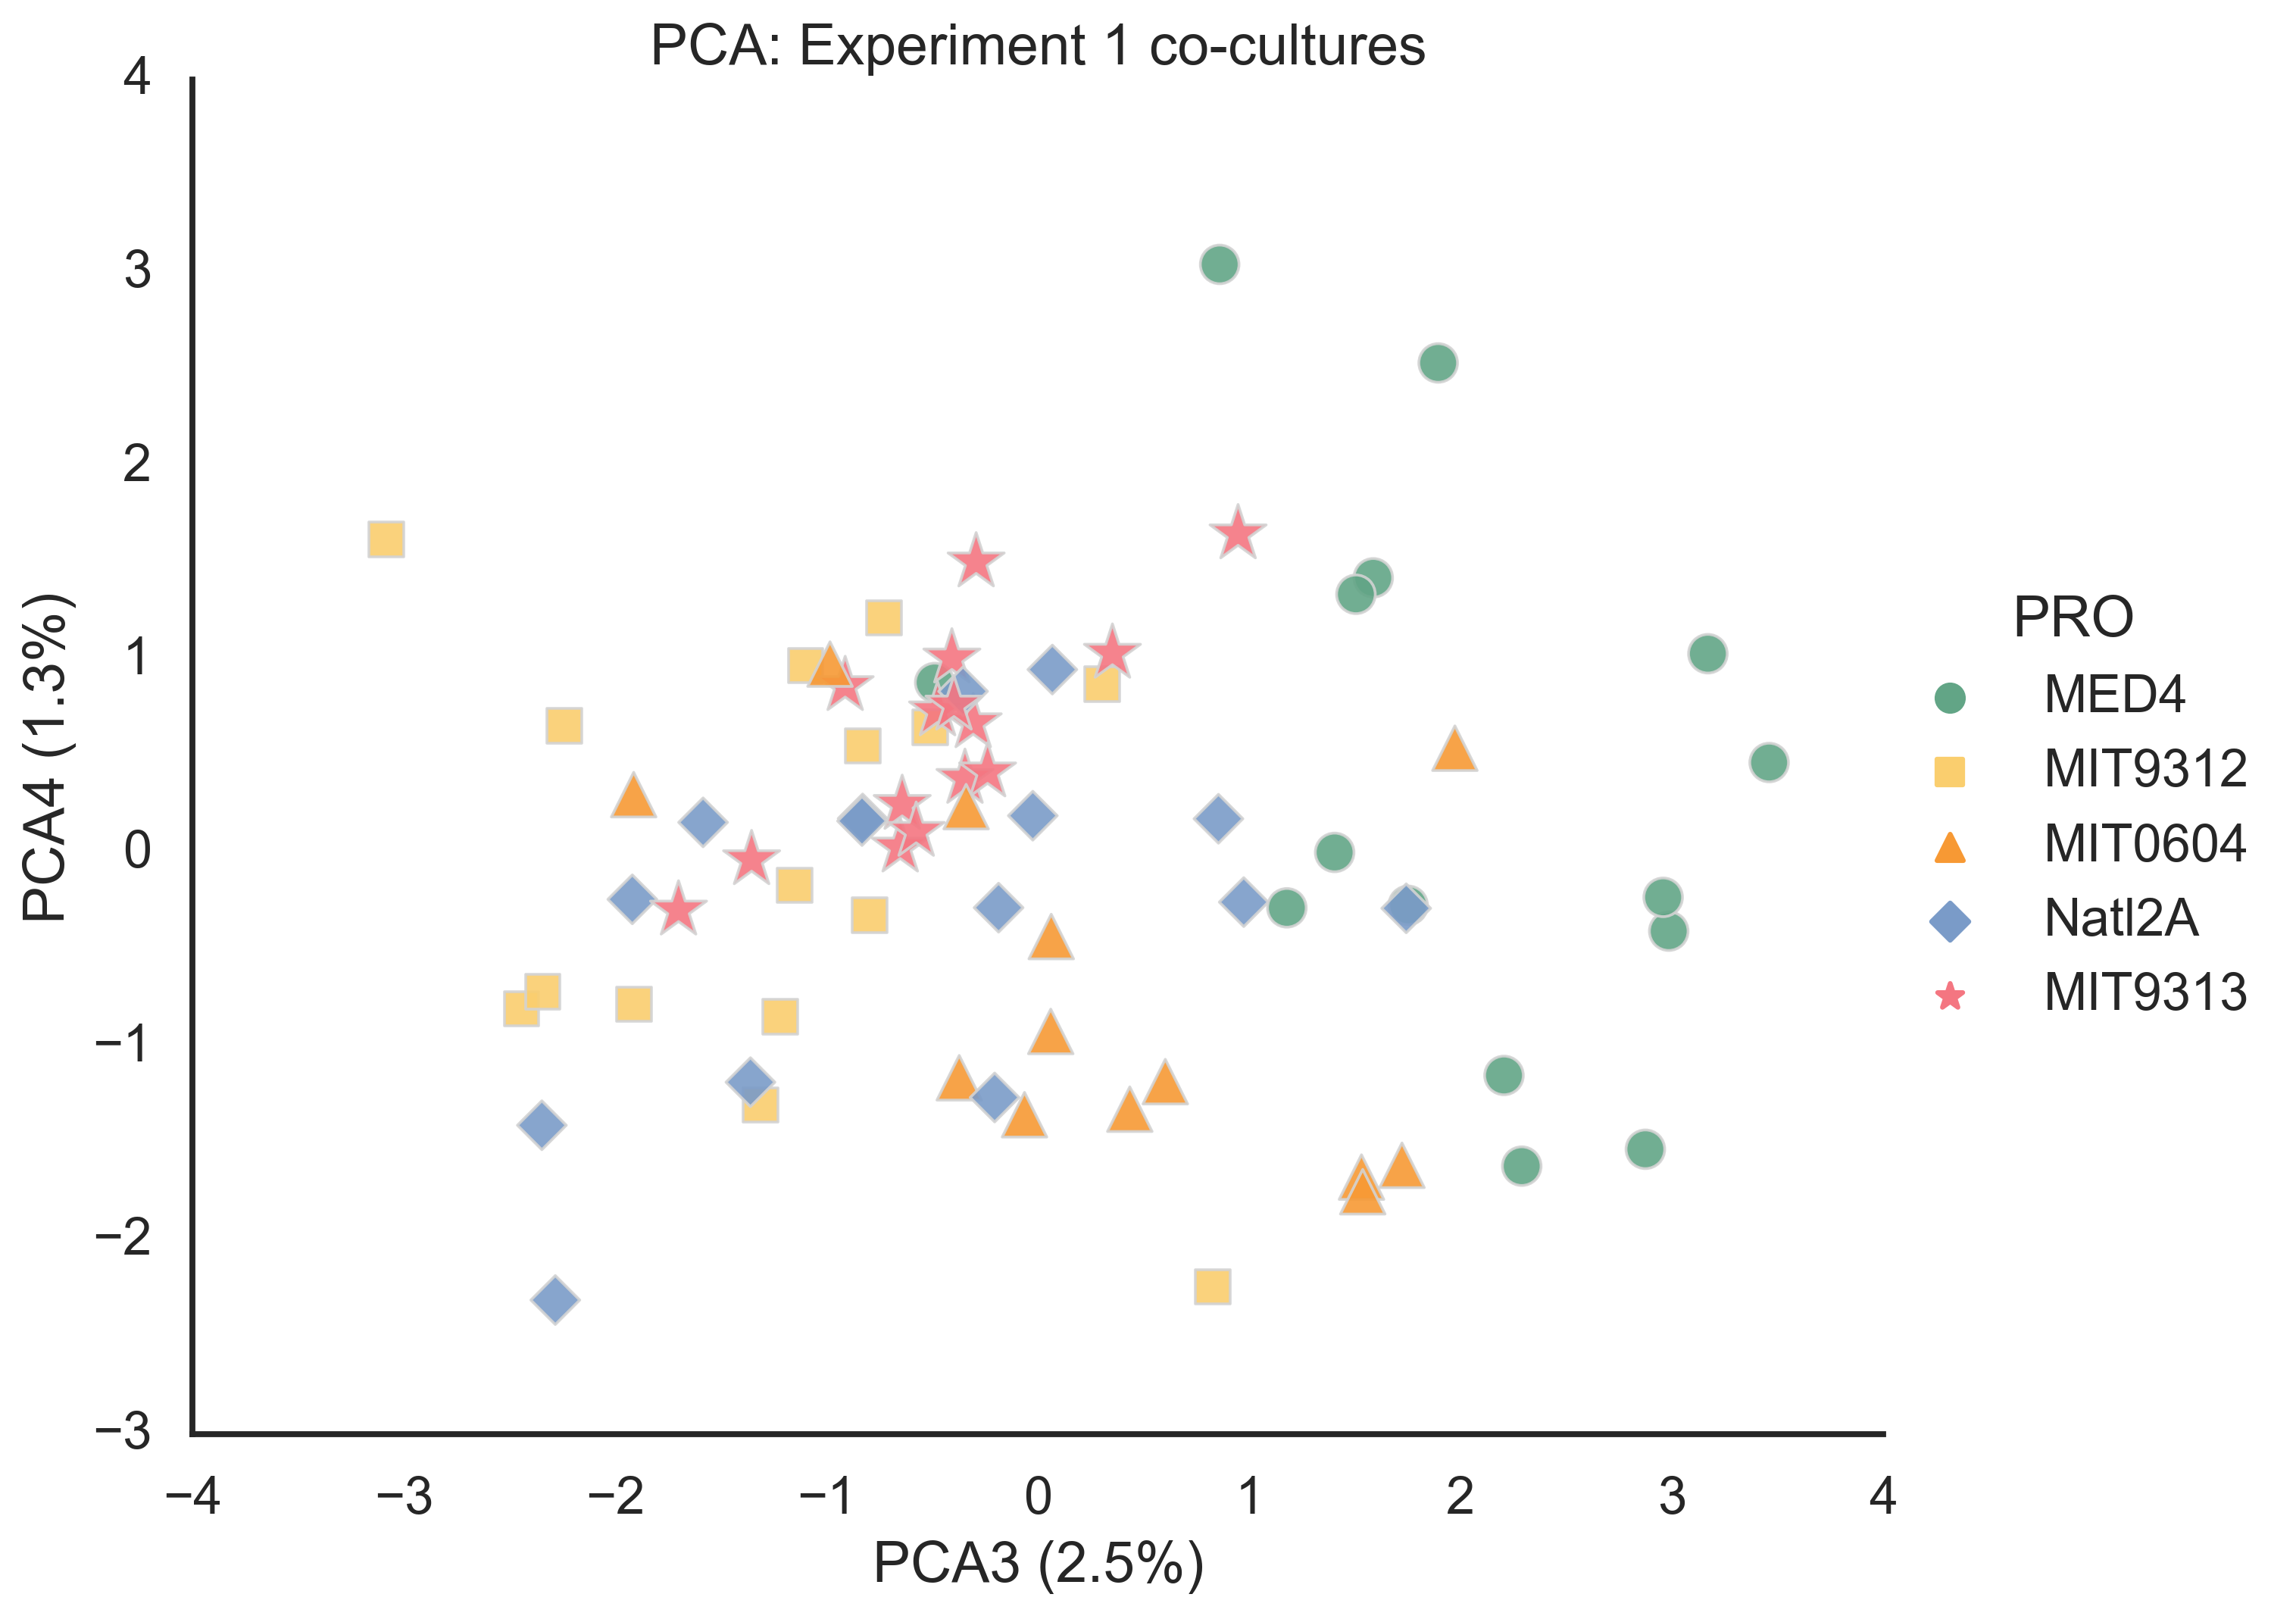

In [34]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA3', y='PCA4', hue='PRO', 
            #style='culture', 
            style='PRO',
            style_order=porder, markers=pmarkers,
            size='PRO', size_order=porder,
                 sizes=psizes, 
                 alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey', 
           )
plt.xlabel('PCA3 (2.5%)')
plt.ylabel('PCA4 (1.3%)')
plt.title('PCA: Experiment 1 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

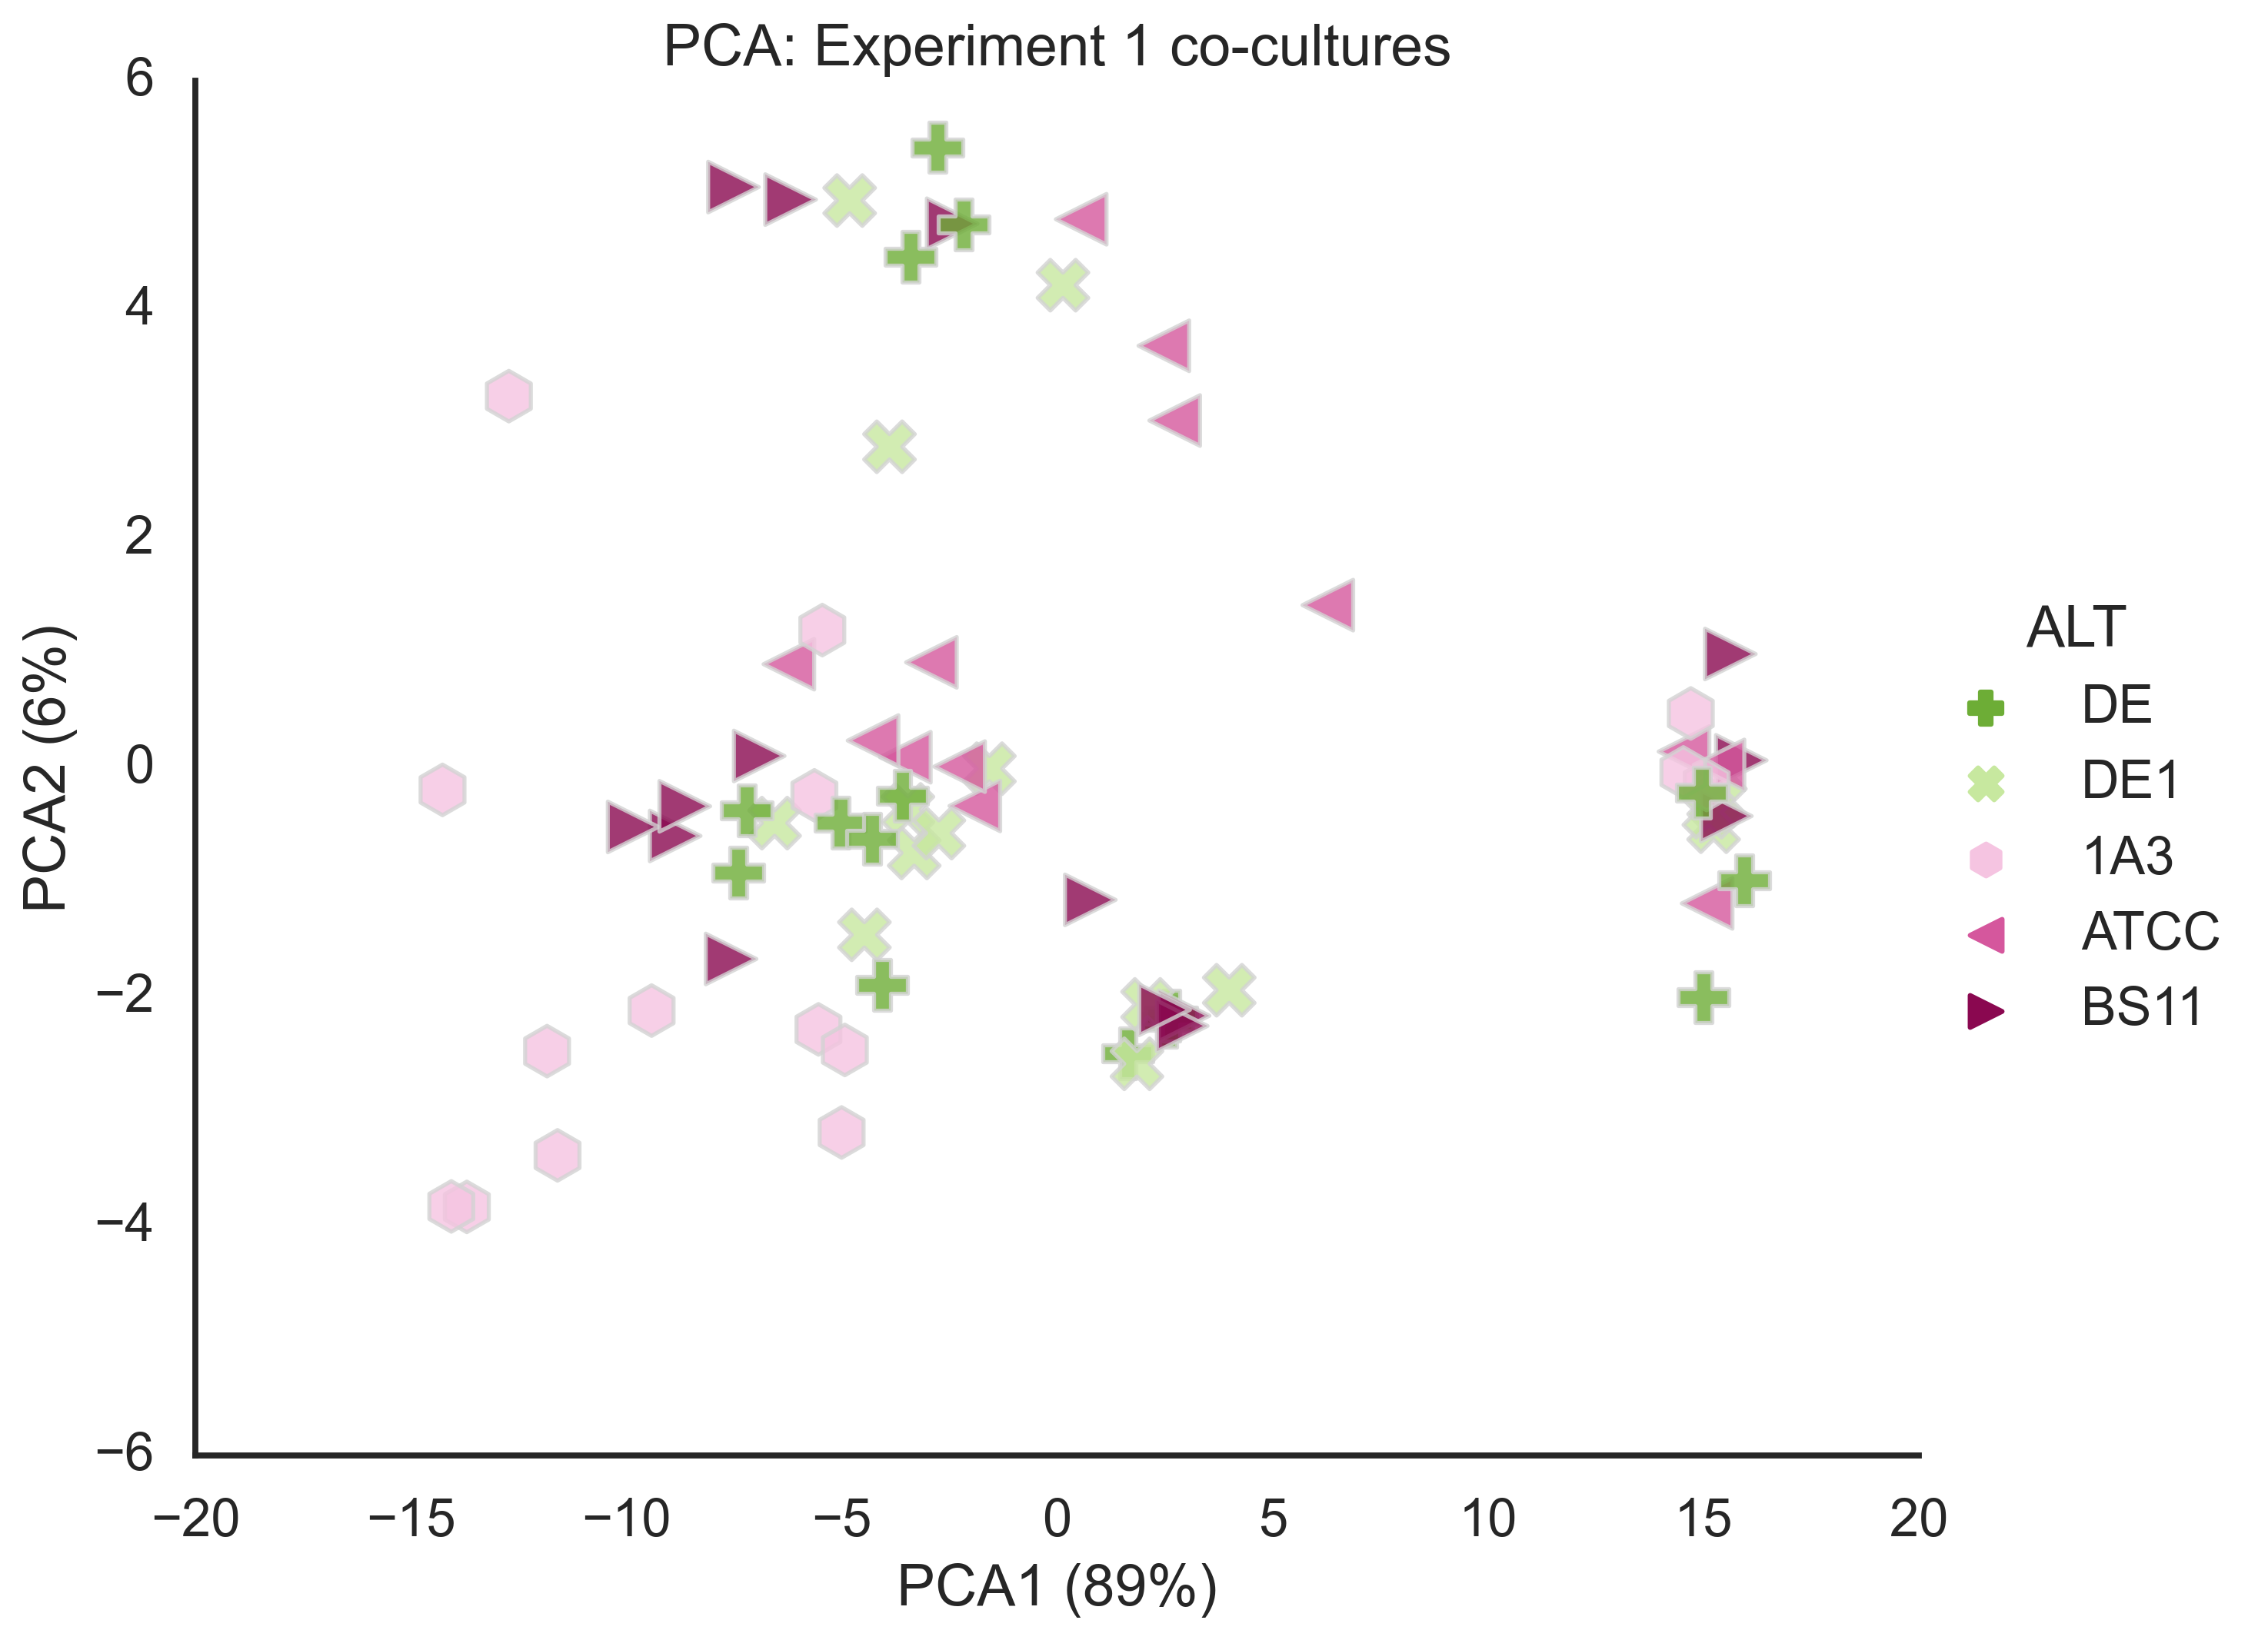

In [42]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='culture', 
            style='ALT',
            style_order=aorder, #markers=['p','h','<','v','>'],
                 markers=amarkers,
            s=250, alpha=0.8, 
                 height=7, aspect=1.2,
            palette=apallete, 
                 hue_order=aorder ,edgecolor='lightgrey', 
                 #facet_kws=dict(subplot_kws=dict(fillstyle='none')) #fillstyle='none',
                 #facecolors= 'none'
           )
plt.xlabel('PCA1 (89%)')
plt.ylabel('PCA2 (6%)')
plt.title('PCA: Experiment 1 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([100])

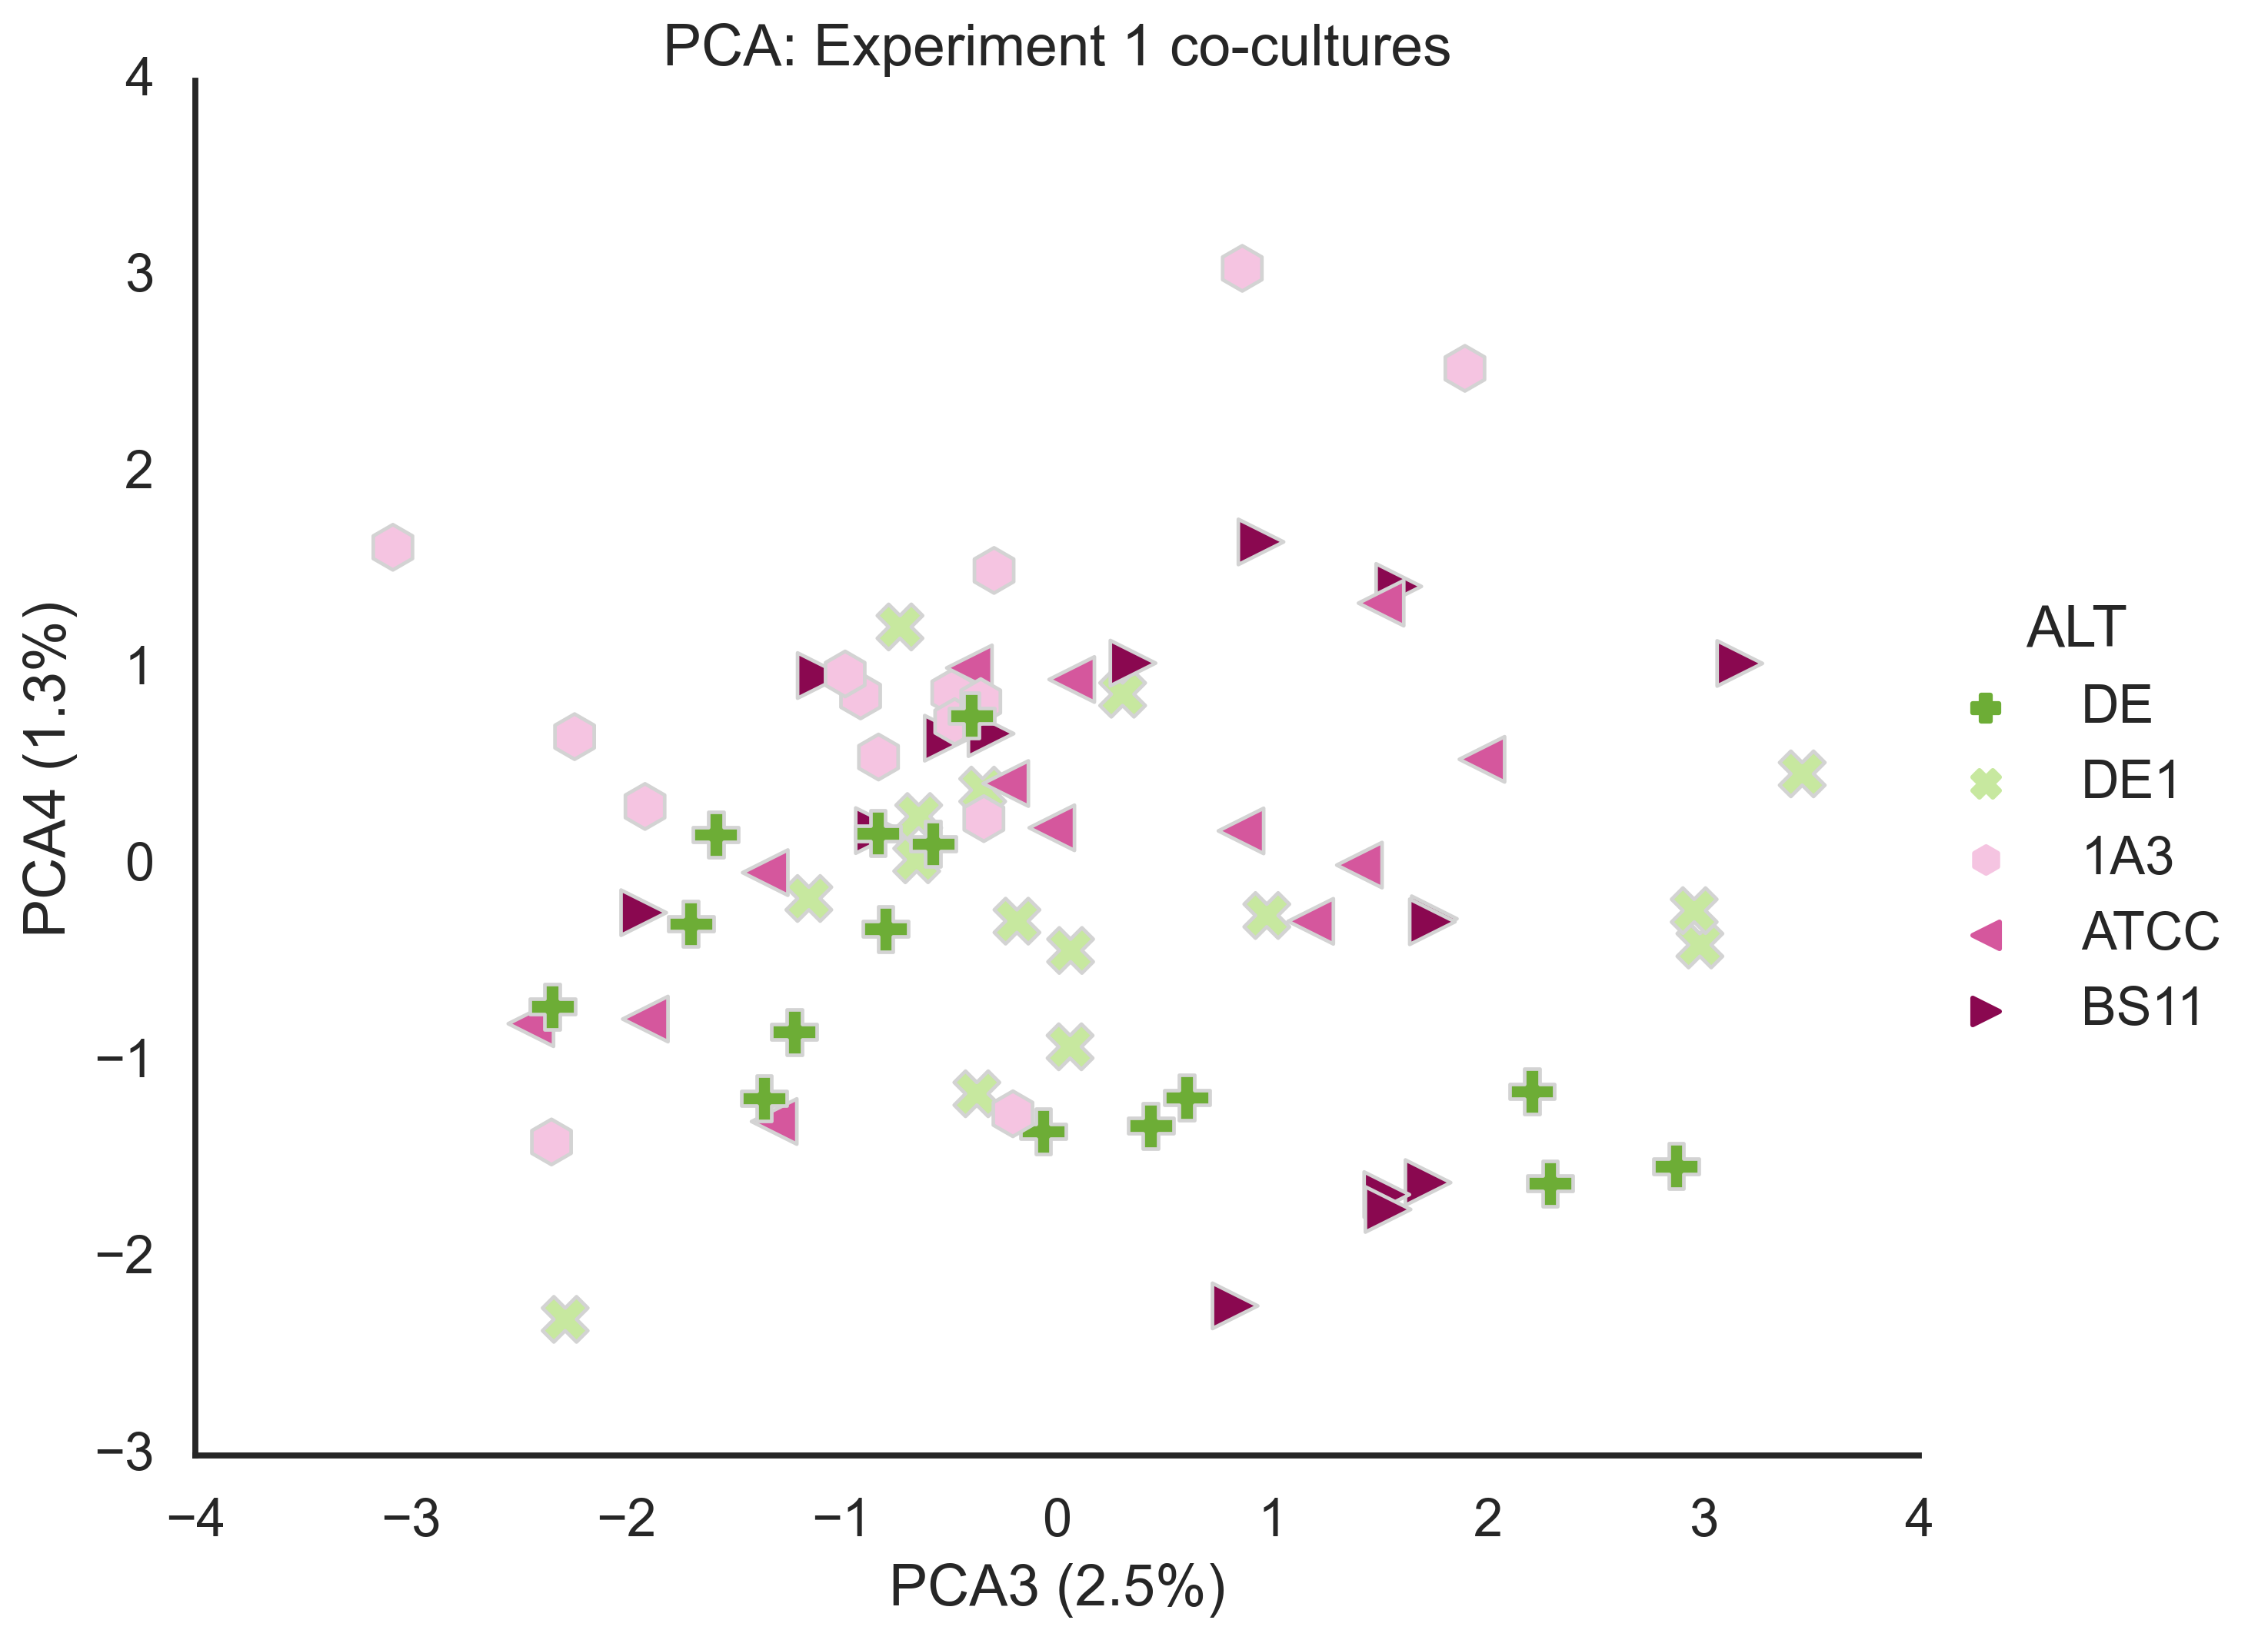

In [36]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA3', y='PCA4', hue='ALT', 
            #style='culture', 
            style='ALT',
            style_order=aorder, #markers=['p','h','<','v','>'],
                 markers=amarkers,
            s=200, #alpha=0.9, 
                 height=7, aspect=1.2,
            palette=apallete, 
                 hue_order=aorder ,edgecolor='lightgrey', 
                 #facet_kws=dict(subplot_kws=dict(fillstyle='none')) #fillstyle='none',
                 #facecolors= 'none'
           )
plt.xlabel('PCA3 (2.5%)')
plt.ylabel('PCA4 (1.3%)')
plt.title('PCA: Experiment 1 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

In [37]:
df3 = dfc.loc[dfc.experiment == 'e3']
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(df3, value_col='FL', cumsummode=True)
metadf = cp.get_meta(df3)
#metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.86215634 0.06888719]


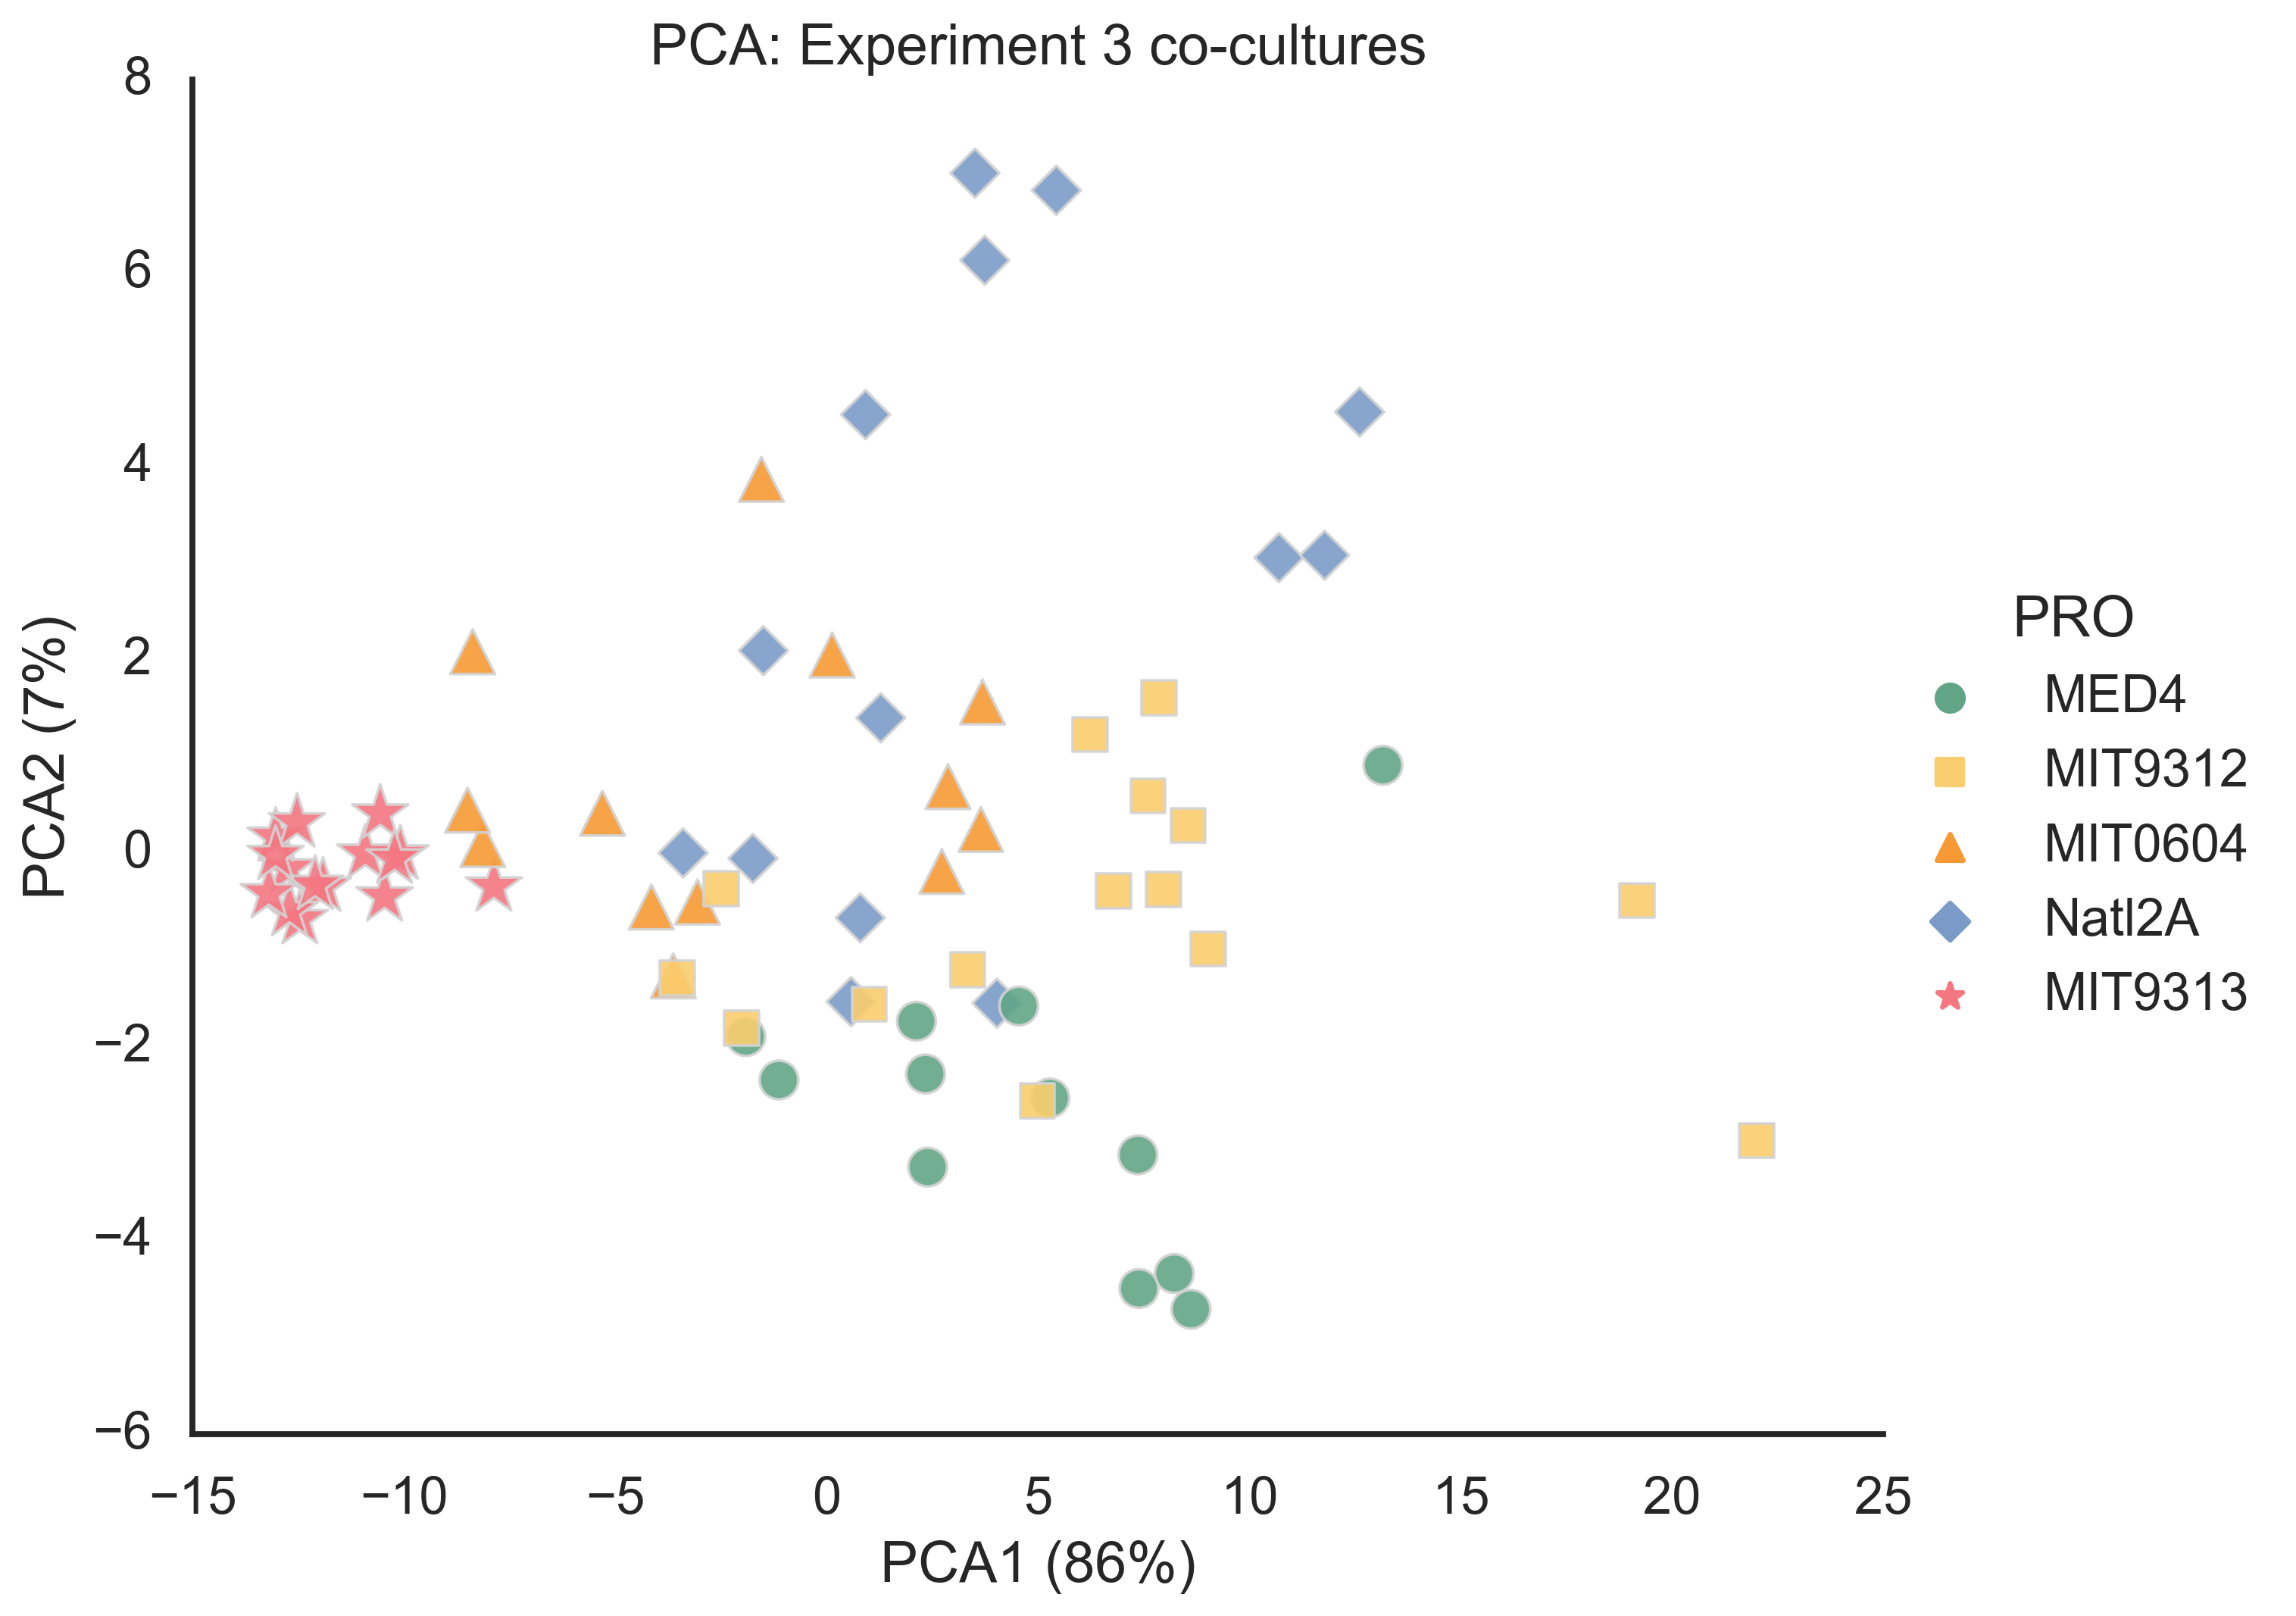

In [38]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='culture', 
            style='PRO',
            style_order=porder, markers=pmarkers,
            size='PRO', size_order=porder,
                 sizes=psizes, 
                 alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey', 
           )
plt.xlabel('PCA1 (86%)')
plt.ylabel('PCA2 (7%)')
plt.title('PCA: Experiment 3 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

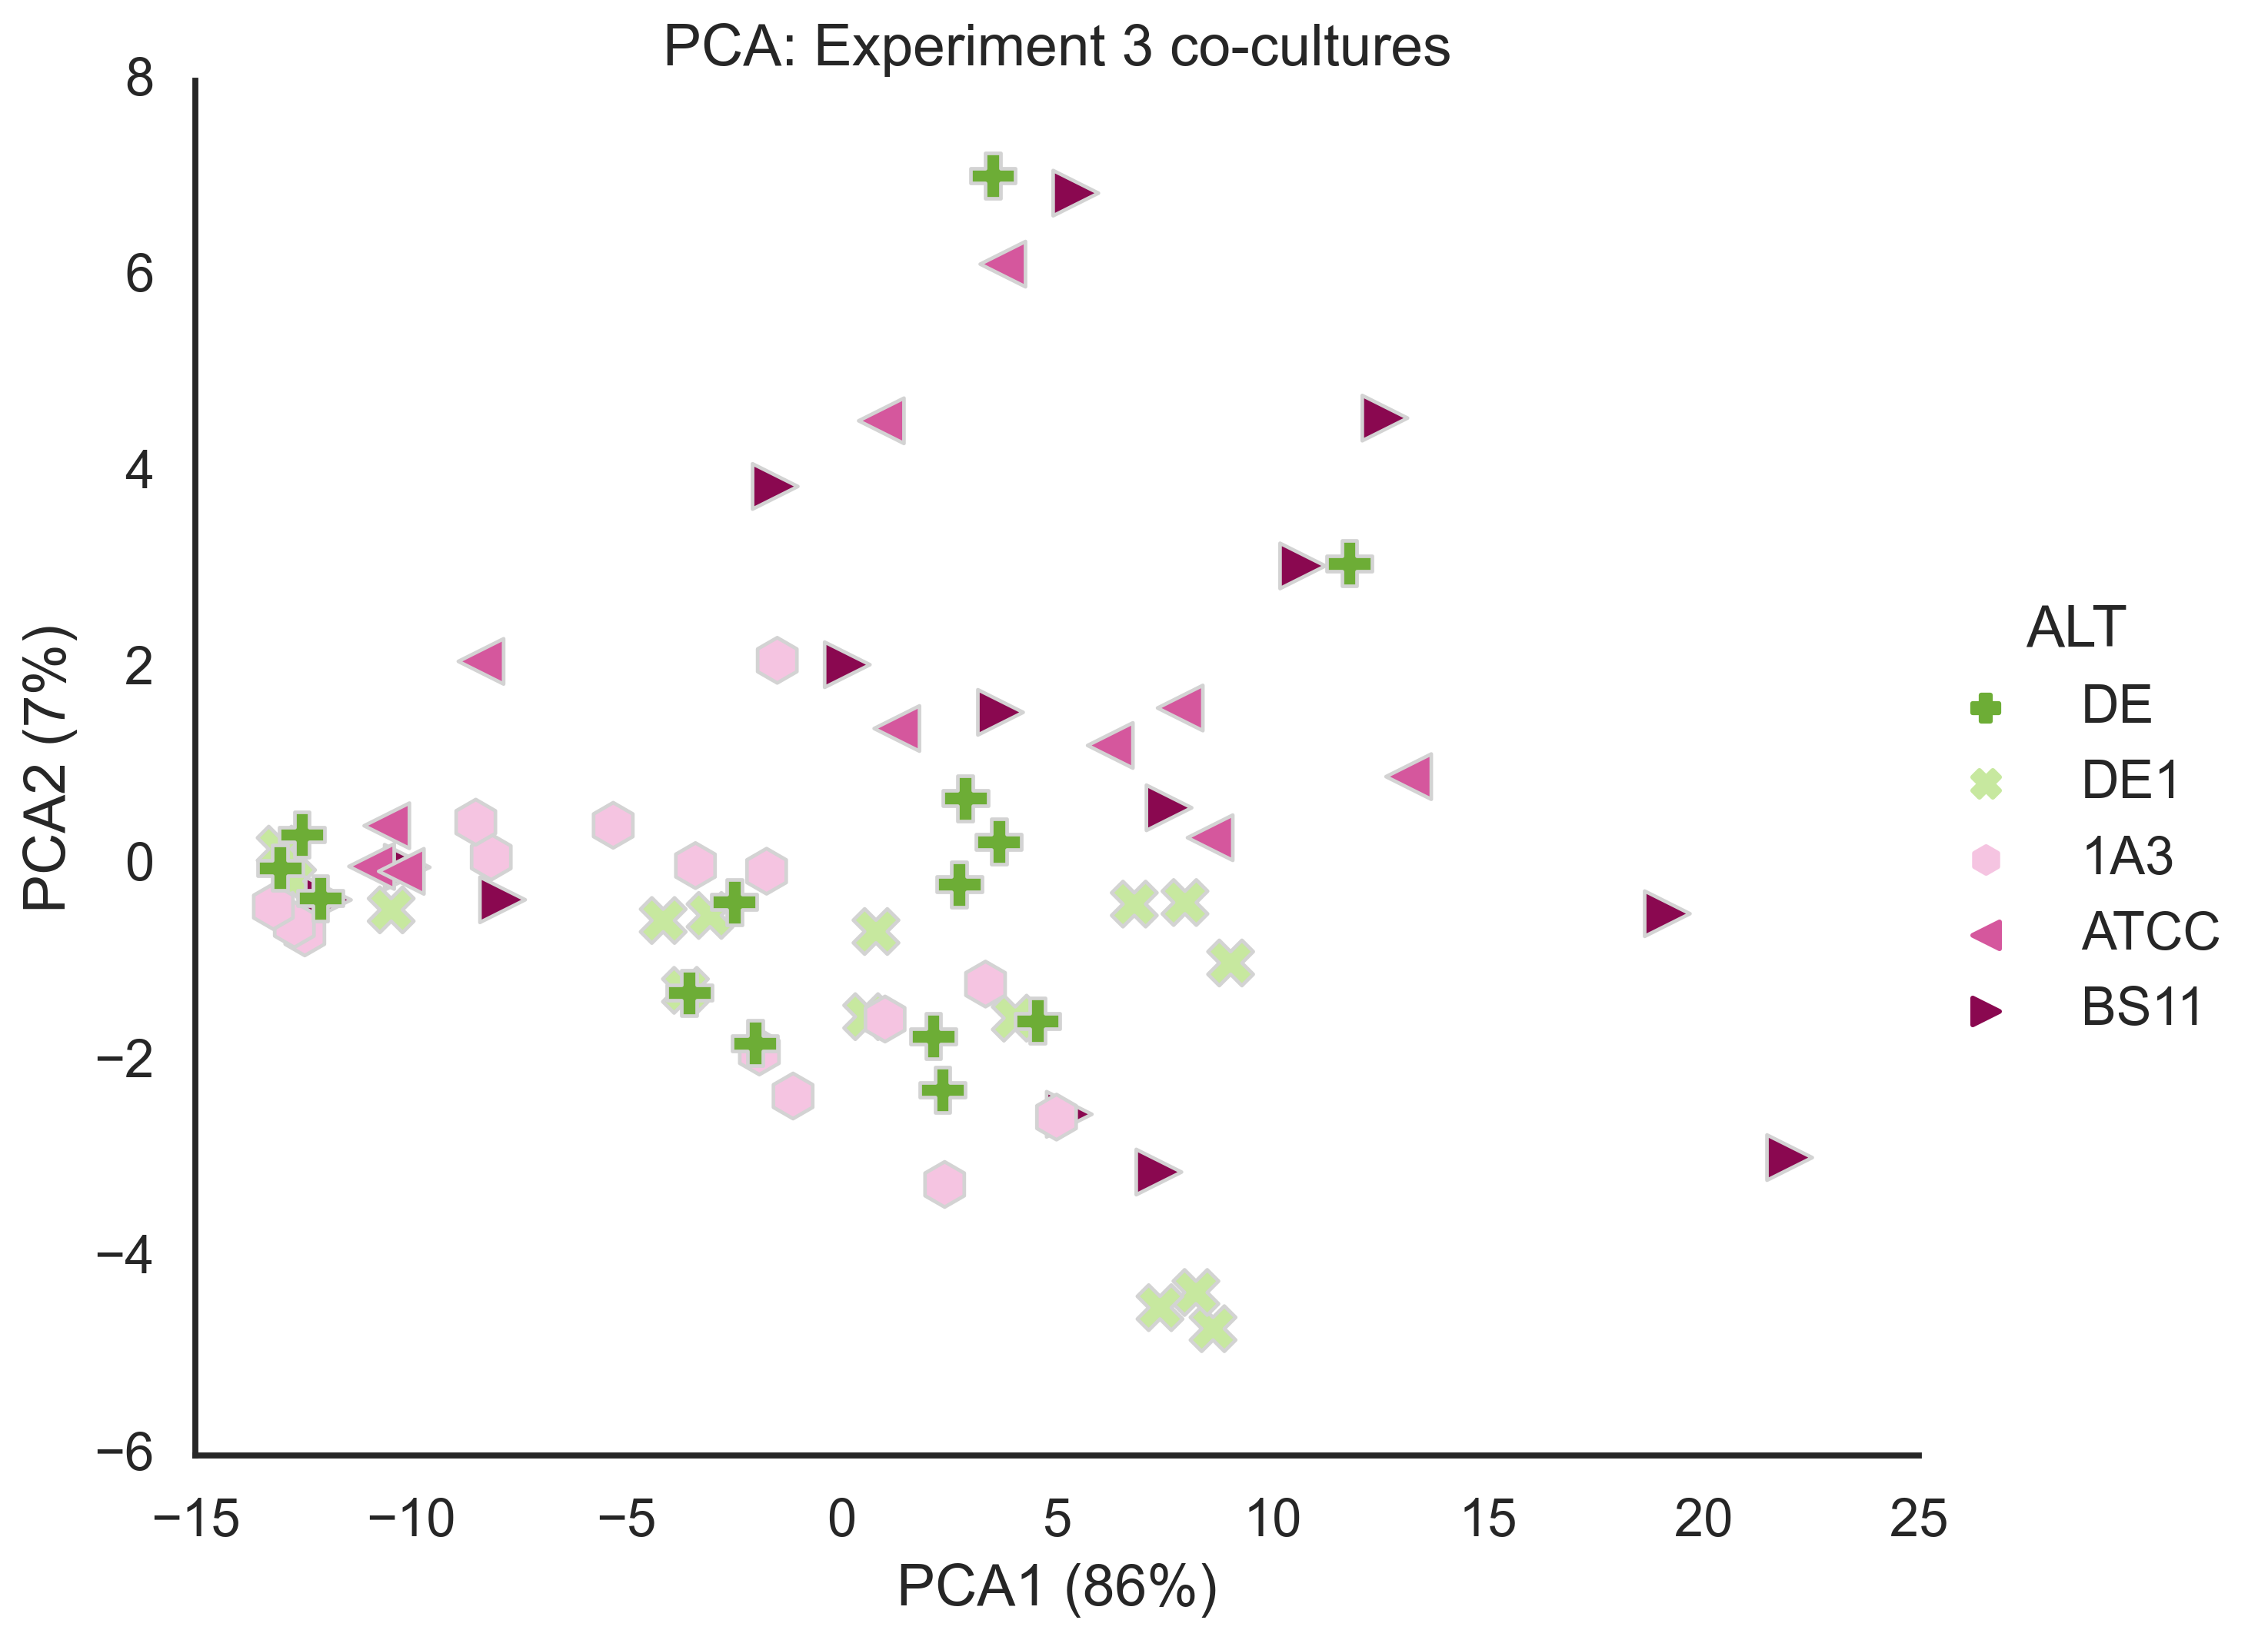

In [39]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='culture', 
            style='ALT',
            style_order=aorder, #markers=['p','h','<','v','>'],
                 markers=amarkers,
            s=200, #alpha=0.9, 
                 height=7, aspect=1.2,
            palette=apallete, 
                 hue_order=aorder ,edgecolor='lightgrey', 
                 #facet_kws=dict(subplot_kws=dict(fillstyle='none')) #fillstyle='none',
                 #facecolors= 'none'
           )
plt.xlabel('PCA1 (86%)')
plt.ylabel('PCA2 (7%)')
plt.title('PCA: Experiment 3 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

In [40]:
df4 = dfc.loc[dfc.experiment == 'e4']
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(df4, value_col='FL', cumsummode=True)
metadf = cp.get_meta(df4)
#metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.86012171 0.06528891]


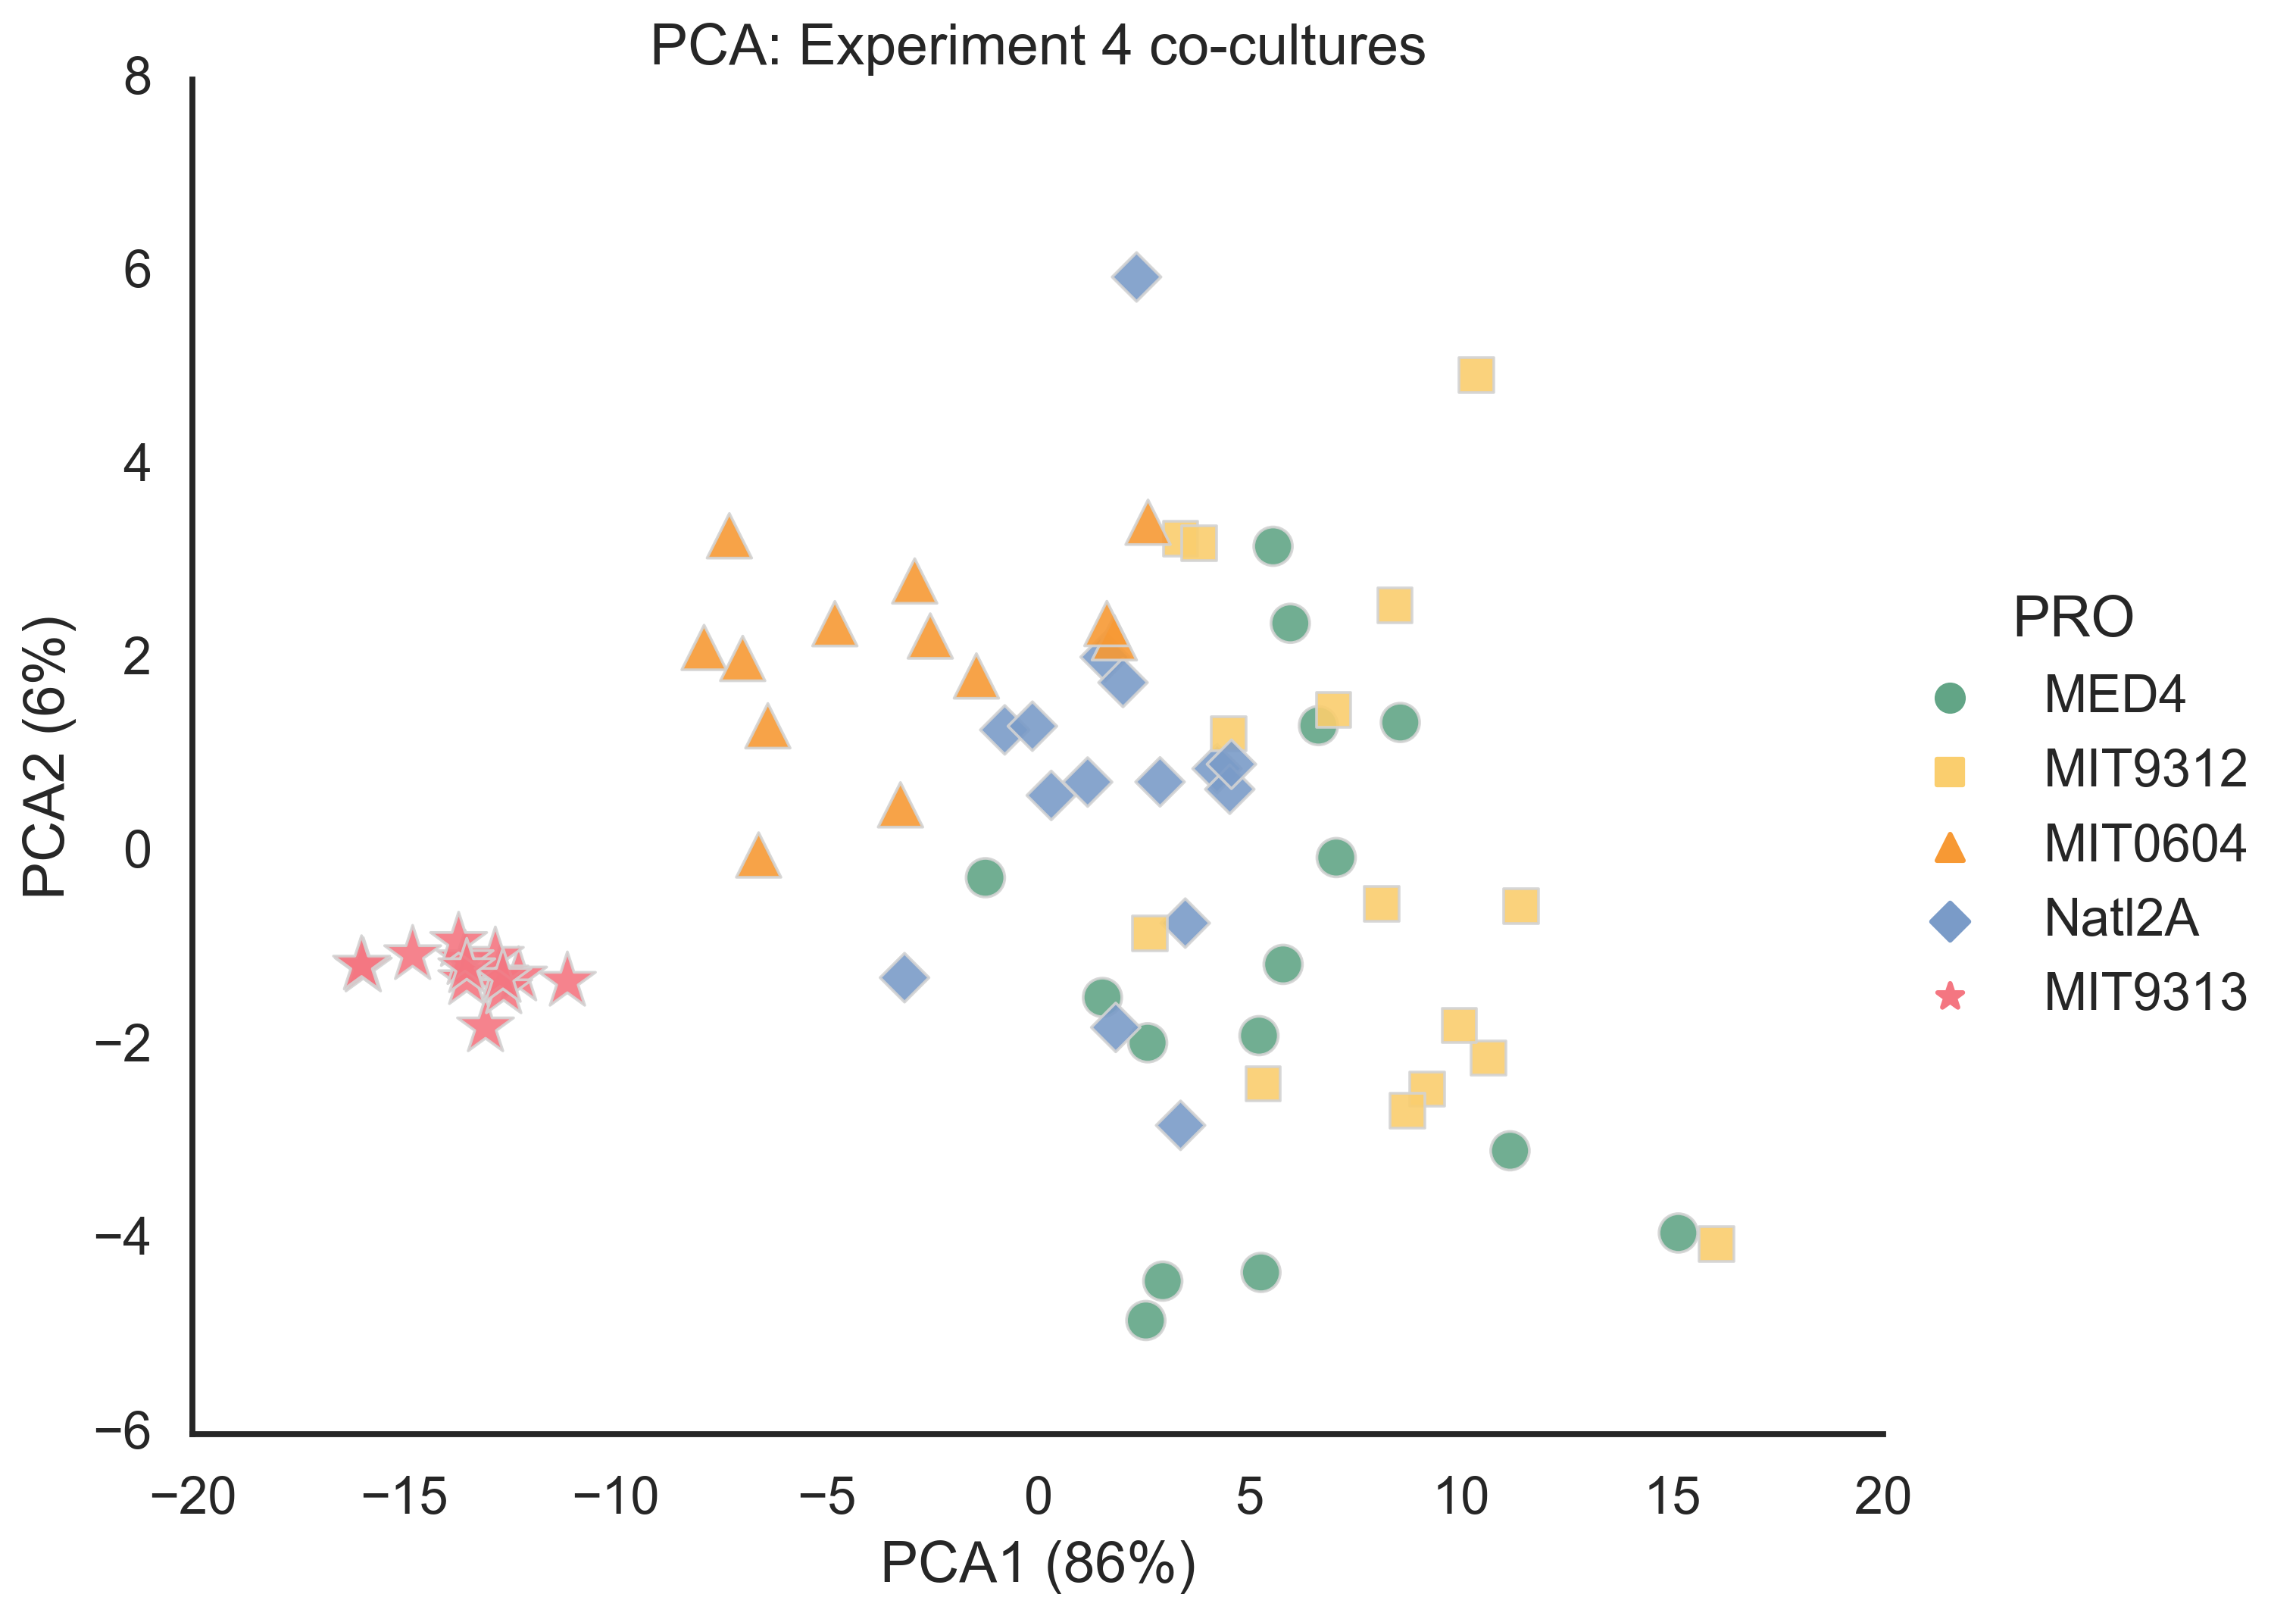

In [41]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='culture', 
            style='PRO',
            style_order=porder, markers=pmarkers,
            size='PRO', size_order=porder,
                 sizes=psizes, 
                 alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey', 
           )
plt.xlabel('PCA1 (86%)')
plt.ylabel('PCA2 (6%)')
plt.title('PCA: Experiment 4 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

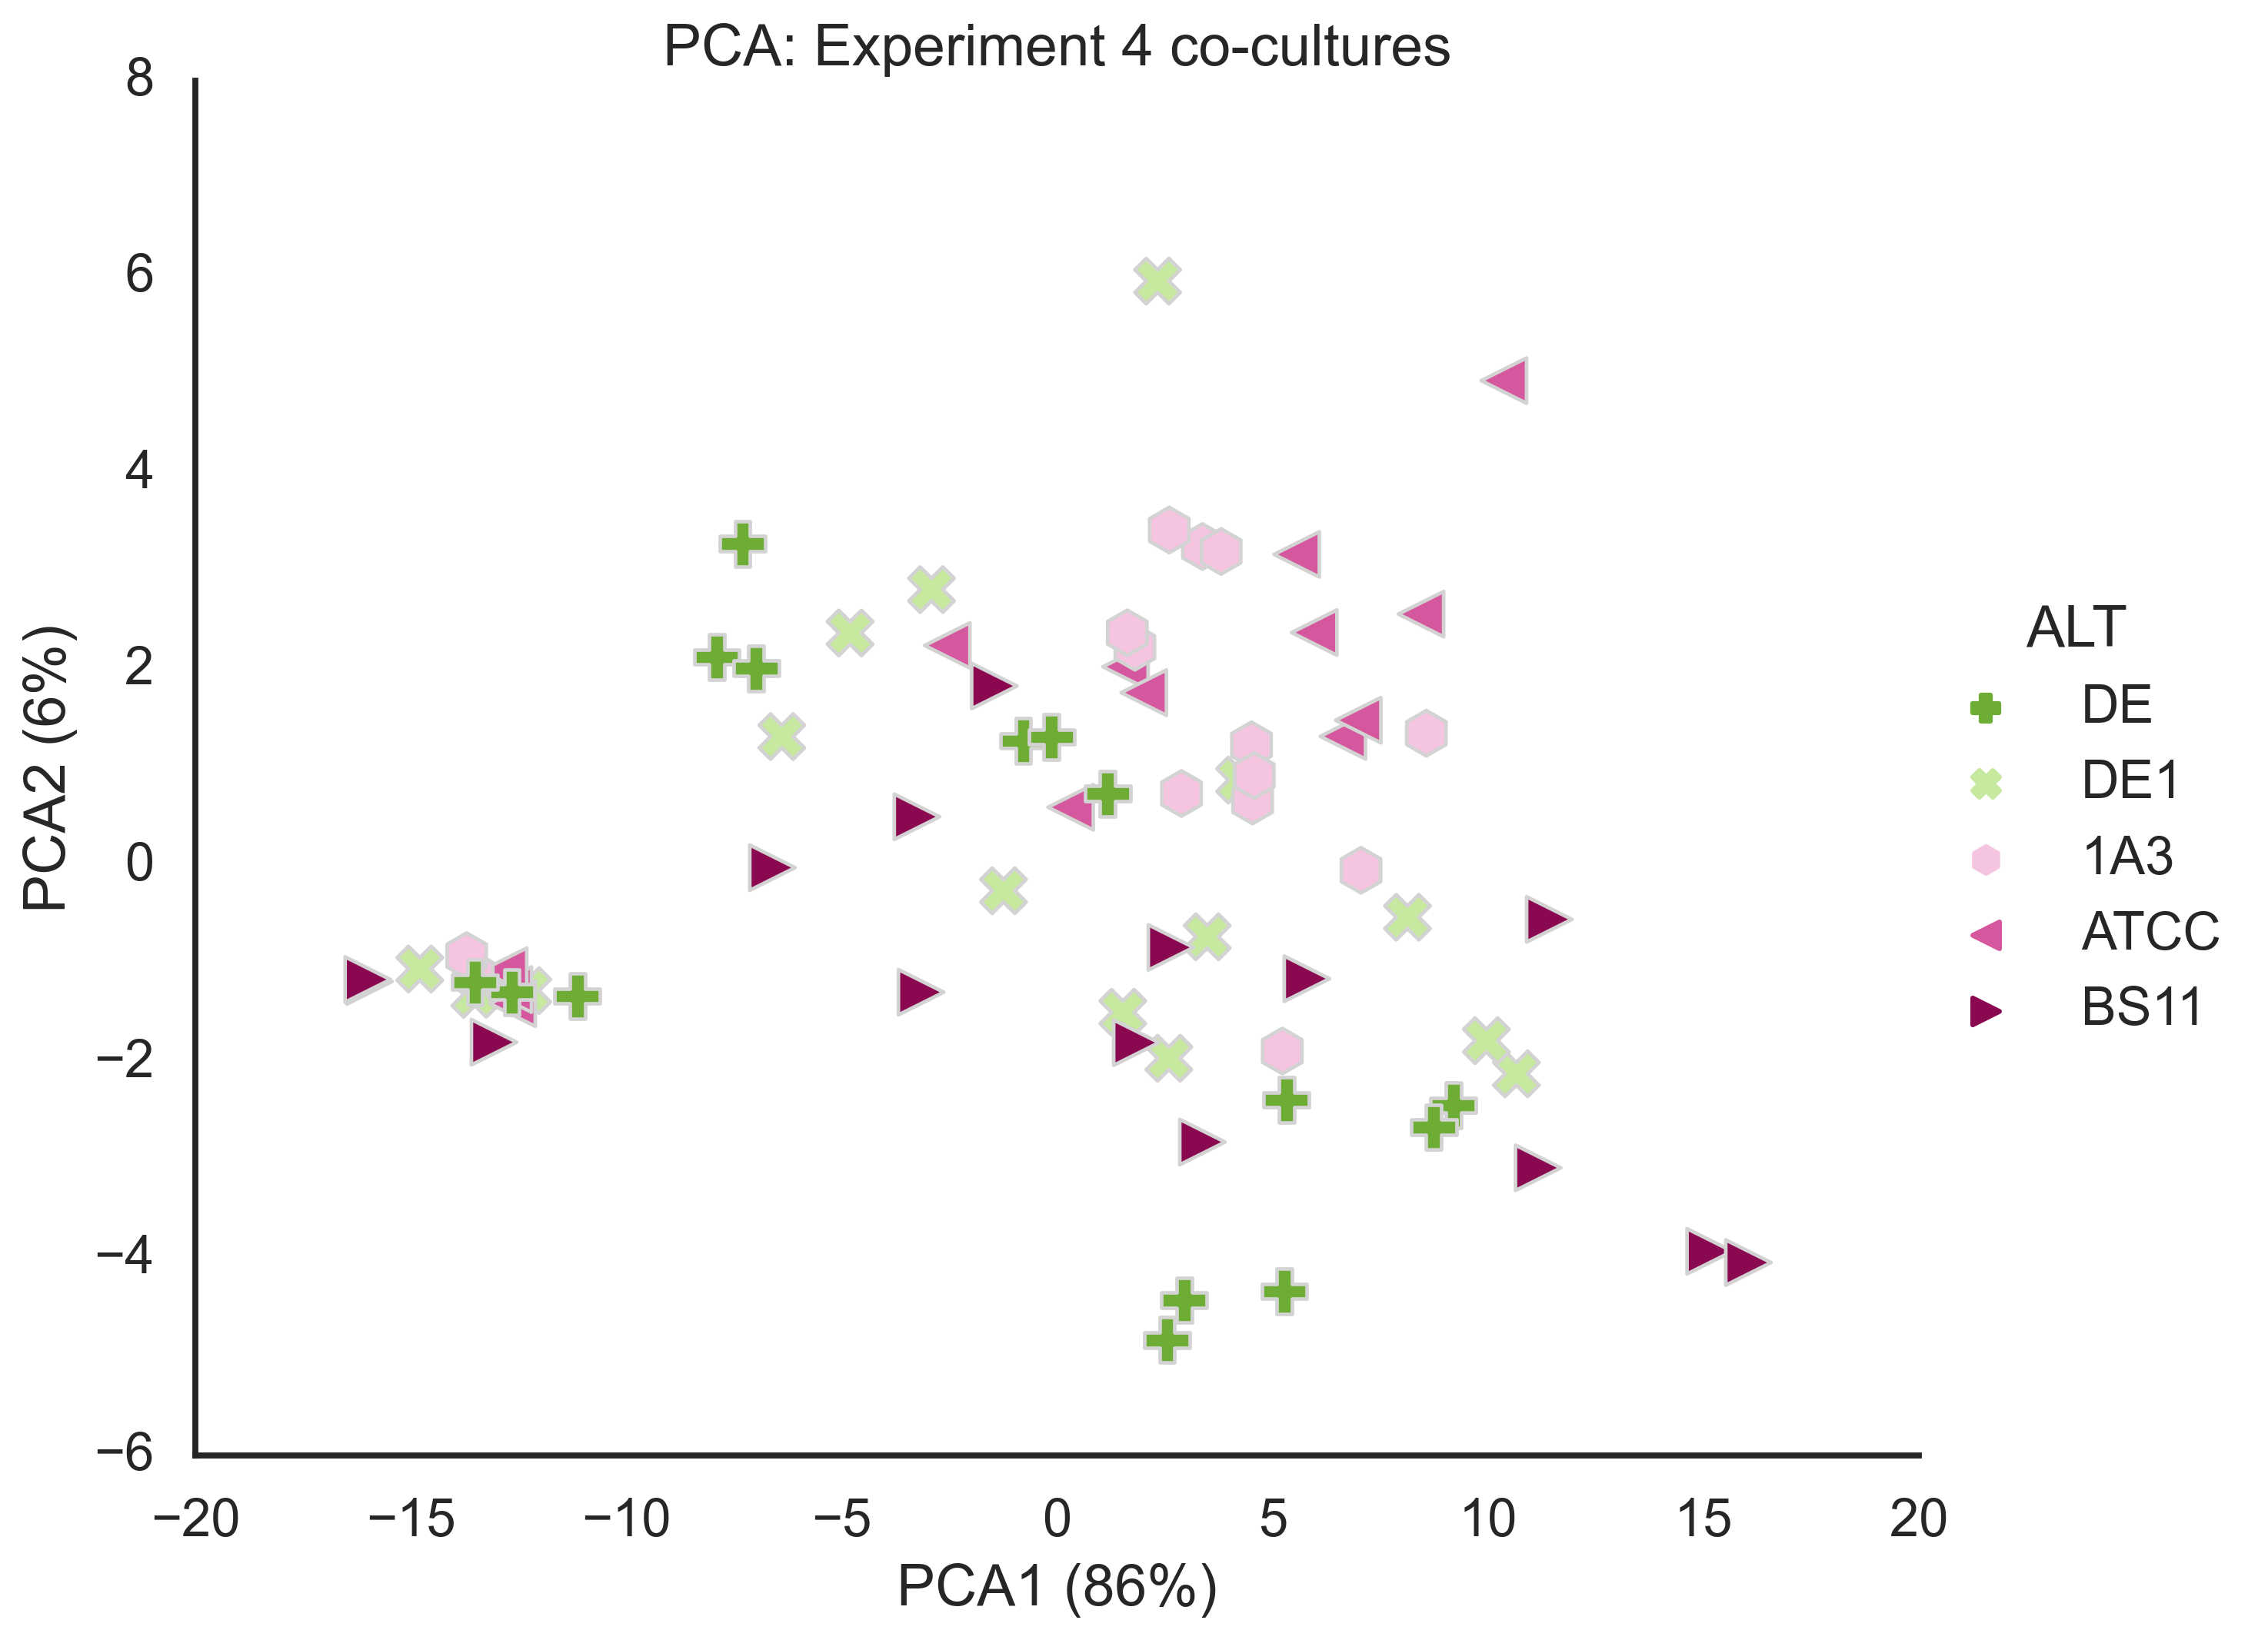

In [42]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='culture', 
            style='ALT',
            style_order=aorder, #markers=['p','h','<','v','>'],
                 markers=amarkers,
            s=200, #alpha=0.9, 
                 height=7, aspect=1.2,
            palette=apallete, 
                 hue_order=aorder ,edgecolor='lightgrey', 
                 #facet_kws=dict(subplot_kws=dict(fillstyle='none')) #fillstyle='none',
                 #facecolors= 'none'
           )
plt.xlabel('PCA1 (86%)')
plt.ylabel('PCA2 (6%)')
plt.title('PCA: Experiment 4 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

In [43]:
df5 = dfc.loc[dfc.experiment == 'e5']
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(df5, value_col='FL', cumsummode=True)
metadf = cp.get_meta(df5)
#metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.66411219 0.20167834]


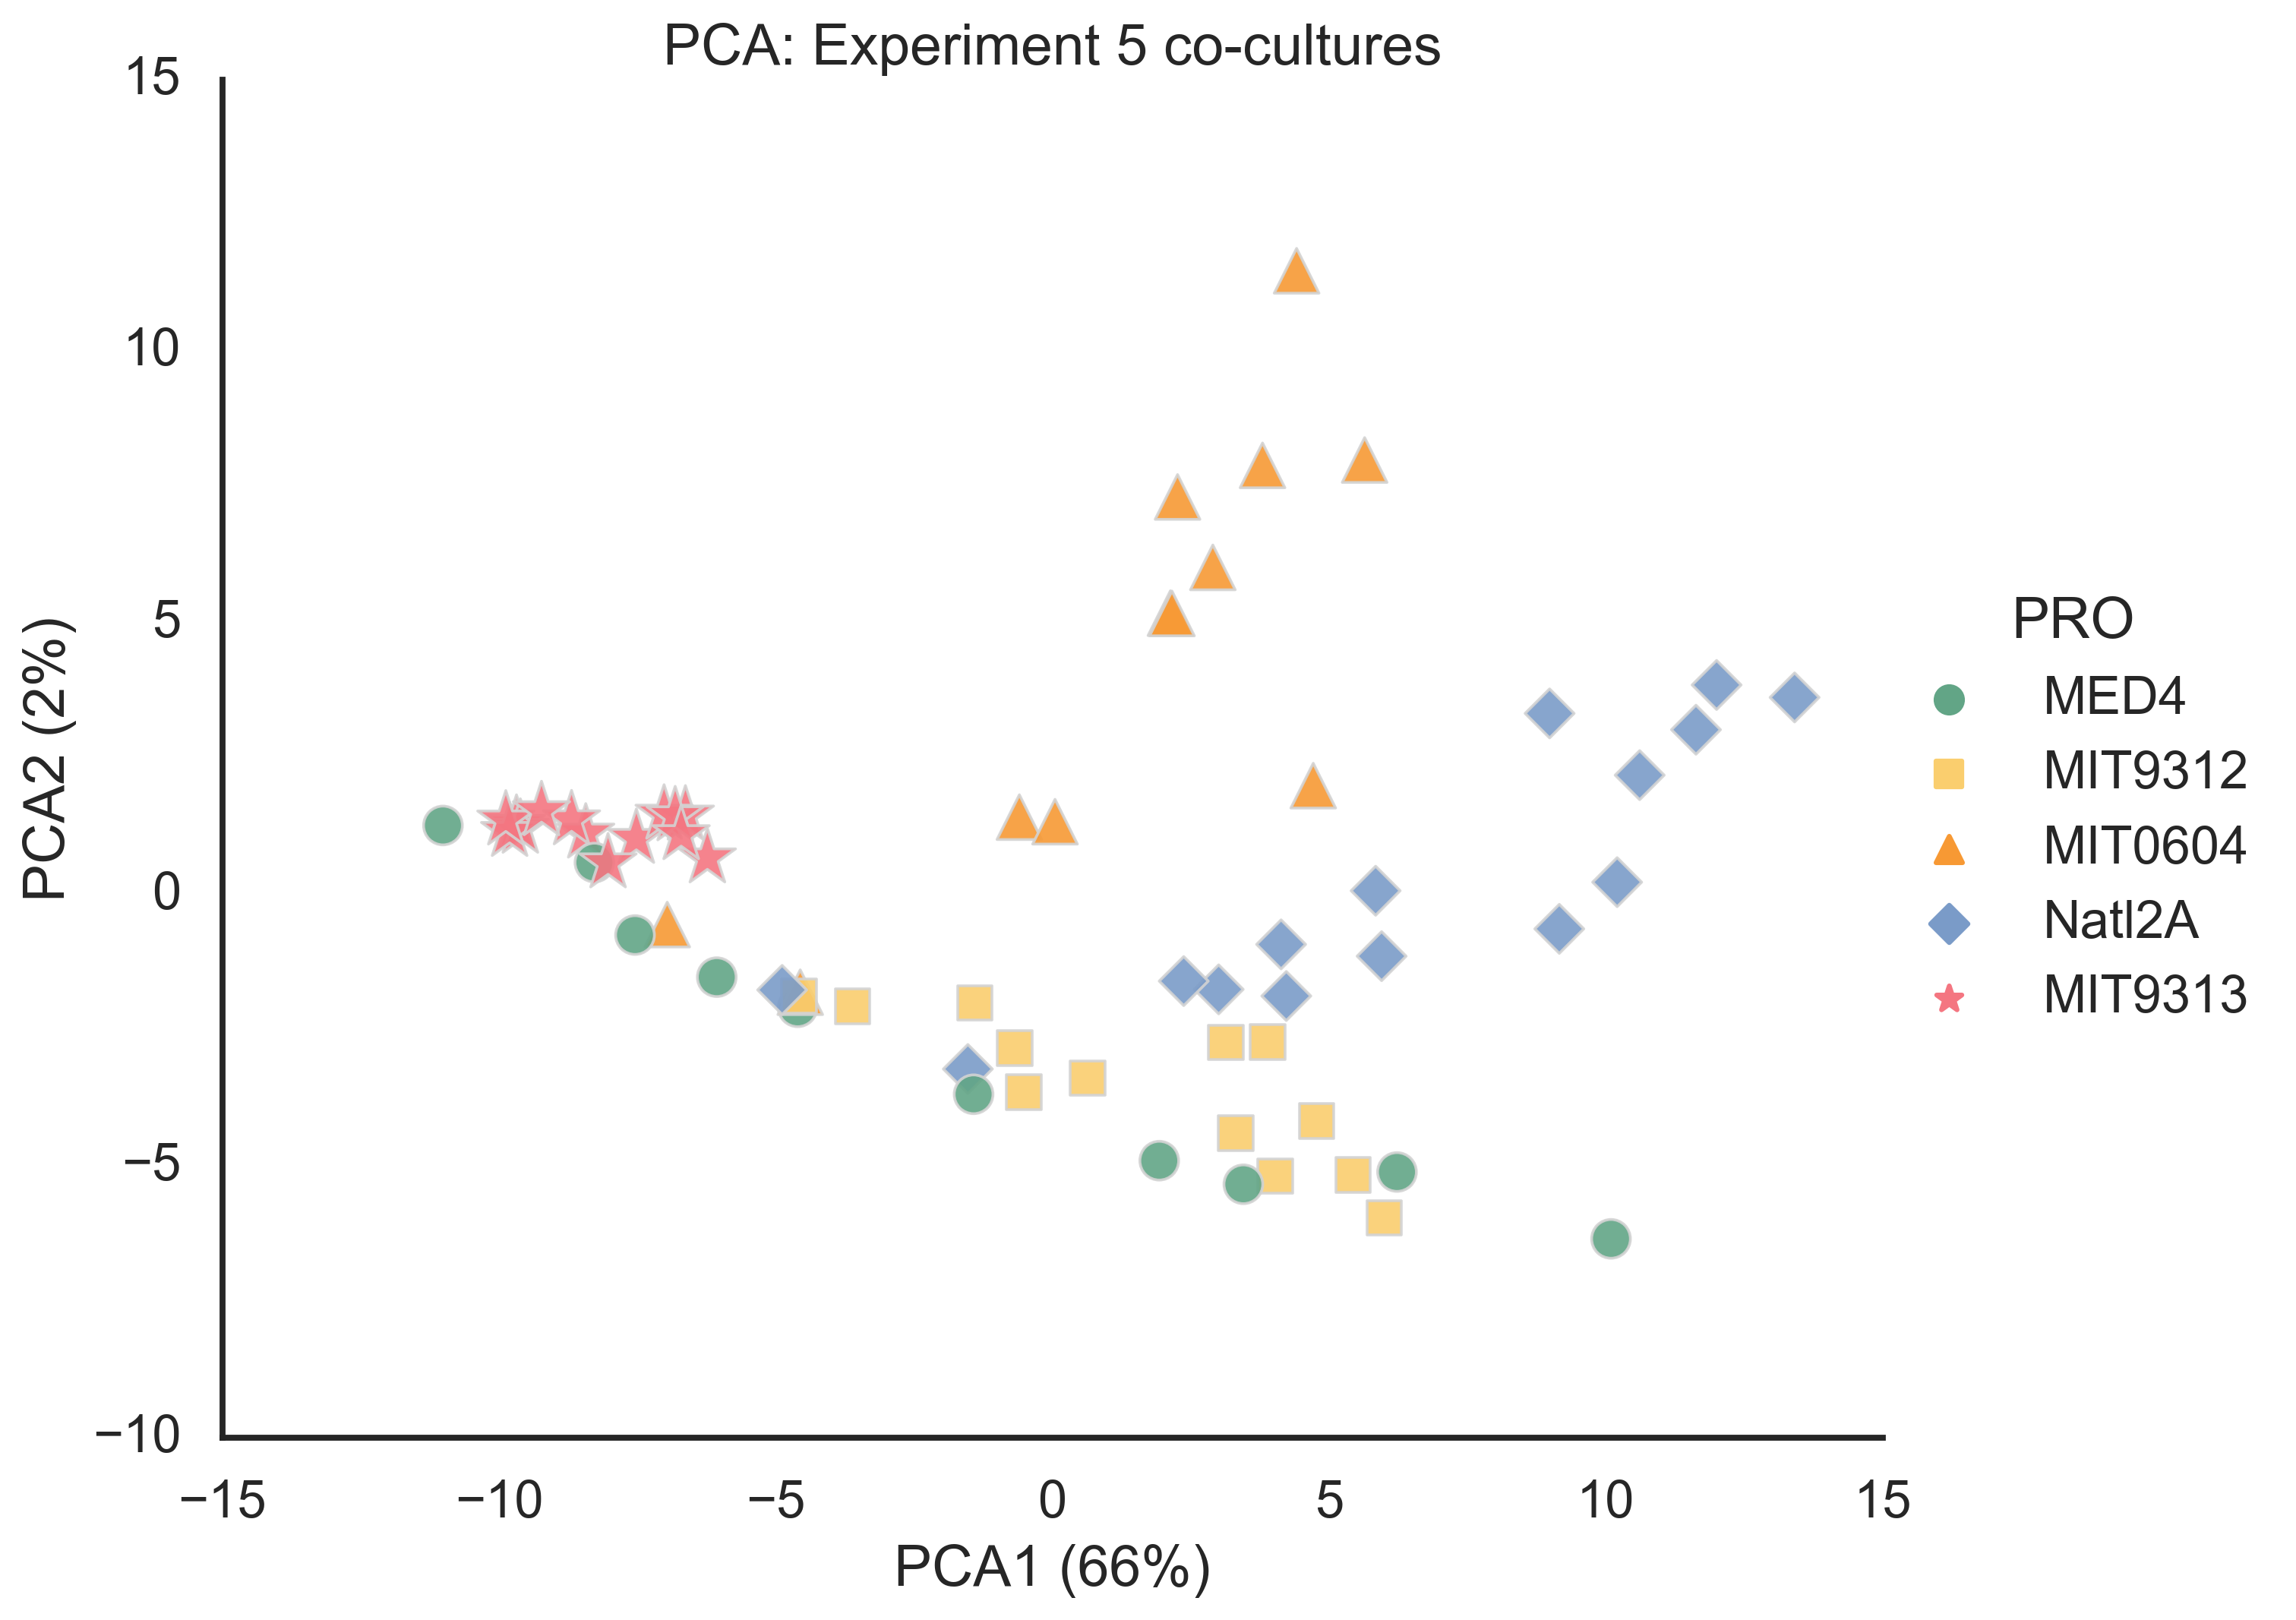

In [44]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='culture', 
            style='PRO',
            style_order=porder, markers=pmarkers,
            size='PRO', size_order=porder,
                 sizes=psizes, 
                 alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey', 
           )
plt.xlabel('PCA1 (66%)')
plt.ylabel('PCA2 (2%)')
plt.title('PCA: Experiment 5 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

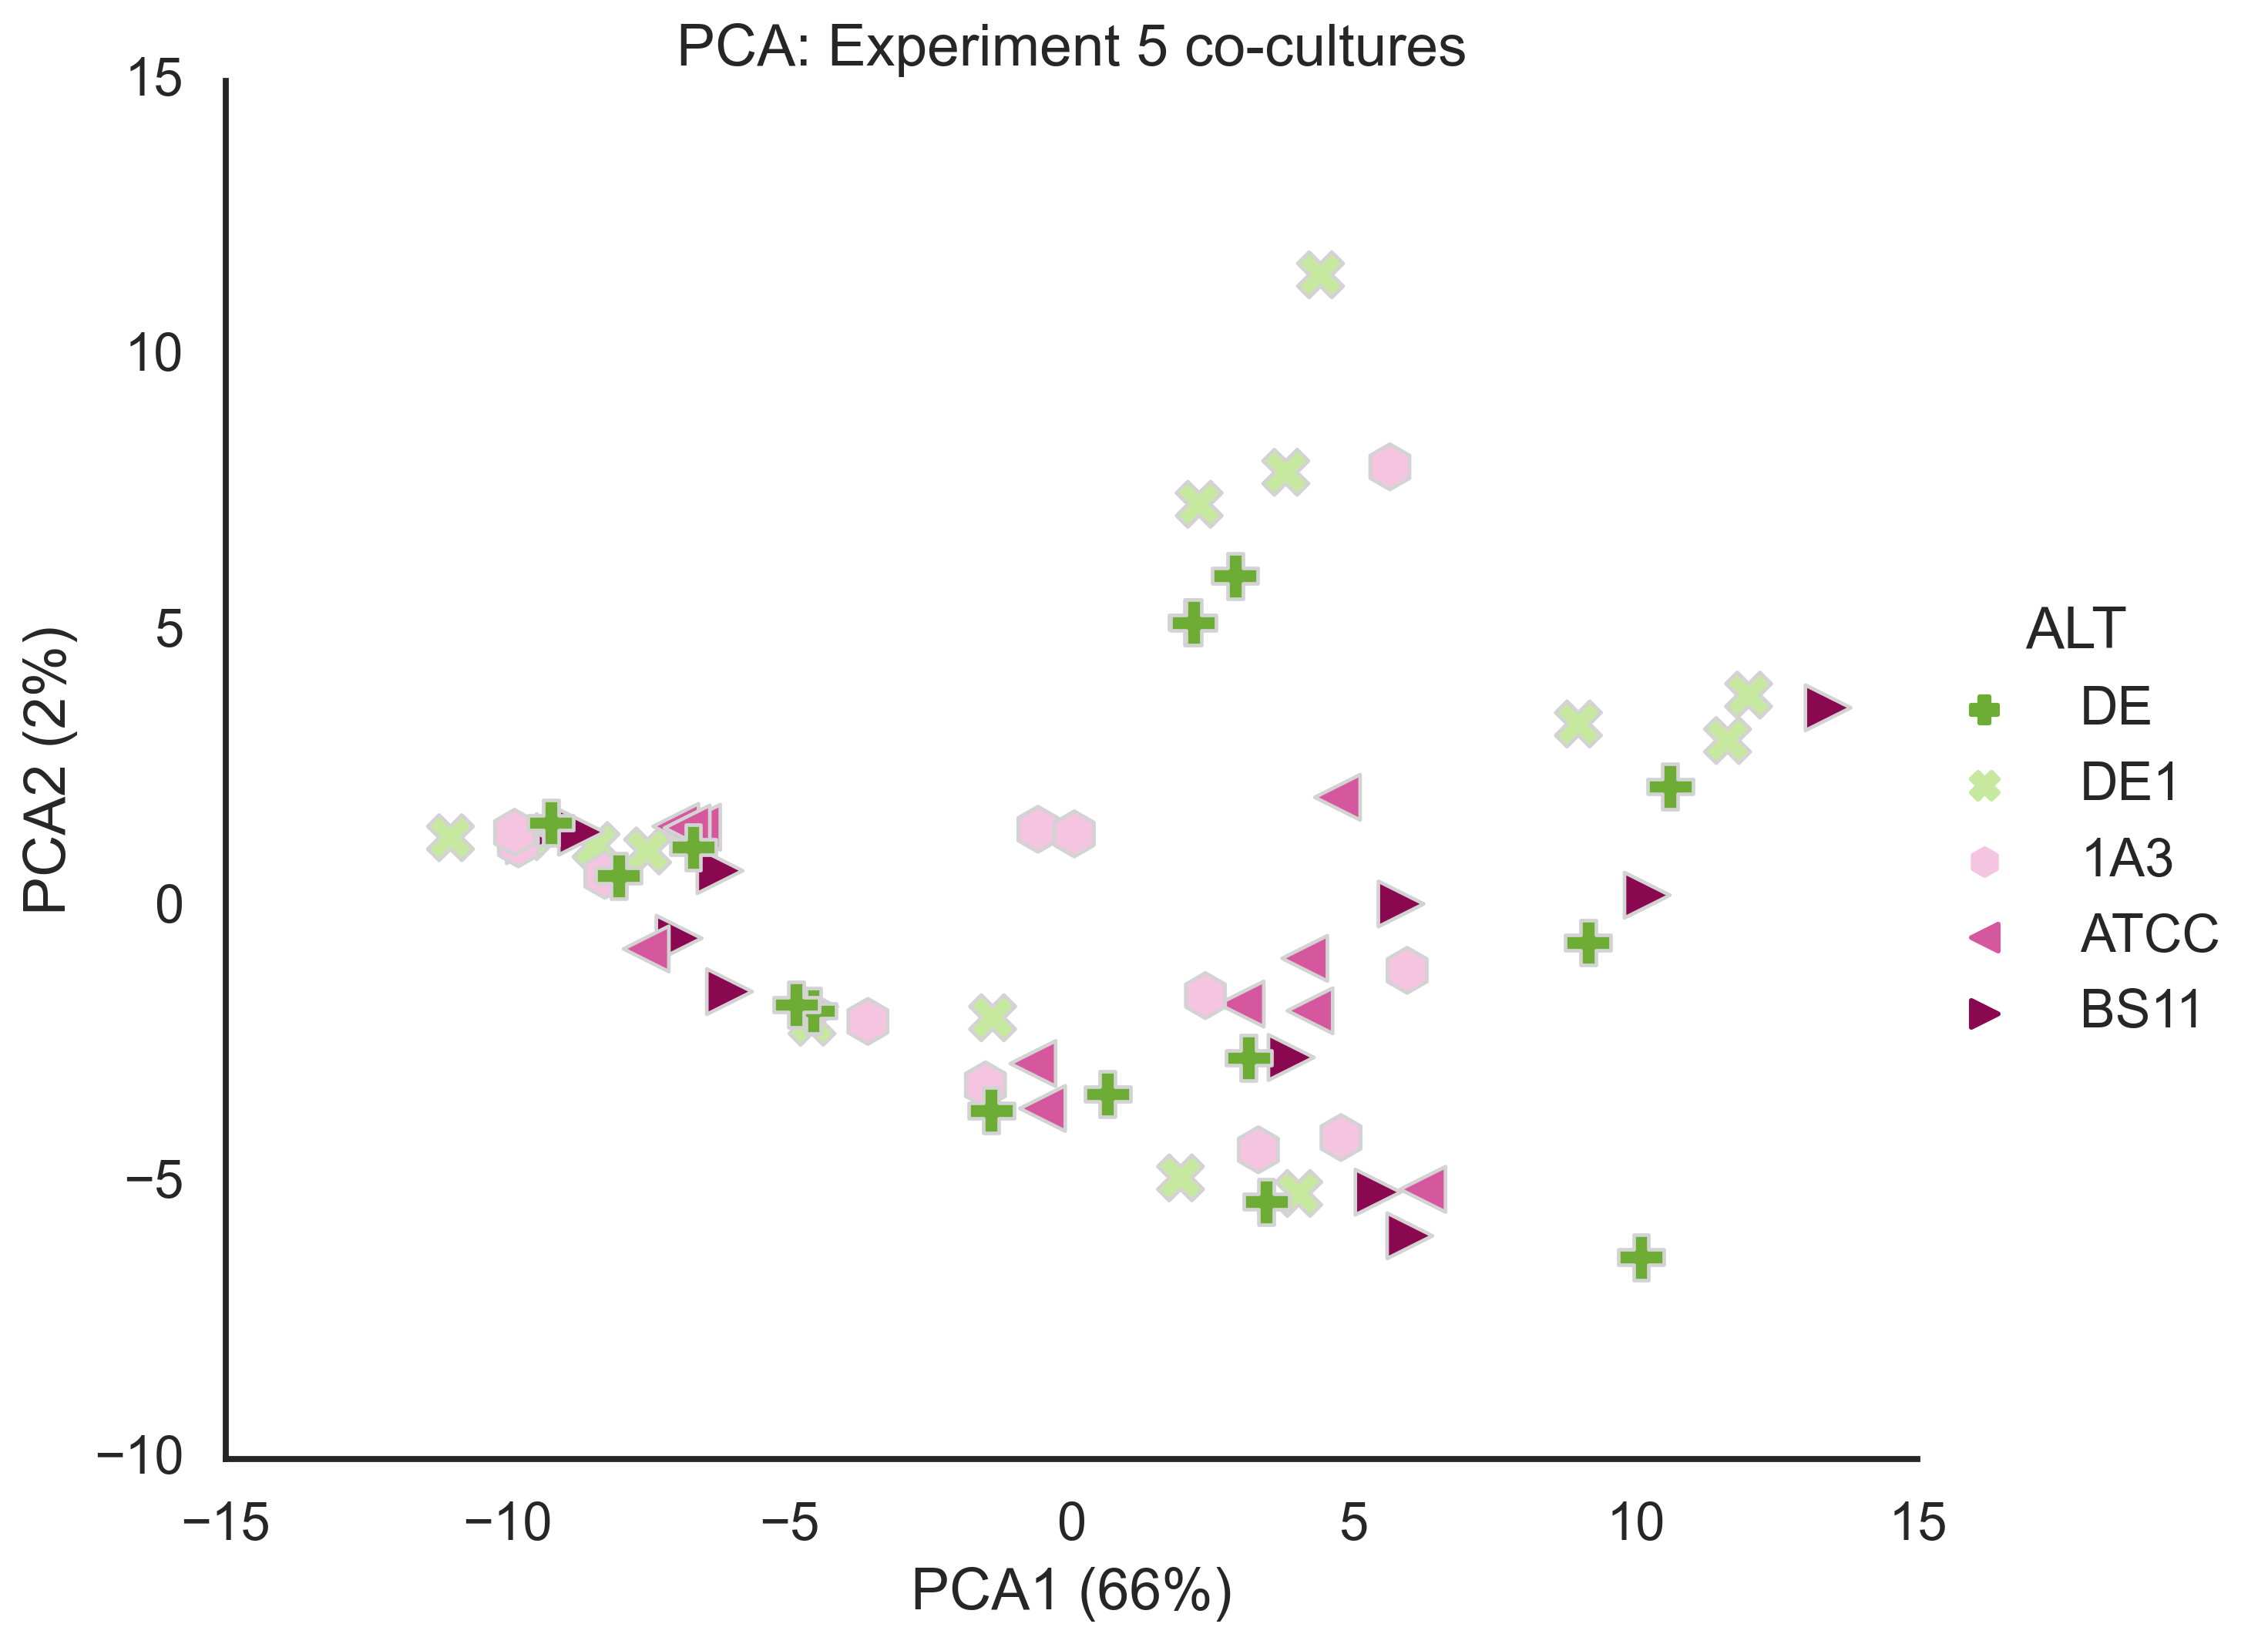

In [45]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='culture', 
            style='ALT',
            style_order=aorder, #markers=['p','h','<','v','>'],
                 markers=amarkers,
            s=200, #alpha=0.9, 
                 height=7, aspect=1.2,
            palette=apallete, 
                 hue_order=aorder ,edgecolor='lightgrey', 
                 #facet_kws=dict(subplot_kws=dict(fillstyle='none')) #fillstyle='none',
                 #facecolors= 'none'
           )
plt.xlabel('PCA1 (66%)')
plt.ylabel('PCA2 (2%)')
plt.title('PCA: Experiment 5 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

In [46]:
df6 = dfc.loc[dfc.experiment == 'e6']
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(df6, value_col='FL', cumsummode=True)
metadf = cp.get_meta(df6)
#metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.60705338 0.19295257]


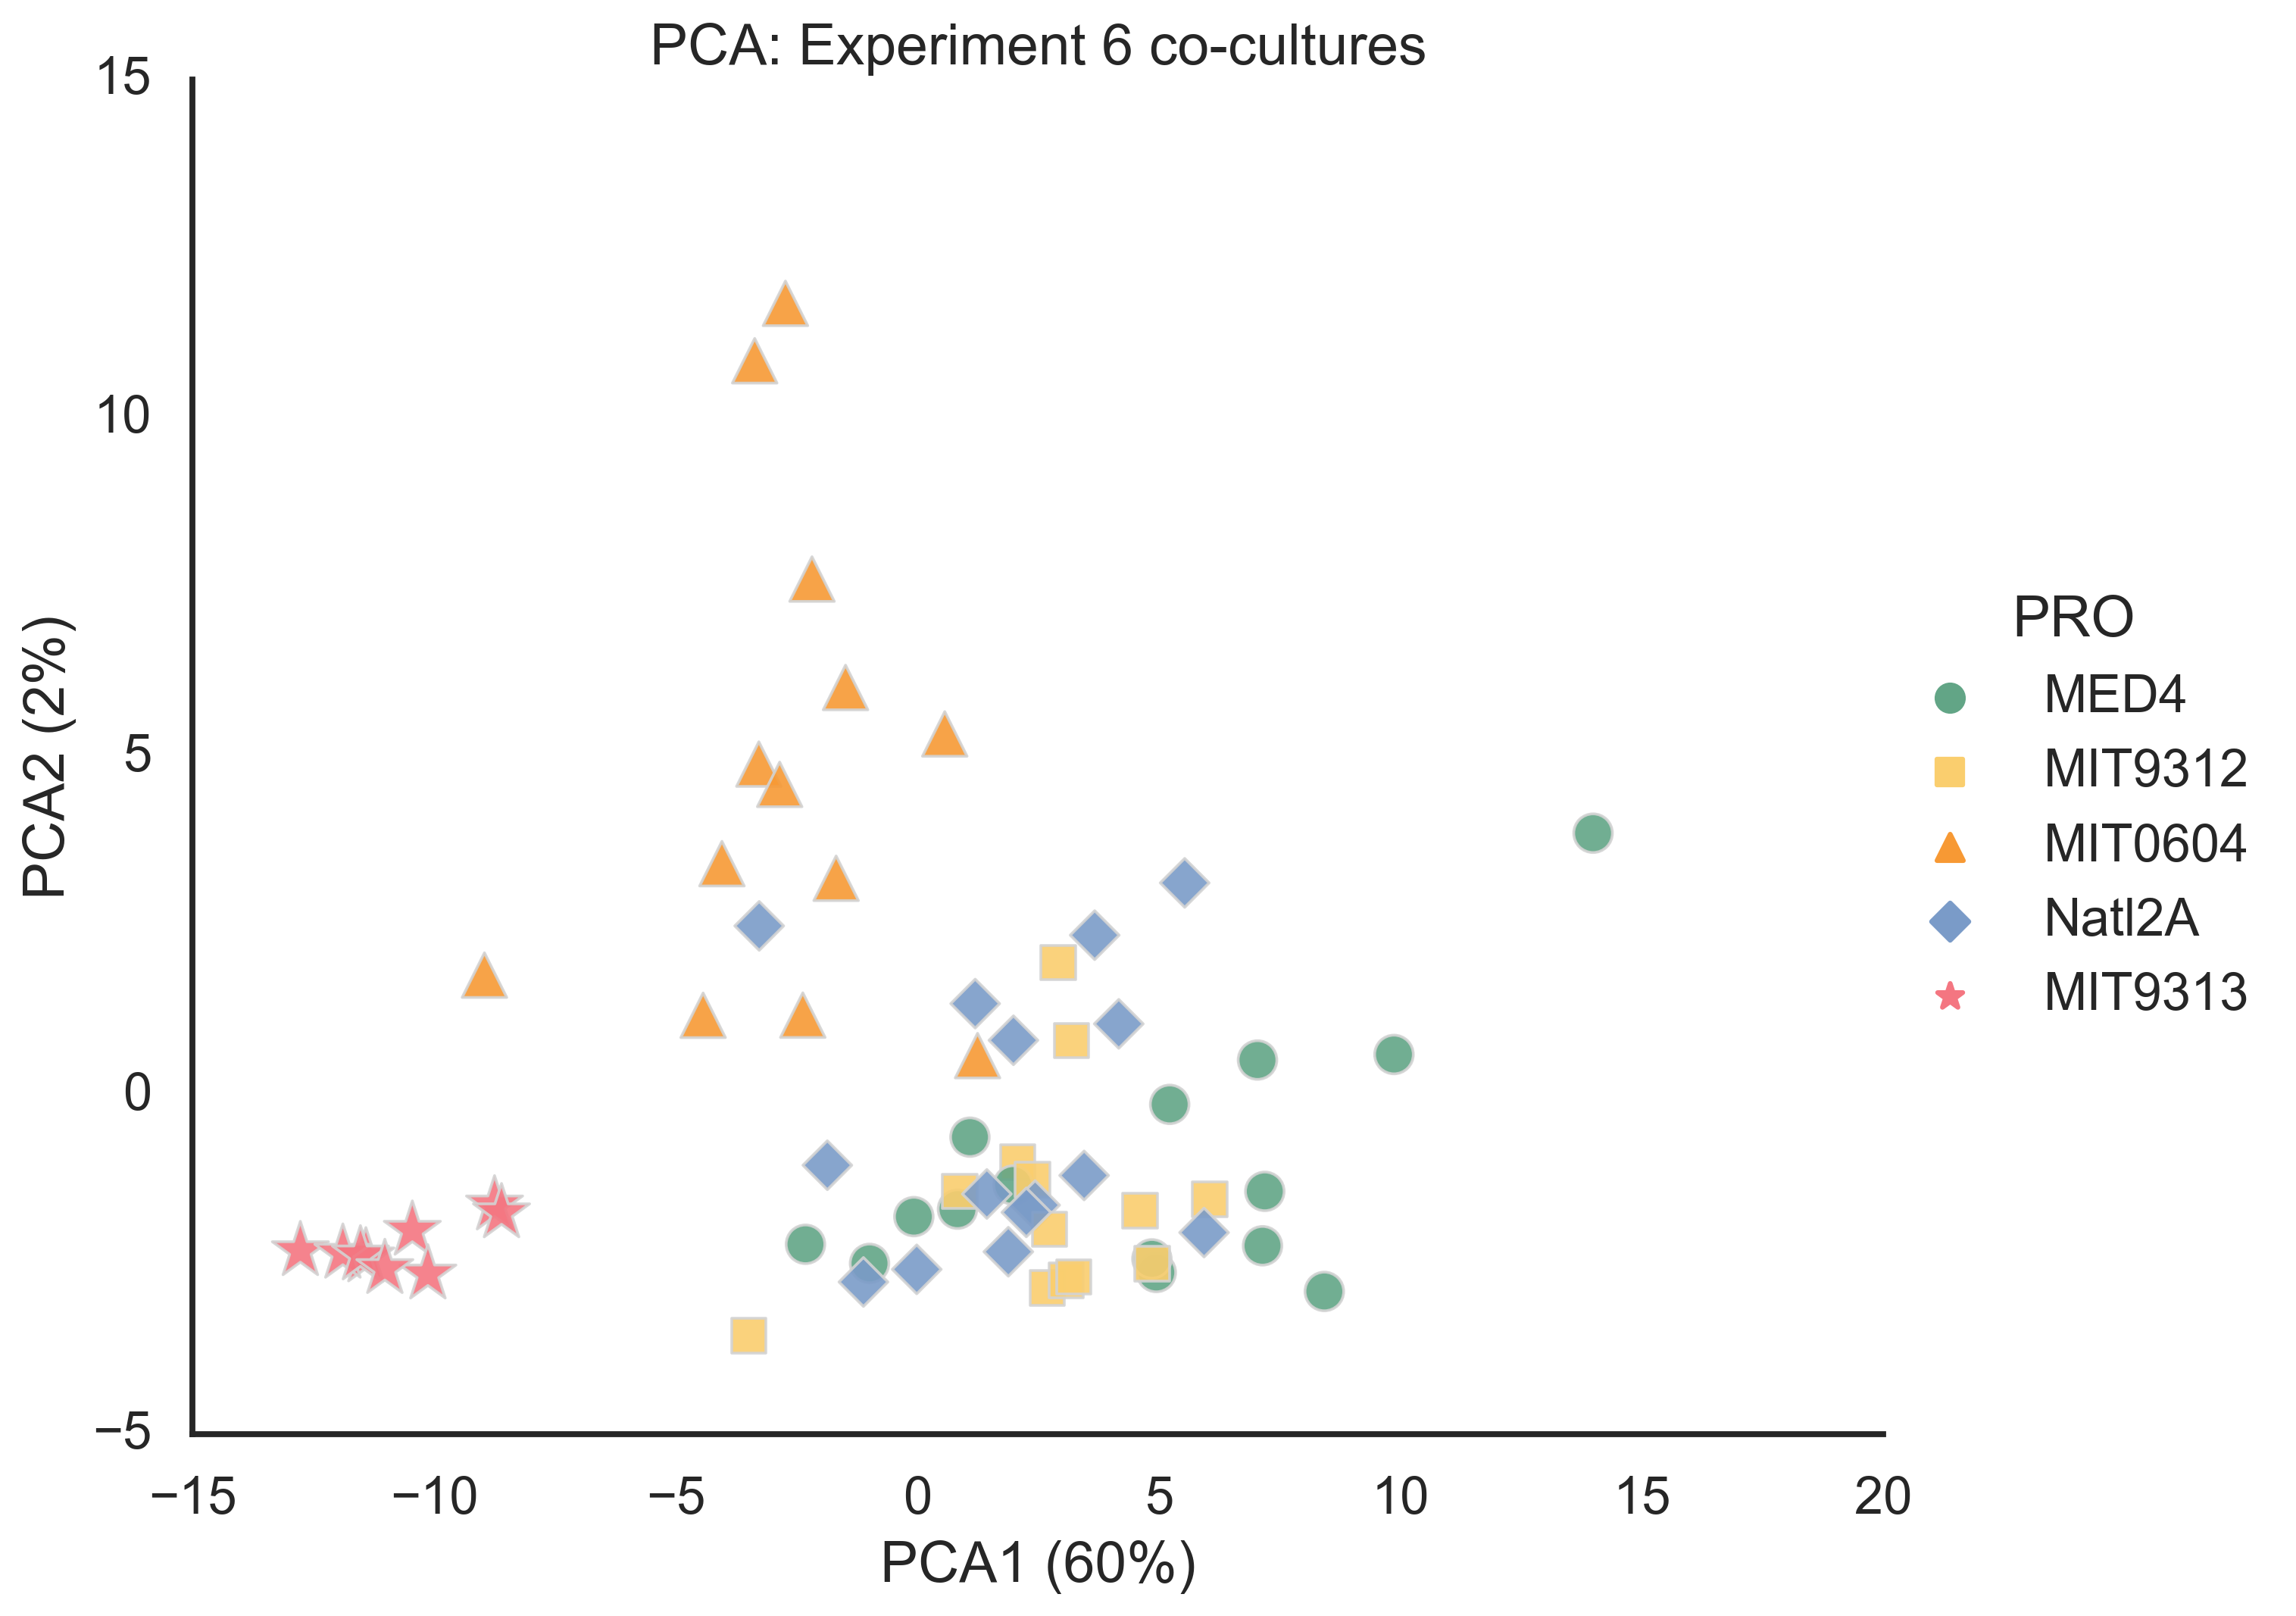

In [47]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='culture', 
            style='PRO',
            style_order=porder, markers=pmarkers,
            size='PRO', size_order=porder,
                 sizes=psizes, 
                 alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey', 
           )
plt.xlabel('PCA1 (60%)')
plt.ylabel('PCA2 (2%)')
plt.title('PCA: Experiment 6 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

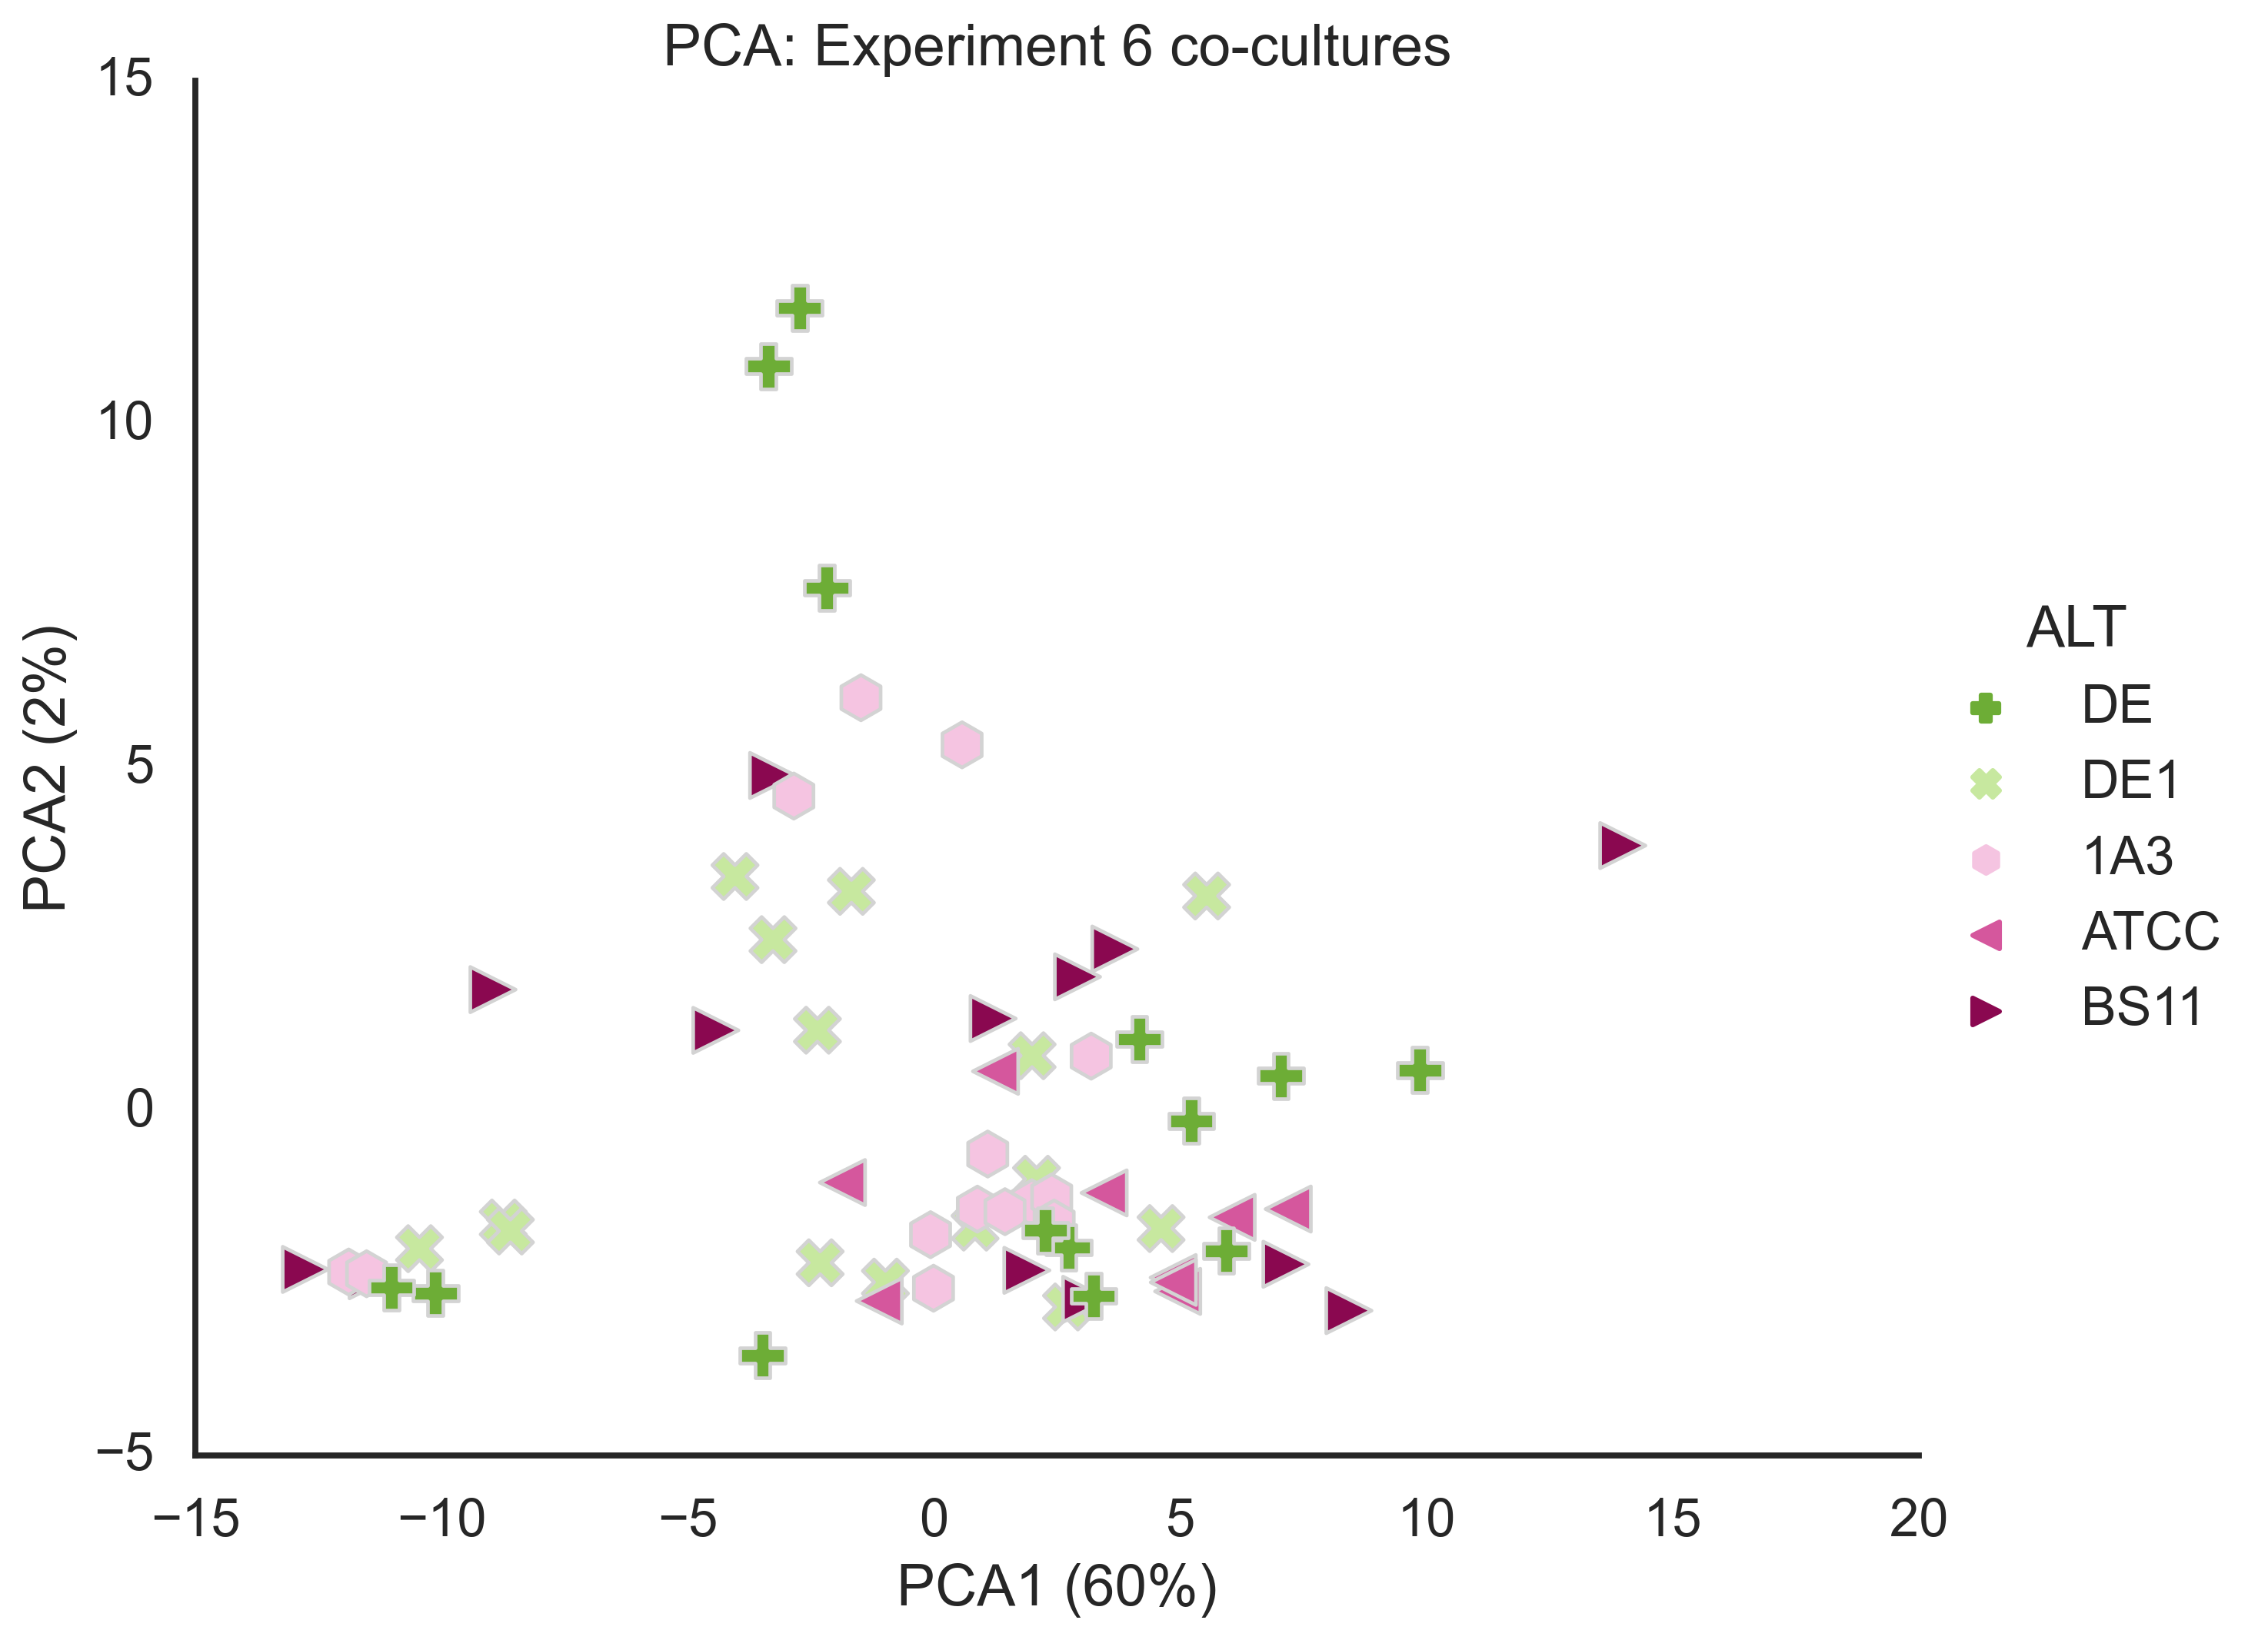

In [48]:
sns.set_context('talk')
ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='culture', 
            style='ALT',
            style_order=aorder, #markers=['p','h','<','v','>'],
                 markers=amarkers,
            s=200, #alpha=0.9, 
                 height=7, aspect=1.2,
            palette=apallete, 
                 hue_order=aorder ,edgecolor='lightgrey', 
                 #facet_kws=dict(subplot_kws=dict(fillstyle='none')) #fillstyle='none',
                 #facecolors= 'none'
           )
plt.xlabel('PCA1 (60%)')
plt.ylabel('PCA2 (2%)')
plt.title('PCA: Experiment 6 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

In [49]:
exp2_df = pd.read_excel('exp2_all.xlsx')

In [50]:
exp2_df.rename(columns={'day': 'sample'}, inplace=True)
exp2_df.head()
#exp2_df.melt(id_vars='PR')

PRO  ALT sample      0  2.0347222222189885  3.2305555555503815  \
0     MED4  1A3     1A  0.027               0.050               0.095   
1     MED4  1A3     1B  0.027               0.018               0.088   
2     MED4  1A3     1C  0.063               0.018               0.082   
3  MIT9313  1A3     2A  0.036               0.014               0.014   
4  MIT9313  1A3     2B  0.045              -0.014               0.027   

   4.113888888889051  5.104166666664241  5.999305555553292  8.950694444443798  \
0              0.157              0.237              0.239              0.886   
1              0.159              0.230              0.376              1.058   
2              0.150              0.247              0.355              1.072   
3              0.023              0.018              0.036              0.058   
4              0.018              0.032              0.000             -0.005   

   ...  26.03472222221899  26.947222222217533  30.099305555551837  \
0  ...              0.667               0.825               0.834   
1  ...              0.660               0.686               0.905   
2  ...              0.641               0.718               0.800   
3  ...              0.241               0.155               0.132   
4  ...              0.842               0.531               0.215   

   32.35347222221753  33.03055555555329  34.18194444444089  36.91874999999709  \
0              0.499              0.591              0.689              0.593   
1              0.413              0.486              0.569              0.515   
2              0.437              0.517              0.545              0.561   
3              0.073              0.064              0.046              0.104   
4              0.091              0.101              0.068              0.063   

   38.13055555555184  39.16874999999709  39.87291666666715  
0              0.476              0.331              0.244  
1              0.454              0.250              0.210  
2              0.438              0.269              0.208  
3              0.078              0.078              0.096  
4              0.101              0.091              0.064  

[5 rows x 32 columns]

In [51]:
exp2_df = exp2_df.melt(id_vars=['PRO', 'ALT', 'sample'], var_name='day', value_name='FL')


In [52]:
exp2_df['experiment'] = 'e2'
exp2_df['culture'] = 'Co_Culture'
exp2_df.loc[exp2_df.ALT.isna(), 'culture'] = 'Axenic'
exp2_df = cp.update_calculated_fields(exp2_df)


In [53]:
exp2_df['ALT'] = exp2_df['ALT'].fillna(value='Ax_Pro')

In [54]:
exp2_df.head()

PRO  ALT sample day     FL experiment     culture  FL_orig     logFL  \
0     MED4  1A3     1A   0  0.050         e2  Co_Culture    0.027 -2.995732   
1     MED4  1A3     1B   0  0.050         e2  Co_Culture    0.027 -2.995732   
2     MED4  1A3     1C   0  0.063         e2  Co_Culture    0.063 -2.764621   
3  MIT9313  1A3     2A   0  0.050         e2  Co_Culture    0.036 -2.995732   
4  MIT9313  1A3     2B   0  0.050         e2  Co_Culture    0.045 -2.995732   

   cumsumFL  cumsumlogFL  zscoreFL  diffFL  difflogFL diffday rateFL  \
0     0.050    -2.995732 -1.136112     NaN        NaN     NaN    NaN   
1     0.050    -2.995732 -0.939761     NaN        NaN     NaN    NaN   
2     0.063    -2.764621 -0.926958     NaN        NaN     NaN    NaN   
3     0.050    -2.995732 -0.550824     NaN        NaN     NaN    NaN   
4     0.050    -2.995732 -0.576194     NaN        NaN     NaN    NaN   

  ratelogFL experiment_sample  
0       NaN            e2, 1A  
1       NaN            e2, 1B  
2       NaN            e2, 1C  
3       NaN            e2, 2A  
4       NaN            e2, 2B

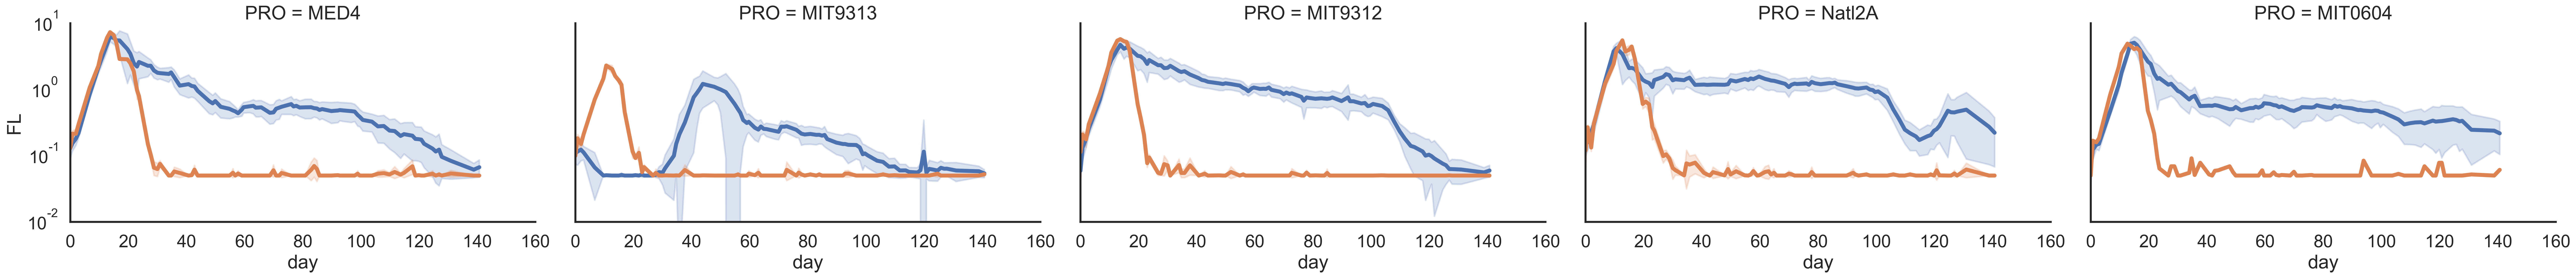

In [55]:
sns.set(context='poster', style='white', #font_scale=1.5
       )
g = sns.relplot(data=df.loc[df.experiment.isin(['e1']) & df.culture.isin(['Co_Culture', 'Axenic'])]
                , #row='experiment_list', #row='experiment',
                col='PRO',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, #err_style='bars',
            linewidth=5,
            x='day', y='FL', kind='line', hue='culture', #legend=False, 
            #hue_order=porder, palette=ppallete,
               #style='PRO', style_order=porder, markers=pmarkers
                legend=False
               )
g.set(yscale='log')
#plt.title('Co-cultures')
#plt.ylim((0,8))
#plt.yticks([0,4,8])
#plt.xticks([0,40,60, 80,100,120, 140])
#leg = g.ax.legend()
#leg = g._legend
#for lh in leg.get_lines(): 
#    lh.set_linewidth(5)
plt.show()


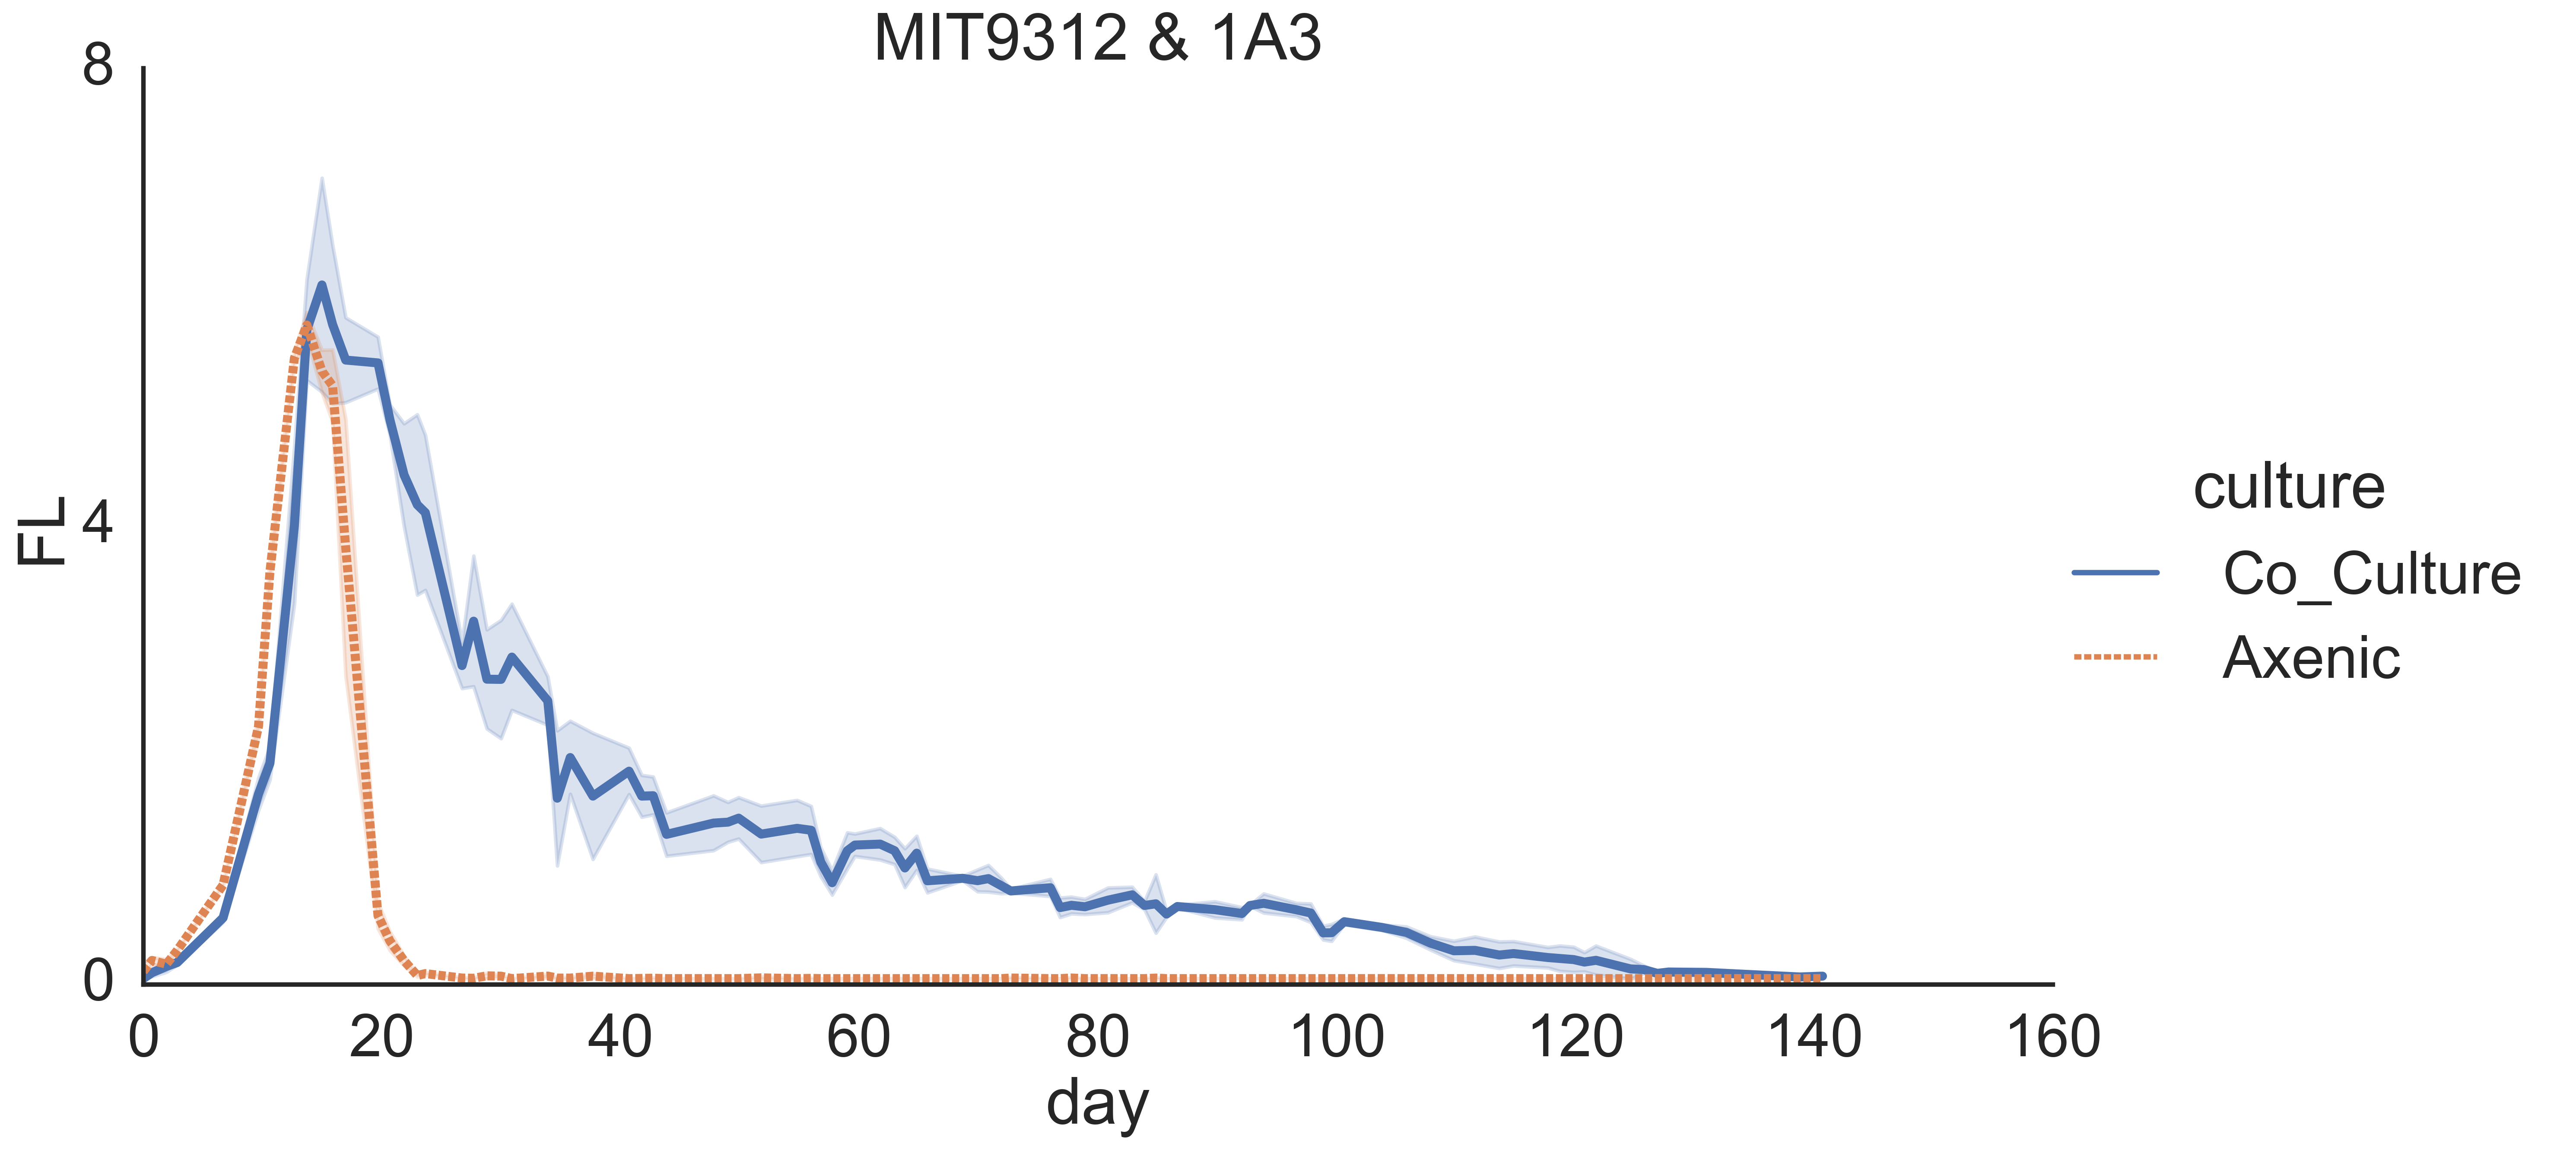

In [56]:
sns.set(context='poster', style='white', font_scale=1.5
       )
g = sns.relplot(data=df.loc[df.experiment.isin(['e1']) & df.culture.isin(['Co_Culture', 'Axenic']) & 
                            df.PRO.isin(['MIT9312']) & df.ALT.isin(['1A3', 'Ax_Pro'])]
                , #row='experiment_list', #row='experiment',
                #col='PRO',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, height=9,#err_style='bars',
            linewidth=5,
            x='day', y='FL', kind='line', hue='culture', style='culture', 
                #legend=False, 
            #hue_order=porder, palette=ppallete,
               #style='PRO', style_order=porder, markers=pmarkers
                #legend_out=False
               )
#g.set(yscale='log')
plt.title('MIT9312 & 1A3')
#plt.ylim((0,8))
plt.yticks([0,4,8])
#plt.xticks([0,40,60, 80,100,120, 140])
#leg = g.ax.legend()
#leg = g._legend
#for lh in leg.get_lines(): 
#    lh.set_linewidth(5)
plt.show()


In [57]:
df_93121a3_1 = df.loc[df.experiment.isin(['e1']) & df.culture.isin(['Co_Culture', 'Axenic']) & 
                            df.PRO.isin(['MIT9312']) & df.ALT.isin(['1A3', 'Ax_Pro'])]
df_93121a3_2 = exp2_df.loc[exp2_df.culture.isin(['Co_Culture', 'Axenic']) & 
                            exp2_df.PRO.isin(['MIT9312']) & exp2_df.ALT.isin(['1A3', 'Ax_Pro'])]
df_93121a3_2['day'] = df_93121a3_2['day'] + df_93121a3_1['day'].max()
df_93121a3 = pd.concat([df_93121a3_1, df_93121a3_2])


C:\Users\Osnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


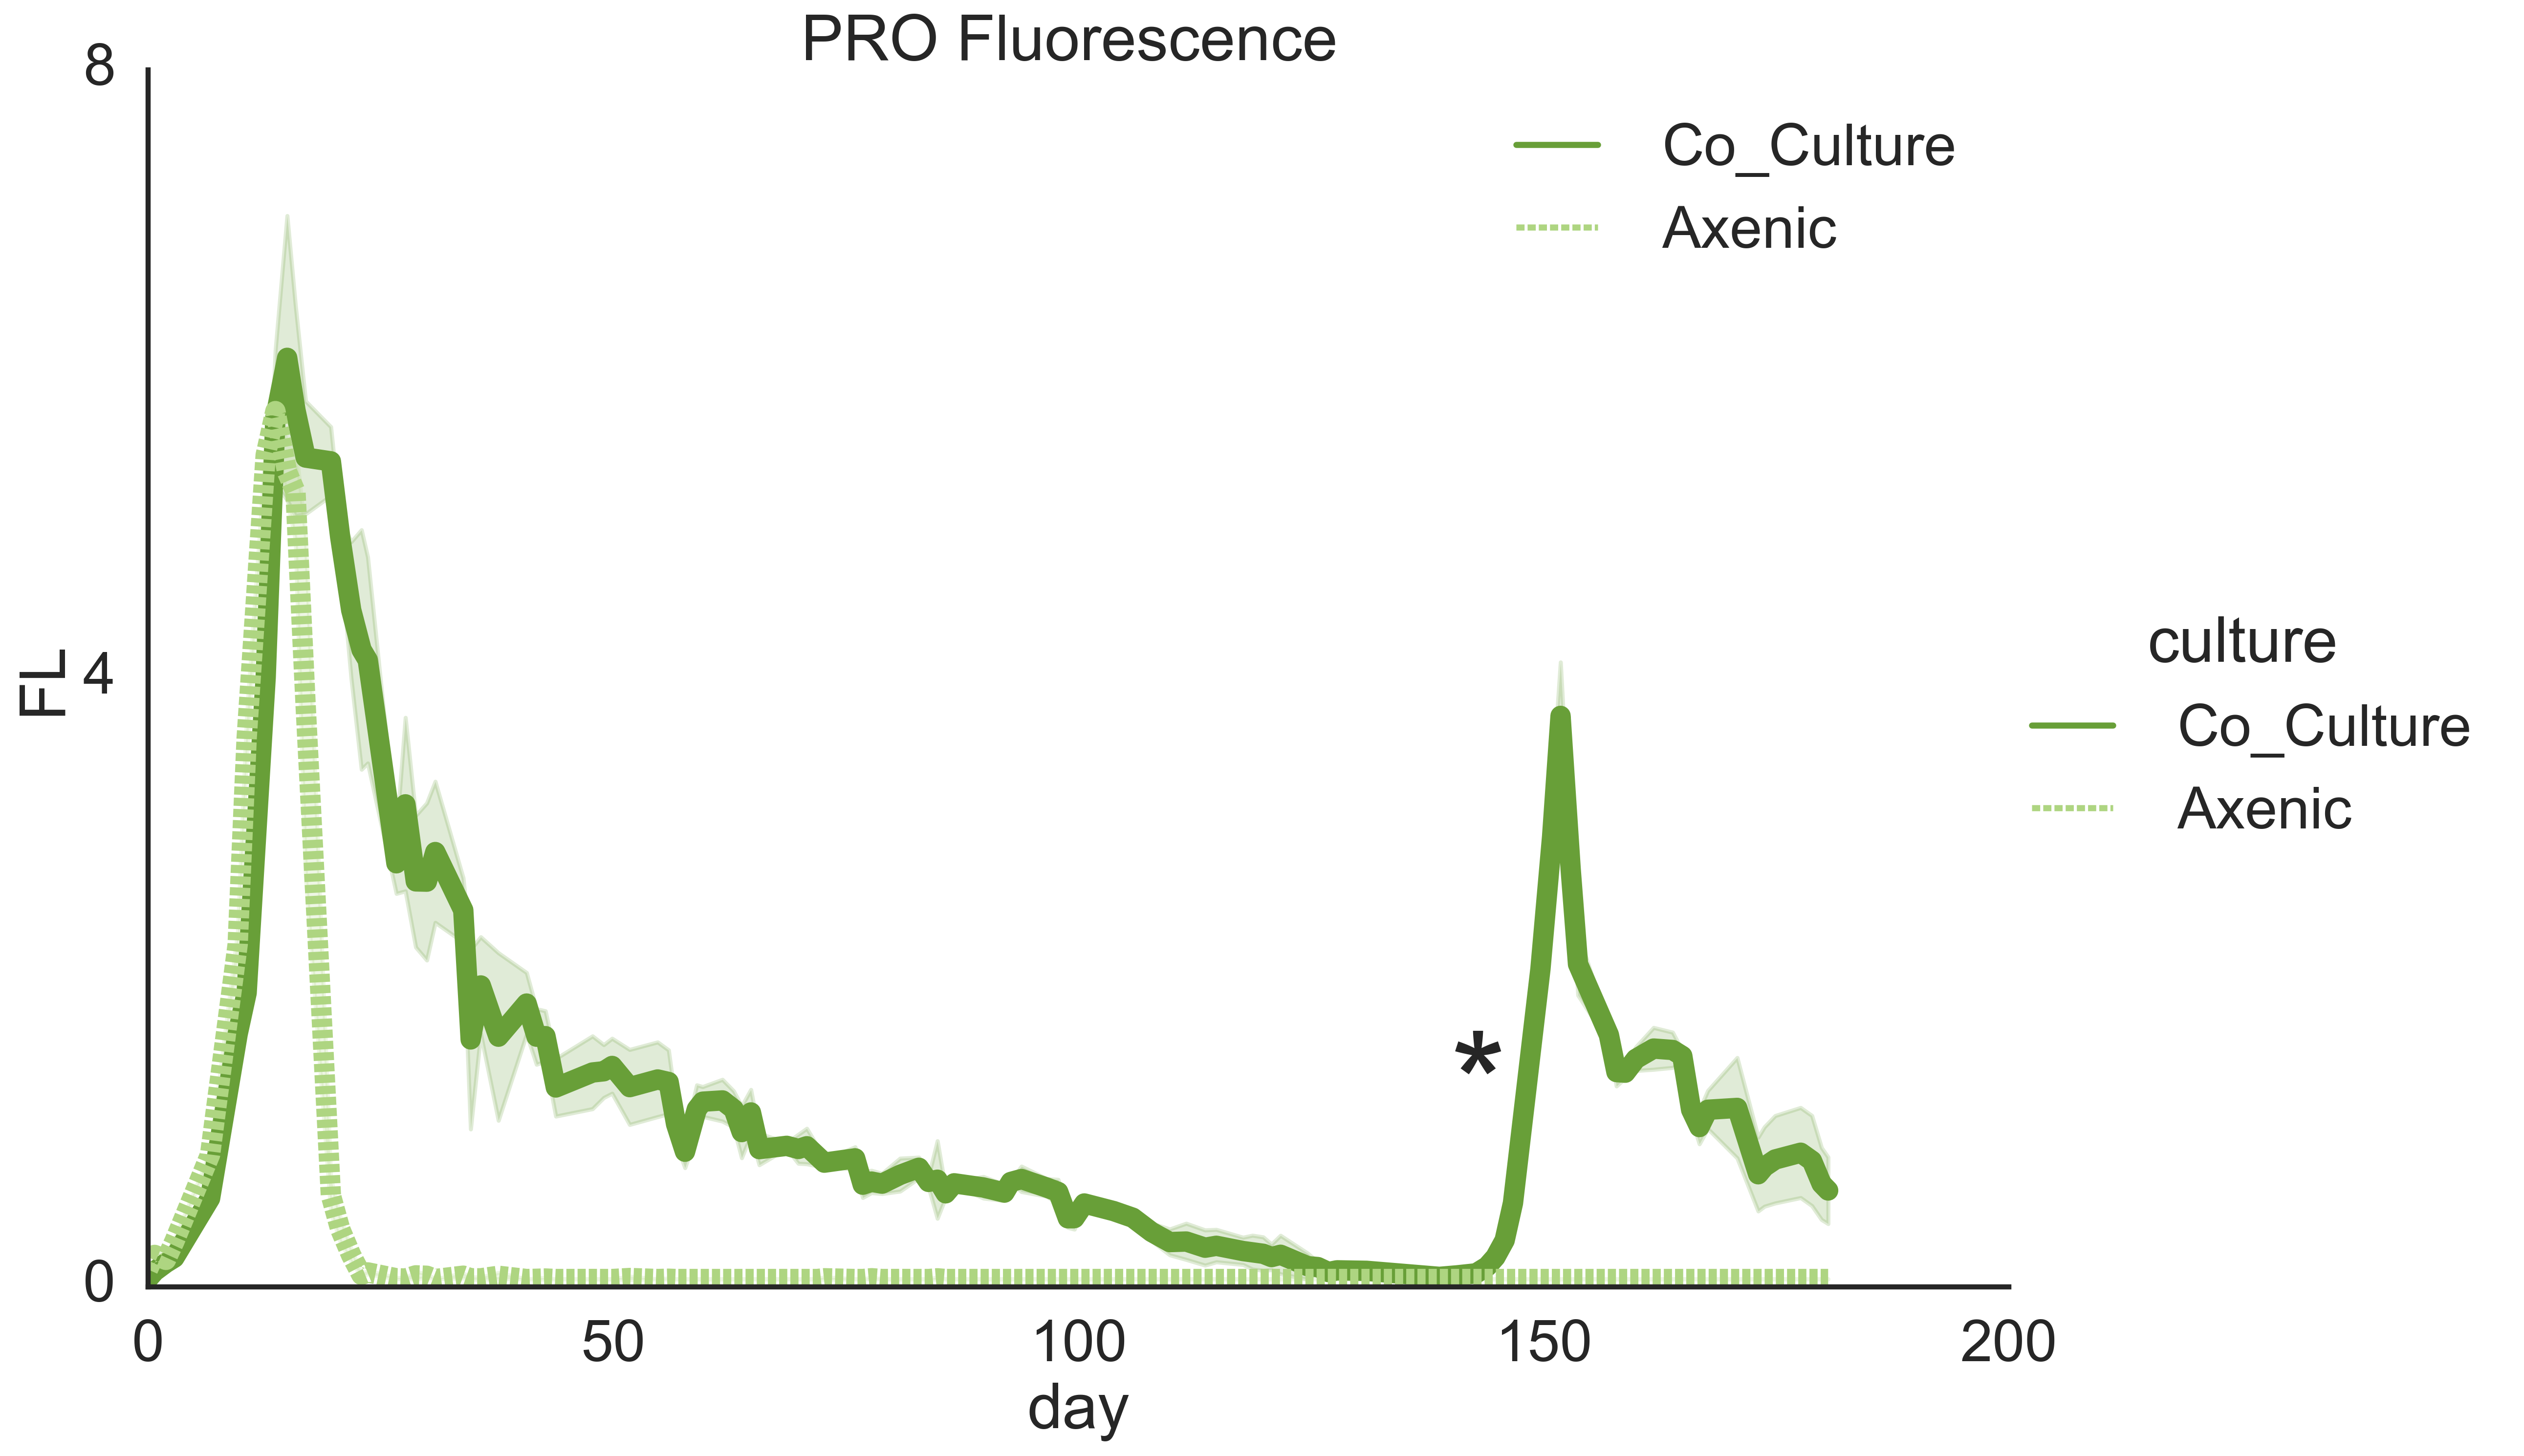

In [58]:
sns.set(context='poster', style='white', font_scale=1.3
       )
g = sns.relplot(data=df_93121a3
                , #row='experiment_list', #row='experiment',
                #col='PRO',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.4, height=10,#err_style='bars',
            linewidth=10,
            x='day', y='FL', kind='line', hue='culture', style='culture', 
                hue_order=['Co_Culture', 'Axenic'],
                palette=['#689f38', '#aed581'],
        #facet_kws=dict(legend_out=False),
                #legend=False, 
            #hue_order=porder, palette=ppallete,
               #style='PRO', style_order=porder, markers=pmarkers
               )
#g.set(yscale='log')
g.ax.text(140, 1, '*', fontsize=70
      )
plt.title('PRO Fluorescence ')
#plt.ylim((0,8))
handles, labels = g.ax.get_legend_handles_labels()
g.ax.legend(handles=handles[1:], labels=labels[1:])

plt.yticks([0,4,8])
plt.legend( frameon=False, )
plt.show()


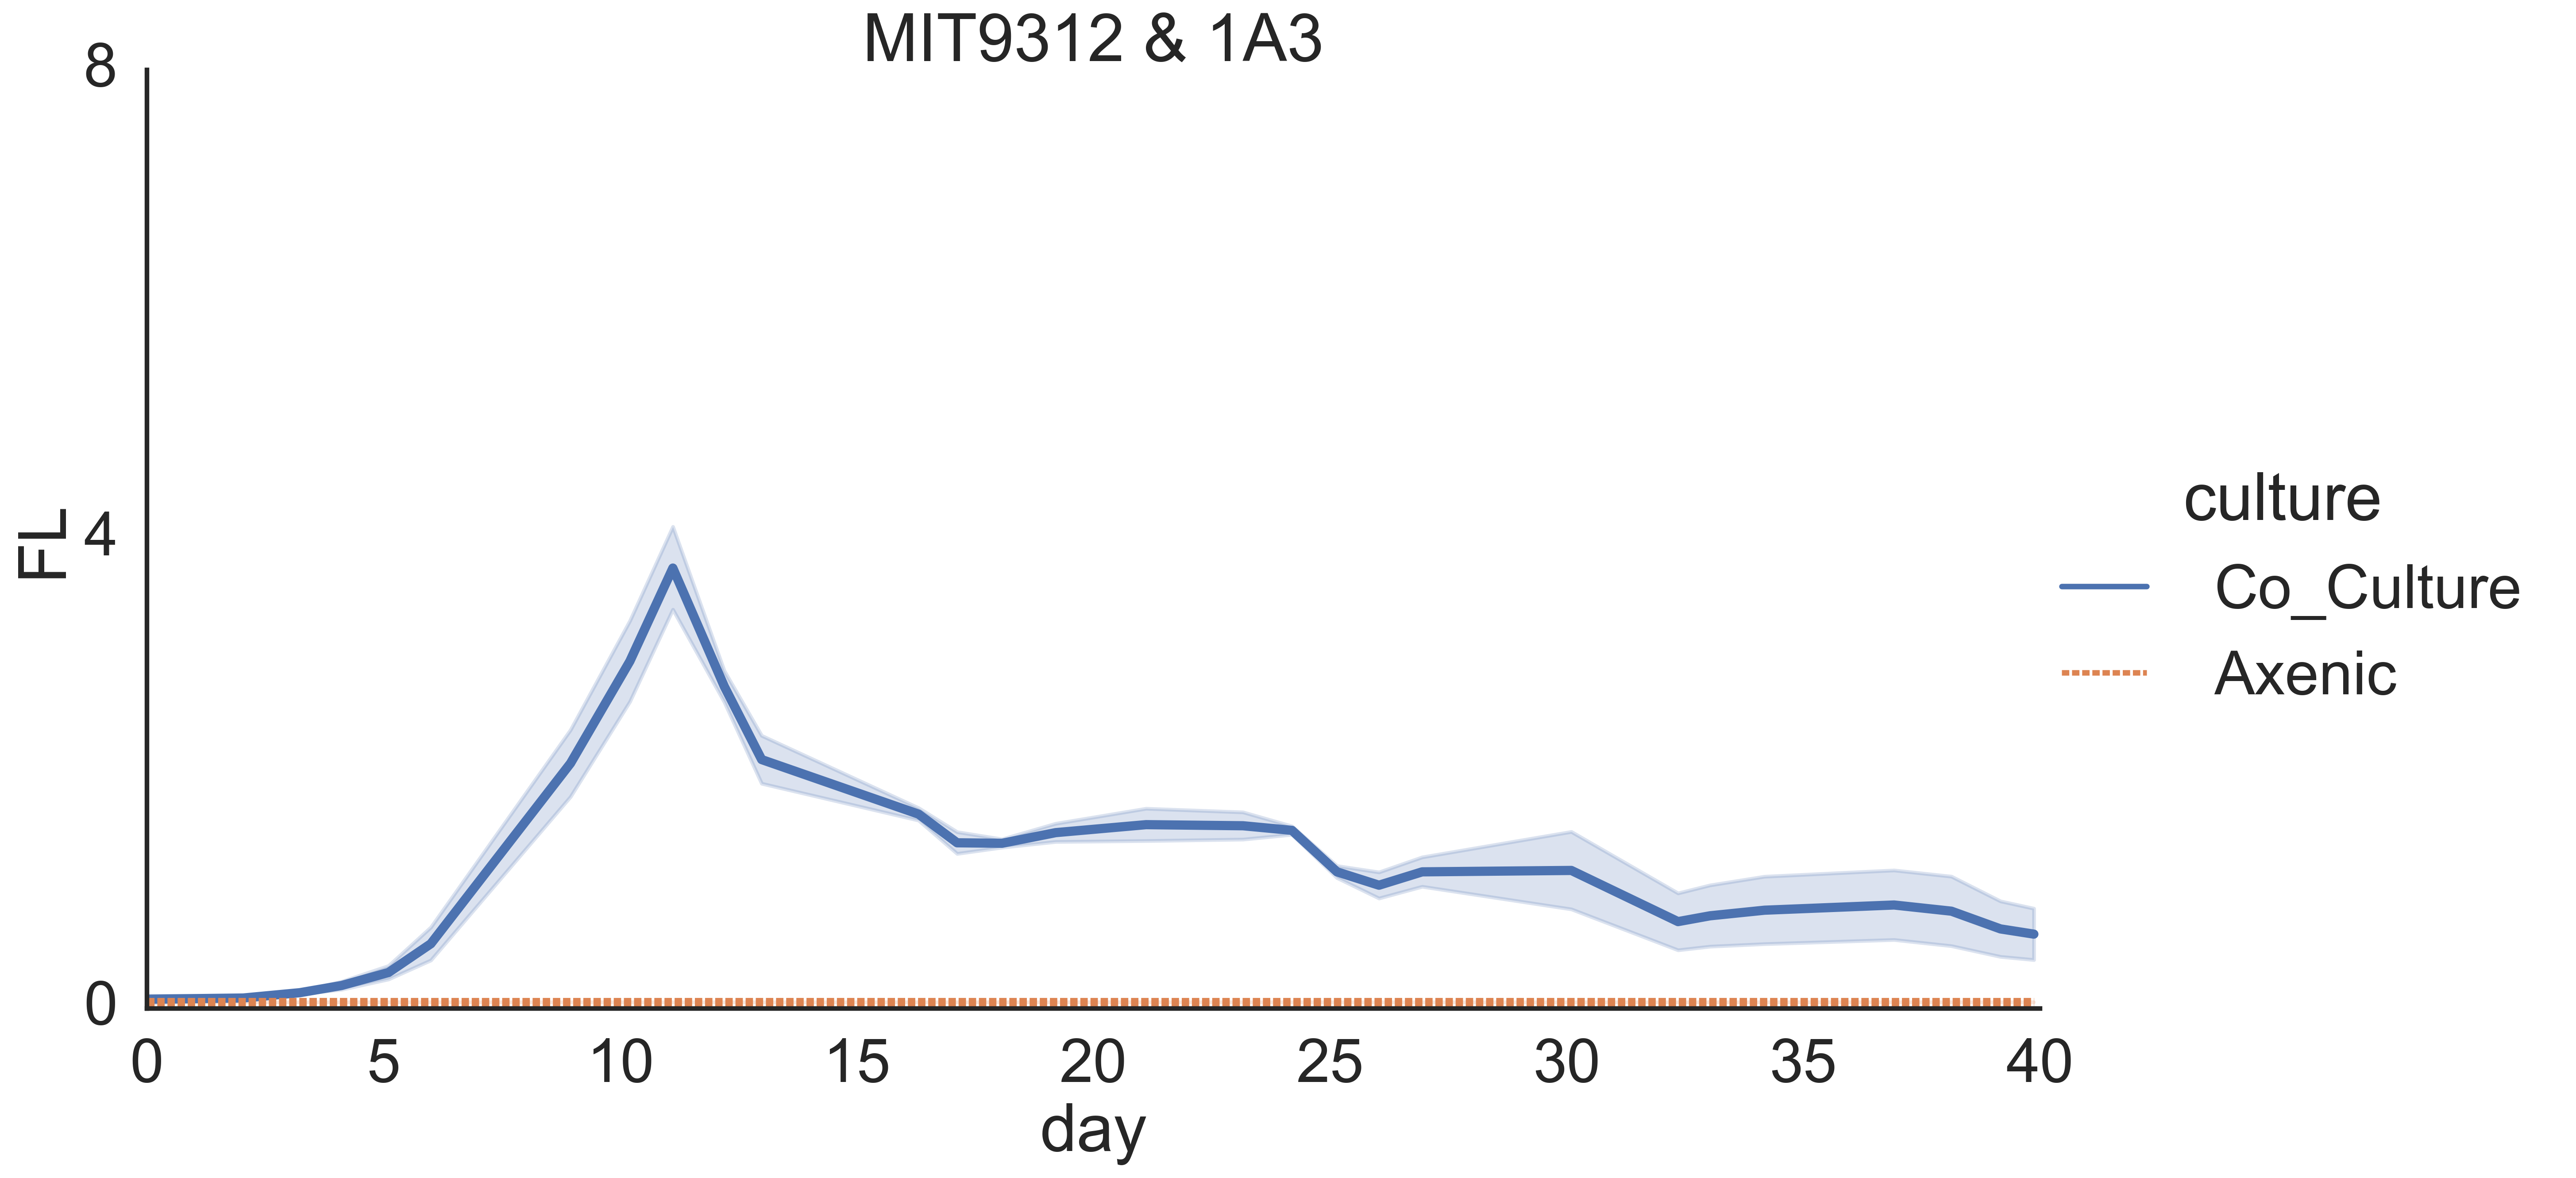

In [59]:
sns.set(context='poster', style='white', font_scale=1.5
       )
g = sns.relplot(data=exp2_df.loc[exp2_df.culture.isin(['Co_Culture', 'Axenic']) & 
                            exp2_df.PRO.isin(['MIT9312']) & exp2_df.ALT.isin(['1A3', 'Ax_Pro'])]
                , #row='experiment_list', #row='experiment',
                #col='PRO',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, height=9,#err_style='bars',
            linewidth=5,
            x='day', y='FL', kind='line', hue='culture', style='culture', 
                #legend=False, 
            #hue_order=porder, palette=ppallete,
               #style='PRO', style_order=porder, markers=pmarkers
                #legend_out=False
               )
#g.set(yscale='log')
plt.title('MIT9312 & 1A3')
#plt.ylim((0,8))
plt.yticks([0,4,8])
#plt.xticks([0,40,60, 80,100,120, 140])
#leg = g.ax.legend()
#leg = g._legend
#for lh in leg.get_lines(): 
#    lh.set_linewidth(5)
plt.show()


In [60]:
df.ALT.unique()

array(['1A3', 'DE', 'DE1', 'BS11', 'ATCC', 'Ax_Pro', 'all_Pro', 'all'],
      dtype=object)

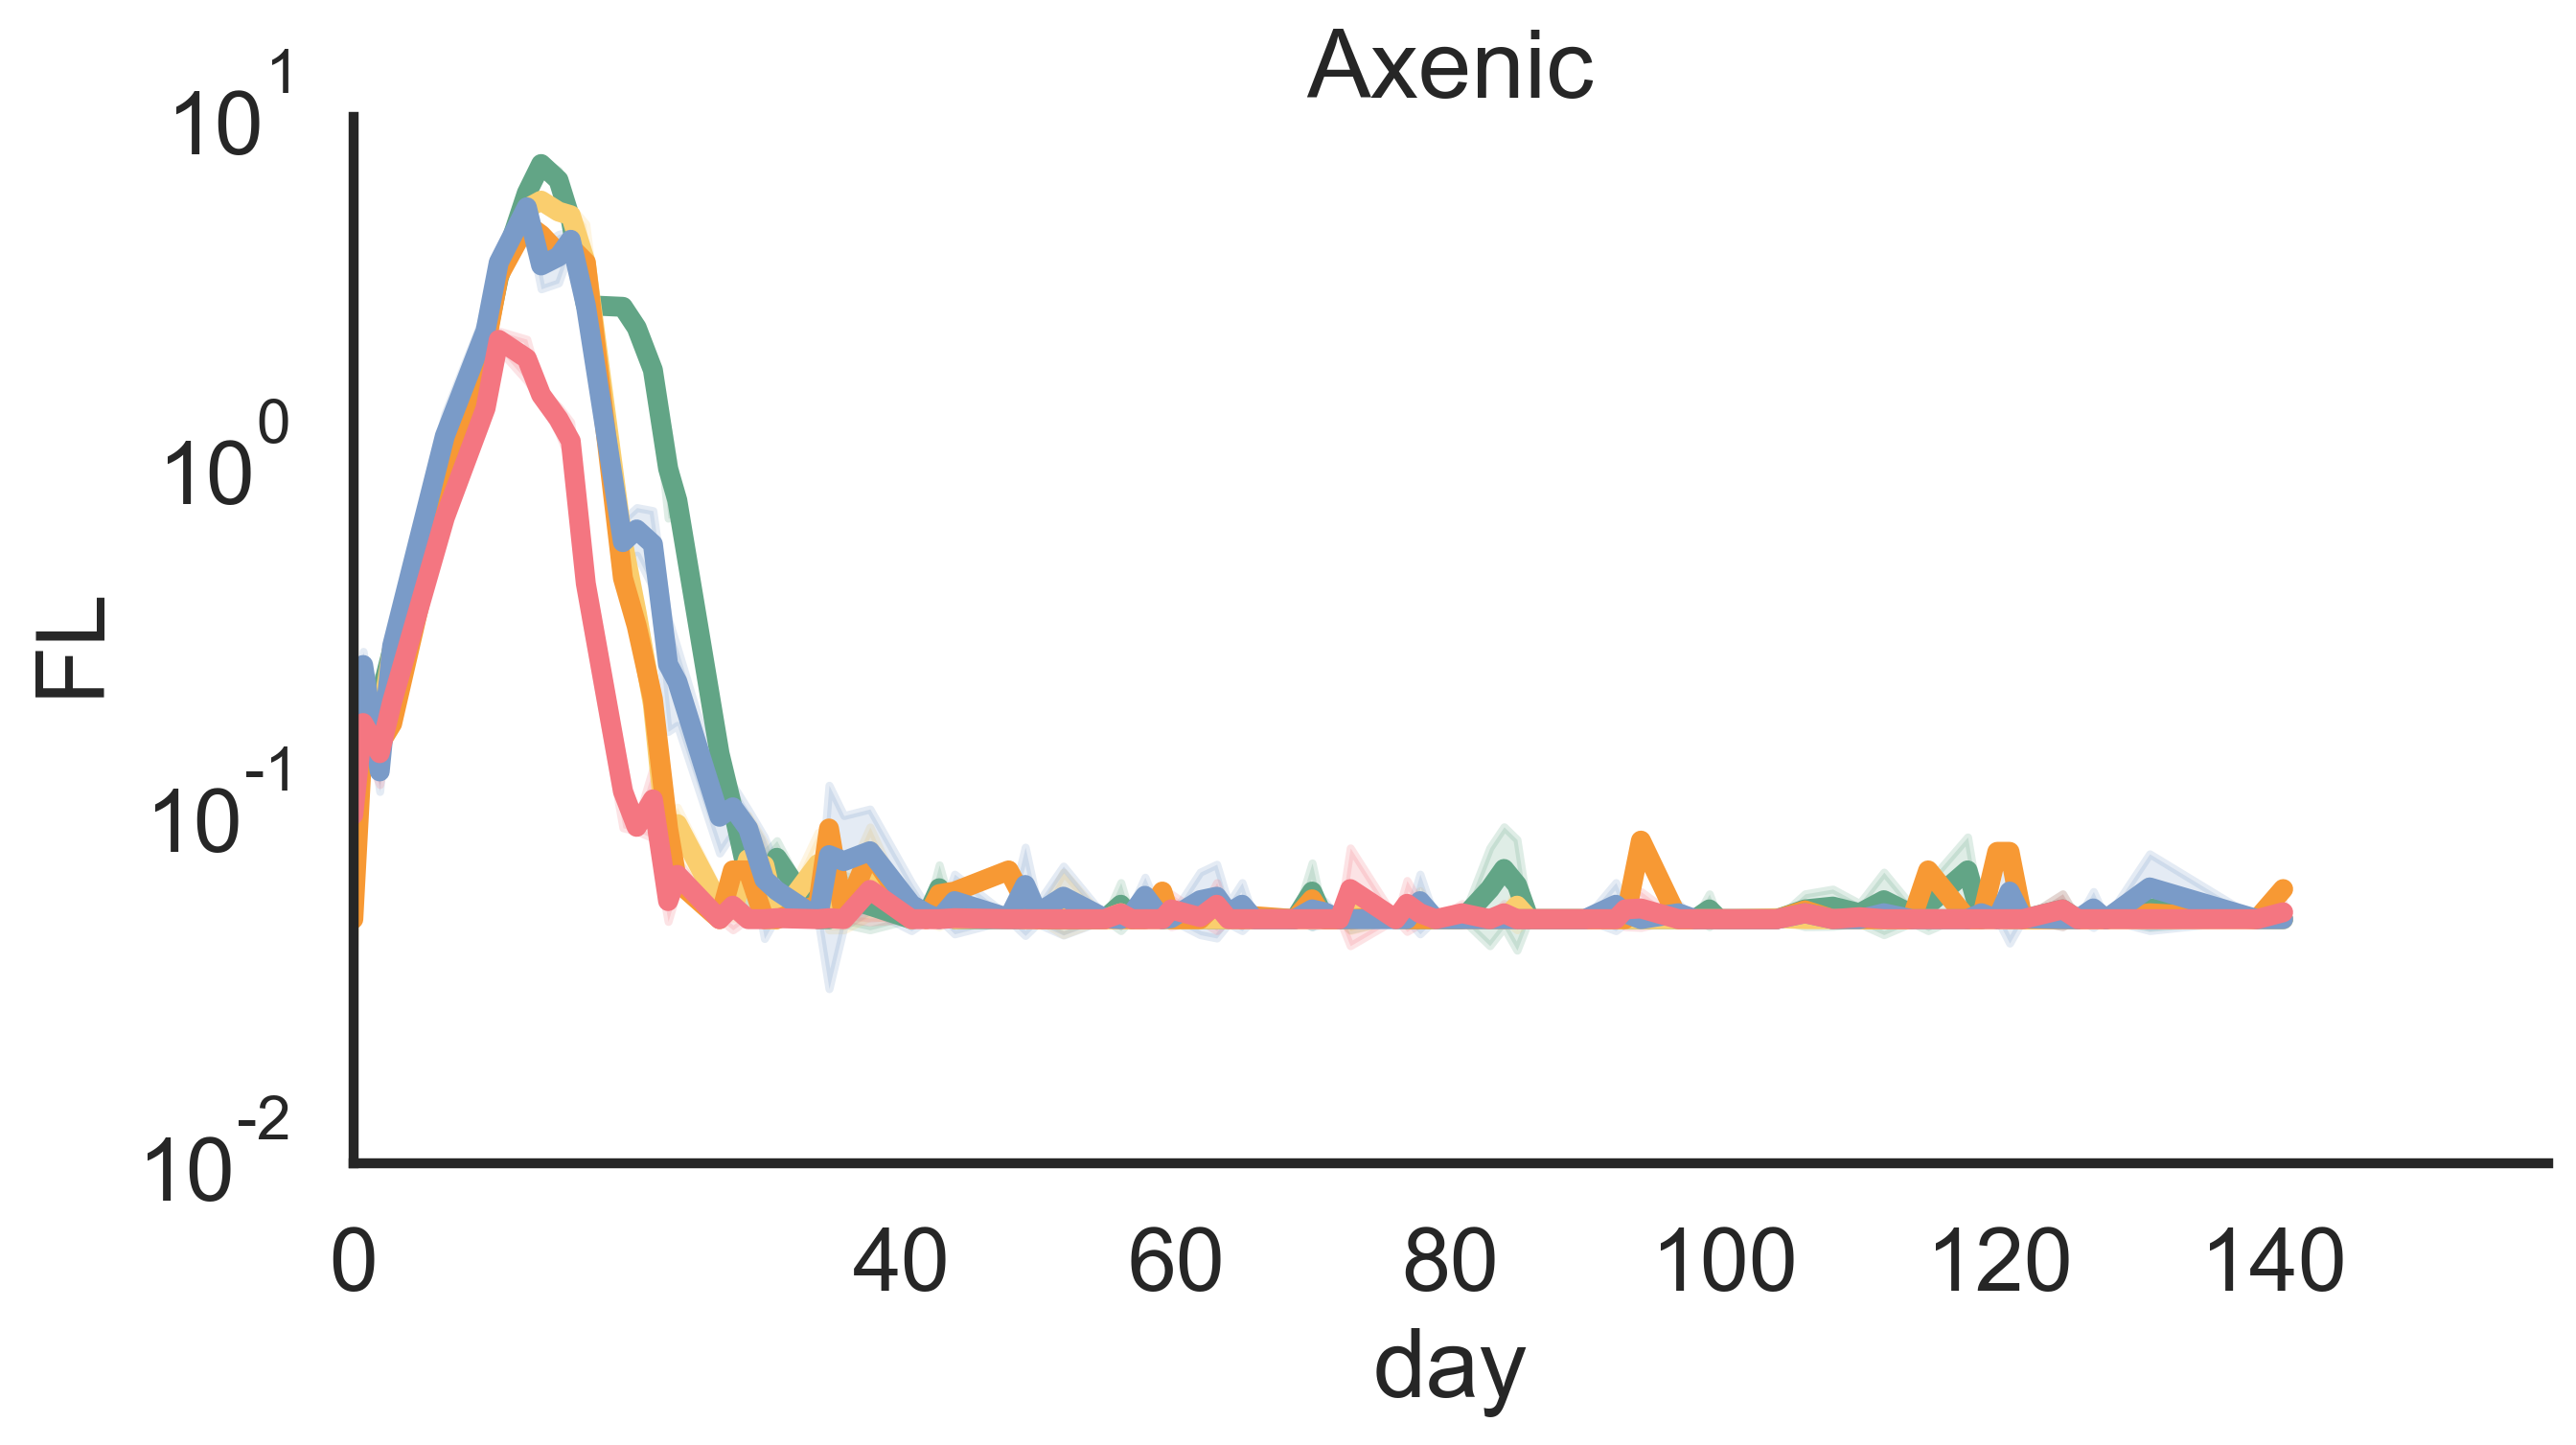

In [61]:
sns.set(context='poster', style='white', #font_scale=1.5
       )
g = sns.relplot(data=df.loc[df.experiment.isin(['e1']) & df.culture.isin(['Axenic'])]
                , #row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, #err_style='bars',
            linewidth=5,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete,
               #style='PRO', style_order=porder, markers=pmarkers
                legend=False
               )
g.set(yscale='log')
plt.title('Axenic')
#plt.ylim((0,8))
#plt.yticks([0,4,8])
plt.xticks([0,40,60, 80,100,120, 140])
#leg = g.ax.legend()
#leg = g._legend
#for lh in leg.get_lines(): 
#    lh.set_linewidth(5)
plt.show()


In [62]:
df.culture.unique()

array(['Co_Culture', 'Axenic', 'All_Pro', 'All_strains'], dtype=object)

In [64]:
exp2_df.head()

PRO  ALT sample day     FL experiment     culture  FL_orig     logFL  \
0     MED4  1A3     1A   0  0.050         e2  Co_Culture    0.027 -2.995732   
1     MED4  1A3     1B   0  0.050         e2  Co_Culture    0.027 -2.995732   
2     MED4  1A3     1C   0  0.063         e2  Co_Culture    0.063 -2.764621   
3  MIT9313  1A3     2A   0  0.050         e2  Co_Culture    0.036 -2.995732   
4  MIT9313  1A3     2B   0  0.050         e2  Co_Culture    0.045 -2.995732   

   cumsumFL  cumsumlogFL  zscoreFL  diffFL  difflogFL diffday rateFL  \
0     0.050    -2.995732 -1.136112     NaN        NaN     NaN    NaN   
1     0.050    -2.995732 -0.939761     NaN        NaN     NaN    NaN   
2     0.063    -2.764621 -0.926958     NaN        NaN     NaN    NaN   
3     0.050    -2.995732 -0.550824     NaN        NaN     NaN    NaN   
4     0.050    -2.995732 -0.576194     NaN        NaN     NaN    NaN   

  ratelogFL experiment_sample  
0       NaN            e2, 1A  
1       NaN            e2, 1B  
2       NaN            e2, 1C  
3       NaN            e2, 2A  
4       NaN            e2, 2B

In [66]:
exp2_df.loc[(exp2_df.experiment == 'e2') & (exp2_df.culture == 'Axenic')]

PRO     ALT sample        day     FL experiment culture  FL_orig  \
75        C9B  Ax_Pro    26A          0  0.050         e2  Axenic    0.005   
76        C9B  Ax_Pro    26B          0  0.050         e2  Axenic    0.014   
77        C9B  Ax_Pro    26C          0  0.050         e2  Axenic    0.000   
78     Natl2A  Ax_Pro    27A          0  0.050         e2  Axenic    0.005   
79     Natl2A  Ax_Pro    27B          0  0.050         e2  Axenic   -0.005   
...       ...     ...    ...        ...    ...        ...     ...      ...   
3214  all pro  Ax_Pro    36B  39.872917  0.226         e2  Axenic    0.226   
3215  all pro  Ax_Pro    36C  39.872917  0.050         e2  Axenic    0.014   
3216      all  Ax_Pro    37A  39.872917  0.260         e2  Axenic    0.260   
3217      all  Ax_Pro    37B  39.872917  0.264         e2  Axenic    0.264   
3218      all  Ax_Pro    37C  39.872917  0.292         e2  Axenic    0.292   

         logFL  cumsumFL  cumsumlogFL  zscoreFL  diffFL  difflogFL   diffday  \
75   -2.995732     0.050    -2.995732 -0.198310     NaN        NaN       NaN   
76   -2.995732     0.050    -2.995732 -0.199027     NaN        NaN       NaN   
77   -2.995732     0.050    -2.995732 -0.602846     NaN        NaN       NaN   
78   -2.995732     0.050    -2.995732 -0.274478     NaN        NaN       NaN   
79   -2.995732     0.050    -2.995732       NaN     NaN        NaN       NaN   
...        ...       ...          ...       ...     ...        ...       ...   
3214 -1.487220    16.630   -31.418395 -0.607906   0.007   0.031463  0.704167   
3215 -2.995732     1.455   -86.780926 -0.188982   0.000   0.000000  0.704167   
3216 -1.347074    21.290   -21.184652 -0.553488   0.012   0.047253  0.704167   
3217 -1.331806    23.046   -15.749896 -0.652862  -0.019  -0.069498  0.704167   
3218 -1.231001    23.092   -14.811526 -0.653986  -0.003  -0.010222  0.704167   

        rateFL ratelogFL experiment_sample  
75         NaN       NaN           e2, 26A  
76         NaN       NaN           e2, 26B  
77         NaN       NaN           e2, 26C  
78         NaN       NaN           e2, 27A  
79         NaN       NaN           e2, 27B  
...        ...       ...               ...  
3214  0.009941  0.044682           e2, 36B  
3215       0.0       0.0           e2, 36C  
3216  0.017041  0.067105           e2, 37A  
3217 -0.026982 -0.098695           e2, 37B  
3218  -0.00426 -0.014516           e2, 37C  

[609 rows x 18 columns]

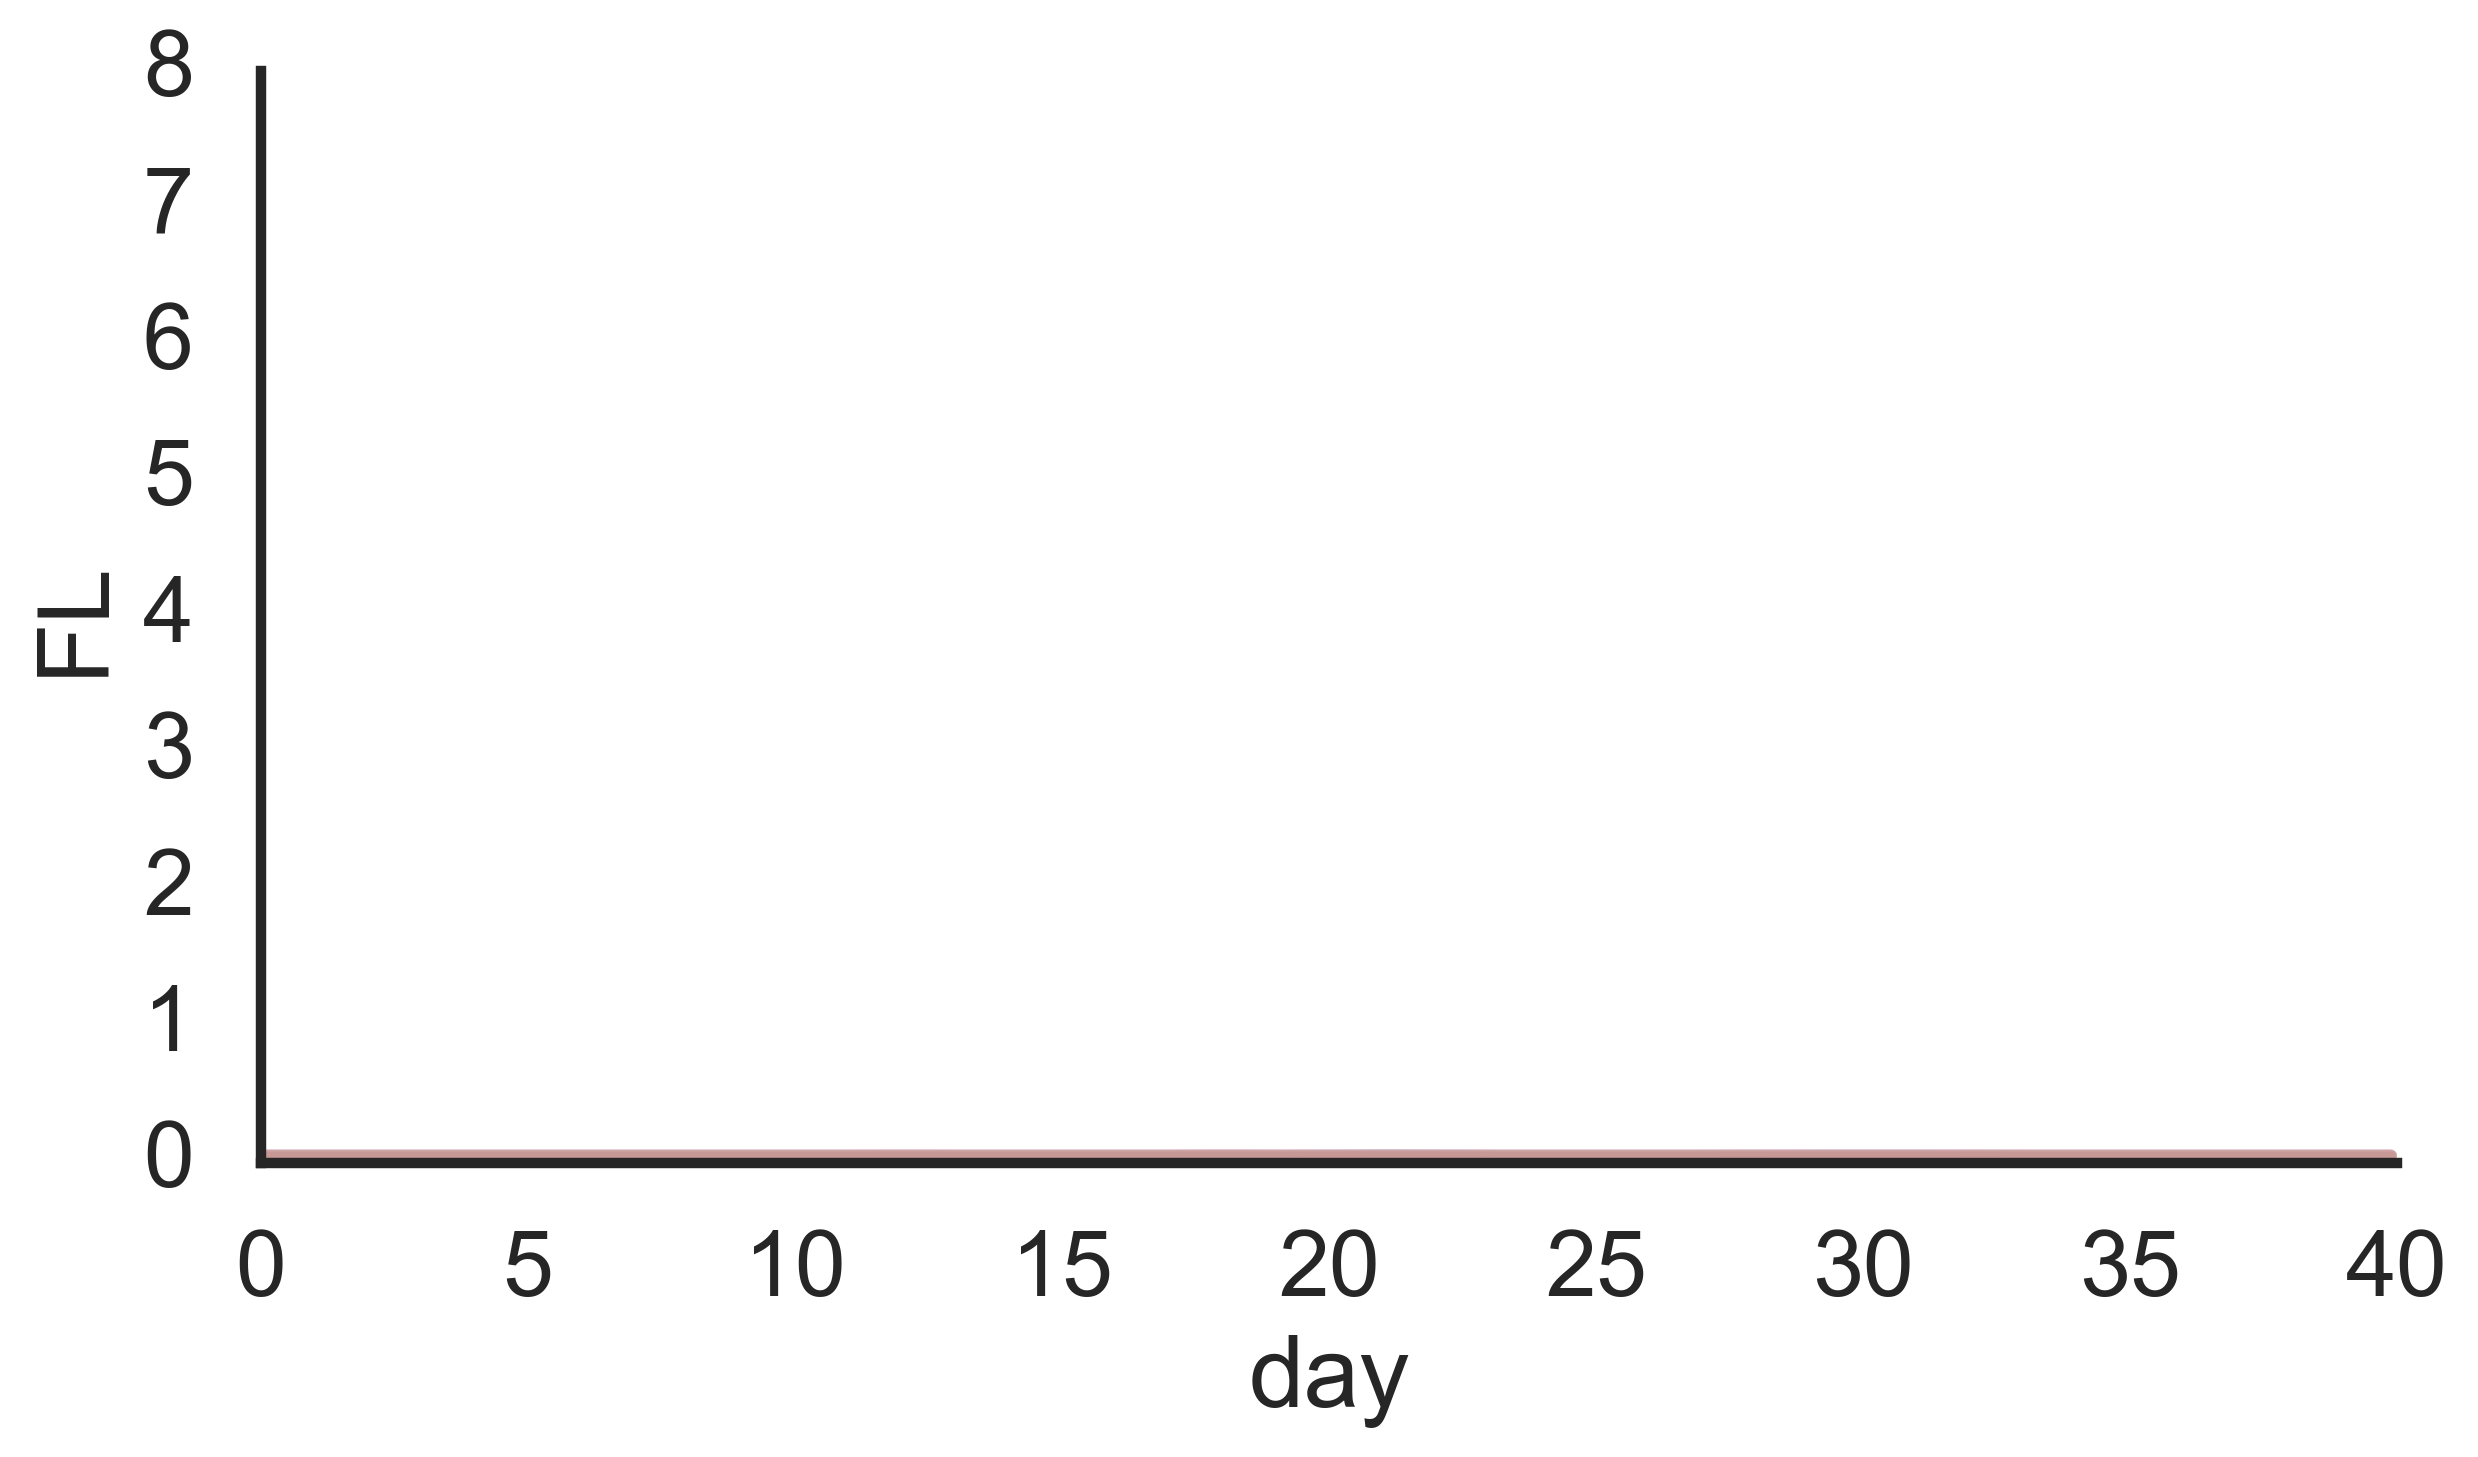

In [71]:
sns.set(context='poster', style='white')


g = sns.relplot(data=exp2_df.loc[(exp2_df.experiment == 'e2') & (exp2_df.culture == 'Axenic')], #row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, #err_style='bars',
            #linewidth=5,
                alpha=0.4,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
               #style='PRO', style_order=porder, markers=pmarkers,
                legend=False,
            hue_order=porder, palette=ppallete)
#g.set(yscale='log')
#plt.title('Axenic')
plt.ylim((0,8))
#leg = g._legend
# g.ax.legend(frameon=False)
#plt.yticks([0,4,8])
#plt.xticks([0,70,140])

#for lh in leg.legendHandles: 
#    #print(lh)
#    lh.set_linewidth(10)
plt.show()

In [ ]:
g.ax.legend

In [ ]:
sns.set_context('paper')
g = sns.relplot(data=df1, #row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, #err_style='bars',
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
                linewidth=5,
            hue_order=porder, palette=ppallete)
g.set(yscale='log')
plt.title('Experiment 1: FL (log scale)')

In [ ]:
sns.set_context('paper')
g = sns.relplot(data=df1, #row='experiment_list', #row='experiment',
            estimator=None, units='experiment_sample', #row='ALT',
            #row_order=aorder, col_order=porder,
            #ci='sd', 
            aspect=1.8, #err_style='bars',
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
g.set(yscale='log')

In [ ]:
df_features_1 = cp.generate_features(df1)


In [ ]:
df_features_1.columns

In [ ]:
sns.set_context('paper')
df_features_1_new = cp.generate_features(df.loc[(df.experiment == 'e1') & df.culture.isin(['Axenic','Co_Culture'])
                                                ])

sns.catplot(data=df_features_1_new, x='PRO', y='decline_10precent', order=porder, palette=ppallete, kind='box',
           col='culture')
plt.suptitle('Time of 90% decline in FL (days)', y=1)
sns.catplot(data=df_features_1_new, x='ALT', y='decline_10precent', order=aorder, palette=apallete, kind='box')
plt.ylim((0,160))
plt.title('Time of 90% decline in FL (days)')
#sns.catplot(data=df_features_1, x='PRO', y='auc', order=porder, palette=ppallete, kind='box')
#sns.catplot(data=df_features_1, x='PRO', y='max_day', order=porder, palette=ppallete, kind='box')


In [ ]:
df_features_1_new.decline_10precent

In [ ]:
sns.set_context('paper')
sns.catplot(data=df_features_1, x='PRO', y='decline_auc', order=porder, palette=ppallete, kind='box')
sns.catplot(data=df_features_1, x='ALT', y='decline_auc', order=aorder, palette=apallete, kind='box')
#sns.catplot(data=df_features_1, x='PRO', y='auc', order=porder, palette=ppallete, kind='box')
#sns.catplot(data=df_features_1, x='PRO', y='max_day', order=porder, palette=ppallete, kind='box')


In [ ]:
sns.catplot(data=df_features_1, x='PRO', y='auc', order=porder, palette=ppallete, kind='box')
sns.catplot(data=df_features_1, x='ALT', y='auc', order=aorder, palette=apallete, kind='box')
sns.catplot(data=df_features_1, x='ALT', y='auc', order=aorder, palette=ppallete, hue='PRO', hue_order=porder, kind='box')
#sns.catplot(data=df_features_1, x='PRO', y='auc', order=porder, palette=ppallete, kind='box')
#sns.catplot(data=df_features_1, x='PRO', y='max_day', order=porder, palette=ppallete, kind='box')


In [ ]:
from scipy.stats import f_oneway

In [ ]:
df_features_1.head()

In [ ]:
lst = [df_features_1.loc[df_features_1.PRO==p, 'max'].tolist()
       for p in df_features_1.PRO.unique()]
#lst   
f_oneway(*lst)[0]

In [ ]:
df_features_1.columns

In [ ]:
def run_anova(f):
    lst = [df_features_1.loc[df_features_1.PRO==p, f].tolist()
       for p in df_features_1.PRO.unique()]
    anova = f_oneway(*lst)
    return f, anova[0], anova[1]

In [ ]:
lst = [run_anova(i) for i in df_features_1.columns if i not in ['experiment', 'sample', 'PRO', 'ALT', 'culture'] ]

In [ ]:
anova_df1 = pd.DataFrame(data=lst, columns=['featue', 'anova', 'pvalue'])

In [ ]:
anova_df1.loc[anova_df1.pvalue <0.05].nlargest(10, 'anova')

In [ ]:
col = 'PRO'
#lut = dict(zip(df_features_1[col].unique(), sns.color_palette('Set2', n_colors=df_features_1[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=df_features_1[col].nunique())))
row_colors = df_features_1[col].map(lut)

col2 = 'experiment'
#lut2 = dict(zip(df_features_1[col2].unique(), sns.color_palette('Set3', n_colors=df_features_1[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=df_features_1[col2].nunique())))
row_colors2 = df_features_1[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=df_features_1[col3].nunique())))
row_colors3 = df_features_1[col3].map(lut3)


In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=df_features_1['auc'], col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [ ]:
sns.set_context('poster')
t = df_features_1.pivot_table(index='ALT', columns=['PRO'], 
                                              values=['auc'], aggfunc='mean')
t.columns = t.columns.get_level_values(1)
t = t[porder]
t =t.reindex(aorder)
sns.heatmap(t, #annot=True, 
            cmap='coolwarm')
plt.title('mean auc')

In [ ]:
sns.set_context('talk')
t = df_features_1.pivot_table(index='ALT', columns=['PRO'], 
                                              values=['decline_auc'], aggfunc='mean')
t.columns = t.columns.get_level_values(1)
t = t[porder]
t =t.reindex(aorder)
sns.heatmap(t, #annot=True, 
            cmap='coolwarm')
plt.title('mean decline auc')

# compare experiments

In [ ]:
dfc.head()

In [ ]:
sns.set_context('paper')
g = sns.relplot(data=dfc.loc[(dfc.PRO=='MIT9313') & (dfc.ALT == '1A3')]
                , #row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, #err_style='bars',
            linewidth=5,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)
#g.set(yscale='log')
plt.title('MIT9313 & 1A3 - compare experiments')

In [ ]:
sns.set_context('paper')
g = sns.relplot(data=dfc.loc[(dfc.ALT == '1A3')]
                , #row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, #err_style='bars',
            linewidth=5,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete,
               row='PRO',
                row_order=porder,
               )
#g.set(yscale='log')
plt.title('1A3 co-cultures - compare experiments')

In [ ]:
sample_col = 'experiment_sample'
X = cp.experiments2X(dfc.loc[dfc.experiment.isin(['e3','e4'])], value_col='FL', cumsummode=True)
metadf = cp.get_meta(dfc.loc[dfc.experiment.isin(['e3','e4'])])
#metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:

ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='culture', 
            style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2, markers=amarkers,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )
plt.xlabel('PCA1 (86%)')
plt.ylabel('PCA2 (7%)')
plt.title('PCA: Experiment 3&4 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

In [ ]:
sample_col = 'experiment_sample'
X = cp.experiments2X(dfc.loc[dfc.experiment.isin(['e3','e4', 'e5','e6', ])], value_col='FL', cumsummode=True)
metadf = cp.get_meta(dfc.loc[dfc.experiment.isin(['e3','e4', 'e5','e6', ])])
#metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:

ax = sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='culture', 
            style='PRO', style_order=porder,
            s=120, alpha=0.9, height=7, aspect=1.2, 
            palette=epallete, hue_order=eorder ,edgecolor='lightgrey',
           )
plt.xlabel('PCA1 (73%)')
plt.ylabel('PCA2 (16%)')
plt.title('PCA: Experiment 3&4 vs 5&6 co-cultures')
for lh in ax._legend.legendHandles: 
    lh.set_sizes([70])

In [ ]:
sns.set_context('paper')
g = sns.relplot(data=dfc.loc[dfc.experiment.isin(['e3'])],
                #row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, #err_style='bars',
            linewidth=5,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
g.set(yscale='log')
plt.title('Experiment 3: FL (log)')


In [ ]:
sns.set_context('paper')
g = sns.relplot(data=dfc.loc[dfc.experiment.isin(['e3'])],
                #row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8, #err_style='bars',
            linewidth=5,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
#g.set(yscale='log')
plt.title('Experiment 3: FL (log)')

In [ ]:
sns.relplot(data=dfc, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT', row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

In [ ]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

In [ ]:
ds['experiment_list'] = ''
ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'
ds.loc[ds.experiment.isin(['e1']), 'experiment_list'] = 'e1'


g = sns.relplot(data=ds, hue='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', #aspect=1.8,
            x='day', y='FL', kind='line', col='PRO', #legend=False, 
            #hue_order=porder, 
                palette=espallete,
                col_order=porder,
               )
#g.set(yscale='log')

In [ ]:
#ds['experiment_list'] = ''
#ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
#ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, hue='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', row='PRO', #legend=False, 
            #hue_order=porder, 
                palette=espallete,
                row_order=porder
               )
g.set(yscale='log')

In [ ]:
g = sns.relplot(data=ds, row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
#g.set(yscale='log')

In [ ]:
ds['experiment_list'] = ''
ds.loc[ds.experiment.isin(['e3','e4']), 'experiment_list'] = 'e3, e4'
ds.loc[ds.experiment.isin(['e5','e6']), 'experiment_list'] = 'e5, e6'


g = sns.relplot(data=ds, row='experiment_list', #row='experiment',
            #estimator=None, units='experiment_sample', row='ALT',
            #row_order=aorder, col_order=porder,
            ci='sd', aspect=1.8,
            x='day', y='FL', kind='line', hue='PRO', #legend=False, 
            hue_order=porder, palette=ppallete)
g.set(yscale='log')

In [ ]:
ds['decline'] = ds['FL']

In [ ]:
ds1 = ds.loc[ds.experiment.isin(['e1'])]
ds34 = ds.loc[ds.experiment.isin(['e3', 'e4'])]
ds56 = ds.loc[ds.experiment.isin(['e5', 'e6'])]

In [ ]:
ds1 = ds1.loc[ds1['sample'] != '25C']
ds34 = ds34.loc[ds34['sample'] != '25C']
ds56 = ds56.loc[ds56['sample'] != '25C']


In [ ]:
ds34.head()

In [ ]:
train1_df_orig, test1_df_orig = cp.split_train_test(ds1,test_size=0.4)
train34_df_orig, test34_df_orig = cp.split_train_test(ds34,test_size=0.4)
train56_df_orig, test56_df_orig = cp.split_train_test(ds56,test_size=0.4)

In [ ]:
test1_df_orig.groupby(['PRO', 'ALT'])['sample'].unique()

In [ ]:
train1_df = cp.augment_training(train1_df_orig, noise_N=3, augment_x=False)
test1_df = test1_df_orig
train34_df = cp.augment_training(train34_df_orig, noise_N=3, augment_x=False)
test34_df = test34_df_orig
train56_df = cp.augment_training(train56_df_orig, noise_N=3, augment_x=False)
test56_df = test56_df_orig

In [ ]:
train1_df.shape, test1_df.shape, train34_df.shape, test34_df.shape, train56_df.shape, test56_df.shape, 

In [ ]:
train34_df.columns

In [ ]:
stats34_list = []
y34_list = []
clf34_list = []
features34_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train34_df, test34_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats34_list.extend(res)
y34_list.extend(_y_list)
clf34_list.extend(_clf_list)
features34_list.extend(_features_list)

In [ ]:
stats56_list = []
y56_list = []
clf56_list = []
features56_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train56_df, test56_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats56_list.extend(res)
y56_list.extend(_y_list)
clf56_list.extend(_clf_list)
features56_list.extend(_features_list)

In [ ]:
stats1_list = []
y1_list = []
clf1_list = []
features1_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train1_df, test1_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=30,
               return_y=True)
stats1_list.extend(res)
y1_list.extend(_y_list)
clf1_list.extend(_clf_list)
features1_list.extend(_features_list)

In [ ]:
stats56_df = pd.DataFrame.from_records(stats56_list)
stats34_df = pd.DataFrame.from_records(stats34_list)
stats1_df = pd.DataFrame.from_records(stats1_list)


In [ ]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

In [ ]:
stats34_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

In [ ]:
stats1_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

In [ ]:
idx34 = 17
y34_df =  y34_list[idx34]
clf34 = clf34_list[idx34]
features34 = features34_list[idx34]

In [ ]:
y34_df.head()

In [ ]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y34_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


In [ ]:
feature_importances34 = pd.DataFrame(clf34.feature_importances_,
                                   index = features34,
                                    columns=['importance'])
merge34df = ds34.merge(feature_importances34, left_on='day', right_index=True, how='left')
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)
plt.title('experiment 3&4: Important days for distinguishing between PRO strains \n(RandomForest, accuracy 93% on test), aligned to max day ')

In [ ]:
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

In [ ]:
feature_importances34.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [ ]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

In [ ]:
idx56 = 8
y56_df =  y56_list[idx56]
clf56 = clf56_list[idx56]
features56 = features56_list[idx56]

In [ ]:
y56_df.head()

In [ ]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y56_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


In [ ]:
feature_importances56 = pd.DataFrame(clf56.feature_importances_,
                                   index = features56,
                                    columns=['importance'])
merge56df = ds56.merge(feature_importances56, left_on='day', right_index=True, how='left')
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

In [ ]:
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

In [ ]:
feature_importances56.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [ ]:
stats1_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

In [ ]:
idx1 = 26
y1_df =  y1_list[idx1]
clf1 = clf1_list[idx1]
features1 = features1_list[idx1]

In [ ]:
y1_df.head()

In [ ]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y1_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


In [ ]:
feature_importances1 = pd.DataFrame(clf1.feature_importances_,
                                   index = features1,
                                    columns=['importance'])
merge1df = ds56.merge(feature_importances1, left_on='day', right_index=True, how='left')
sns.relplot(data=merge1df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)
plt.title('Important days for distinguishing between PRO strains (RandomForest, accuracy 96% on test), aligned to max day ')

In [ ]:
sns.set_context('poster')
sns.relplot(data=merge1df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)
#plt.suptitle('Important days for distinguishing between PRO strains (RandomForest, accuracy 96% on test), aligned to max day')

In [ ]:
feature_importances1.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [ ]:
feature_importances_all34 = pd.DataFrame({
    'day': [v for l in features34_list for v in l],
    'importance' :  [v for l in clf34_list for v in l.feature_importances_ ]
})
feature_importances_all56 = pd.DataFrame({
    'day': [v for l in features56_list for v in l],
    'importance' :  [v for l in clf56_list for v in l.feature_importances_ ]
})
feature_importances_all1 = pd.DataFrame({
    'day': [v for l in features1_list for v in l],
    'importance' :  [v for l in clf1_list for v in l.feature_importances_ ]
})



In [ ]:
feature_importances_all34.index

In [ ]:
sns.catplot(data=feature_importances_all34.nlargest(columns='importance', n=100), x='day', y='importance',  aspect=5)

In [ ]:
sns.catplot(data=feature_importances_all34, x='day', y='importance',  aspect=5)

In [ ]:
sns.lineplot(data=feature_importances_all1, x='day', y='importance', color=espallete[0],   label='e1', )
sns.lineplot(data=feature_importances_all34, x='day', y='importance', color=espallete[1], label='e3, e4')
sns.lineplot(data=feature_importances_all56, x='day', y='importance', color=espallete[2],  label='e5, e6')


# cluster by decline

## PCA 5 experiments

In [ ]:
value_col = 'FL'

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            style='experiment',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            style='PRO',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

## PCA 4 experiments

In [ ]:
value_col = 'FL'

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4', 'e5', 'e6'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4', 'e5', 'e6'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

## PCA 3,4 experiments

In [ ]:
value_col = 'FL'

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e3', 'e4'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            style='ALT',
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='ALT',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

# PCA 1 experiments

In [ ]:
value_col = 'FL'

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
pcain_df = ds.loc[ds.experiment.isin(['e1'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
pcain_df = ds.loc[ds.experiment.isin(['e1'])]
X = cp.experiments2X(pcain_df, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(pcain_df)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_tsne(X=X, metadf=metadf, sample_col=sample_col)

In [ ]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.set_style('white')

sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', 
            style='ALT',
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='PRO', col='experiment',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            #col_order=
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [ ]:
sns.relplot(data=dfpca, x='SNE1', y='SNE2', col='PRO', hue='ALT',
            style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            col_order=porder,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

# Heatmaps

In [ ]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=metadf[col3].nunique())))
row_colors3 = metadf[col3].map(lut3)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [ ]:
import matplotlib.patches as mpatches
X = cp.experiments2X(ds.loc[ds.experiment == 'e3'], value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds.loc[ds.experiment == 'e3'])
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']

g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                      # row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=0, 
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

# Analyze Features

In [ ]:
from sklearn.linear_model import LogisticRegression


In [ ]:
def compute_corr(x, y):
    x = x.values.reshape(-1, 1)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(x, y)
    return clf.score(x,y)

In [ ]:
ds34c = cp.update_calculated_fields(ds34, group_col='experiment_sample', add_experiment_sample=False)
ds56c = cp.update_calculated_fields(ds56, group_col='experiment_sample', add_experiment_sample=False)

df_features34 = cp.generate_features(ds34c)
df_features56 = cp.generate_features(ds56c)

In [ ]:
X_features34 = cp.features2X(df_features34)
metadf_features34 = cp.get_meta(df_features34, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features34.index = metadf_features34.experiment_sample
y34 = metadf_features34['PRO']

In [ ]:
X_features56 = cp.features2X(df_features56)
metadf_features56 = cp.get_meta(df_features56, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features56.index = metadf_features56.experiment_sample
y56 = metadf_features56['PRO']

In [ ]:
scores34 = {c : compute_corr(X_features34[c], y34) for c in X_features34.columns }
scores56 = {c : compute_corr(X_features56[c], y56) for c in X_features34.columns }

In [ ]:
scores34_df = pd.Series(scores34)
scores56_df = pd.Series(scores56)

In [ ]:
scores34_df.nlargest(20)

In [ ]:
scores56_df.nlargest(20)

In [ ]:
metadf

In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s != 3
    return ['background-color: yellow' if v else '' for v in is_max]

metadf.pivot_table(index=['PRO','ALT'], columns=['experiment'], aggfunc='count', values='sample').style.apply(highlight_max)

In [ ]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = len(s) != 3
    return ['background-color: yellow' if v else '' for v in is_max]

metadf.pivot_table(index=['PRO','ALT'], columns=['experiment'], aggfunc='nunique', 
                   values='sample')# .style.apply(highlight_max)

In [ ]:
df.loc[df.experiment.isin(['e1']) & df.culture.isin(['Co_Culture', 'Axenic'])].ALT.unique()

In [ ]:
sns.set_context('poster')
g = sns.relplot(data=df.loc[df.experiment.isin(['e1']) & df.culture.isin(['Co_Culture', 'Axenic'])],
            x='day', y='FL', 
            col='PRO', col_order=porder,
            row='ALT', row_order=aorder + ['Ax_Pro'],
            hue='PRO', hue_order=porder, palette=ppallete,
            units='sample', estimator=None, 
            kind='line',
            facet_kws=dict(margin_titles=True),
            height=3, aspect=1,
                lw=7,
                legend=False,
           )
g.despine(top=True, right=True, left=True, bottom=True)
g.set(xticks=[0, 70, 140], yticks=[0, 4, 8, 12])

In [ ]:
sns.set_context('poster')
def plot_experiment(df, e, c, legend=False):
        g = sns.relplot(data=df.loc[df.experiment.isin([e]) & df.culture.isin([c])],
                    x='day', y='FL', 
                    hue='PRO', hue_order=porder, palette=ppallete,
                    style='PRO', style_order=porder, #palette=ppallete,
                    #units='sample', estimator=None, 
                    ci='sd',
                    kind='line',
                    #facet_kws=dict(margin_titles=True),
                    height=5, aspect=1.5,
                        lw=10,
                        legend=legend,
                   )
        g.despine(top=True, right=True, left=True, bottom=True)
        g.set(xticks=[0, 140], yticks=[0, 4, 8])
        plt.title(f'{e} {c}', y=1.3)
        return g

In [ ]:
exp2_df.head()

In [ ]:
for e in ['e1']:
    for c in ['Axenic']:
        g = plot_experiment(df,e,c)
        g.set(xticks=[0, 60, 100, 140], yticks=[0, 4, 8])
        
                                                                          


In [ ]:
for e in ['e2']:
    for c in ['Axenic']:
        g = plot_experiment(exp2_df,e,c)
        g.set(xticks=[0, 40, 140], yticks=[0, 4, 8])
        
                                                                          


In [ ]:
for e in ['e1']:
    for c in ['Co_Culture',# 'Axenic'
             ]:
        g = plot_experiment(df,e,c)
        g.set(xticks=[0, 60, 100, 140], yticks=[0, 4, 8])


In [ ]:
for e in ['e1']:
    for c in ['Co_Culture',# 'Axenic'
             ]:
        g = plot_experiment(df,e,c, legend=True)


In [ ]:
for e in eorder + ['e2']:
    for c in ['Co_Culture',# 'Axenic'
             ]:
        g = plot_experiment(df,e,c)
        if e in ['e5', 'e6']:
            g.set(xticks=[0, 120, 140], yticks=[0, 4, 8])
        if e in ['e2']:
            g.set(xticks=[0, 40, 140], yticks=[0, 4, 8])
        